<style>
    p {
        line-height: 2;
    }
</style>

<p align='center'>
  <font size=6><b>Deep Learning Approach in Sea Surface Height Forecasting</b></font><br/>
  <em><font size=5>Gil Teixeira De Sousa Senecaut</font></em><br/>
  <a href="https://www.uc3m.es/Home"><b><font color=black size=5>Universidad Carlos III de Madrid</font></b></a>
</p>
<br/>

<em>This is the python script for my Master's Thesis with some descriptions and context derived from the thesis itself.</em>
<br/>

---

<h3><b>Table of Contents:</b></h3> 
<br/>
&emsp; 1. <b>Introduction</b>

2. <b>Selecting Geographical Location</b>

3. <b>Data Acquisition and Manipulation</b> 

&emsp; &emsp; 3.1. Copernicus Satellite Data

&emsp; &emsp; 3.2. Variables Descriptions

&emsp; &emsp; 3.3. Data Structuring and Preprocessing


4. <b>Training, Testing and Comparing Performance</b>

&emsp; &emsp; 4.1. Forecasting Climate Data with Deep Learning Models 

&emsp; &emsp; 4.2. Error Metrics 

&emsp; &emsp; 4.3. LSTM

&emsp; &emsp; &emsp; &emsp; 4.3.1. <em>Vanilla LSTM</em>

&emsp; &emsp; &emsp; &emsp; &emsp; &emsp; 4.3.1.1 <em>Number of Epochs</em>

&emsp; &emsp; &emsp; &emsp; &emsp; &emsp; 4.3.1.2 <em>Window Size</em>

&emsp; &emsp; &emsp; &emsp; 4.3.2. <em>Vanilla, Bidirectional and Stacked LSTMs</em>

&emsp; &emsp; 4.4. GRU (Vanilla, Bidirectional and Stacked)

&emsp; &emsp; 4.5. 1-Dimensional CNN

&emsp; &emsp; 4.6. Evaluating and Comparing Performance

&emsp; &emsp; 4.7. Attention Mechanism

&emsp; &emsp; 4.8. Increasing Complexity


5. <b>Conclusion</b>
<br/><br/>

---

In [33]:
# Imports
import math
import time
from cmath import nan
from turtle import color
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec

from IPython import display
from ipywidgets import Output, GridspecLayout, Video

import netCDF4 as nc
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

from attention import Attention

<style>
    p {
        line-height: 1.5;
    }
</style>

<p style="font-size:25px;"><b>1. Introduction</b></p>

<p style="text-align: justify;">
Climate change is causing significant rises in sea levels and extreme weather events, as evidenced by recent record-breaking weather events. The catastrophic flooding that occurred in several European countries last year resulted in 243 deaths and €10 billion in damage. The event highlighted the importance of coastal infrastructure and flood warning systems, especially in poorer countries. The thesis focuses on using data analysis and machine learning to develop deep learning approaches for coastal flood risk analysis. The research involves selecting a vulnerable geographical location, dividing it into a grid, collecting data on several variables for each point on the grid, and using machine learning algorithms to predict sea surface height accurately. The resulting tool could be used to identify vulnerable regions and mitigate the extent of damage caused by impending extreme weather events or future scenarios. The thesis discusses the improvements required to develop this into an early warning system for real-world scenarios.
</p>

<style>
    p {
        line-height: 1.5;
    }
</style>

<p style="font-size:25px;"><b>2. Selecting Geographical Location</b></p>

<p style="text-align: justify;">
I researched regions vulnerable to coastal flooding and settled on the Philippines which is known for its history of devastating typhoons with an average of 9 per year making landfall. The deadliest recorded typhoon is Typhoon Yolanda, which hit in 2013 and caused 6,400 deaths and $2.2 million in damages. The lack of a nation-wide early warning system, combined with the high population and low GDP per capita, has resulted in many fatalities and damage to the country's infrastructure. I decided to focus on the Eastern Visayas region, which is the most vulnerable and typhoon-prone area in the Philippines.
</p>

<style>
    p {
        line-height: 1.5;
    }
</style>

<p style="font-size:25px;"><b>3. Data Acquisition and Manipulation</b></p>

<p style="font-size:22px;"> &emsp; &emsp; 3.1. Copernicus Satellite Data</p>

<p style="text-align: justify;">
The Philippines lacks publicly accessible data, leading me to search for data from Copernicus, the European Union's Earth observation program. Copernicus has various catalogs of data, each with hundreds of individual datasets covering specific variables over specific time periods, sometimes in specific regions. I had to collect variables from different catalogs and datasets, matching them in terms of location, time window coverage, and time step. Unfortunately, the lowest common time step for all variables was a daily mean, and important variables like air pressure could not be included due to compatibility issues with the format other variables.
</p>

In [9]:
# Loading Datasets

temp_var = nc.Dataset('/Users/Gil Senecaut/Desktop/UC3M/TFM/nc_data_files/cprn_ev_sst (2013-2018).nc')

wind_vars = nc.Dataset('/Users/Gil Senecaut/Desktop/UC3M/TFM/nc_data_files/cprn_ev_ws-ew-nw (2013-2018).nc')

ssh_var = nc.Dataset('/Users/Gil Senecaut/Desktop/UC3M/TFM/nc_data_files/cprn_ev_ssh (2017-2018).nc')

In [10]:
# Convert variables to NumPy arrays

# Define grid parameters and number of wind-related variables
s = 15  # 15x15 grid
s_coord = np.arange(1, s+1)
num_wind_var = 3  # total number of wind-related variables

# Calculate the time steps for each variable
single_year_wv = len(wind_vars["time"]) // 5
single_year_t = len(temp_var["time"]) // 5
single_year_ssh = len(ssh_var["time"]) - 1

# Define empty arrays to store single year of data
northward_wind_a = np.empty((single_year_wv, s, s), dtype=float)
eastward_wind_a = np.empty((single_year_wv, s, s), dtype=float)
wind_stress_a = np.empty((single_year_wv, s, s), dtype=float)
surface_type = np.empty((s, s), dtype=float)
temperature = np.empty((single_year_t, s, s), dtype=float)
sea_surface_height = np.empty((single_year_ssh, s, s), dtype=float)

# Extract Northward Wind, Eastward Wind, and Wind Stress
for h in range(single_year_wv):
    for i in range(num_wind_var):
        if i == 0:
            northward_wind_a[h, :, :] = wind_vars["northward_wind"][-single_year_wv+h, 1:, 1:]
        elif i == 1:
            eastward_wind_a[h, :, :] = wind_vars["eastward_wind"][-single_year_wv+h, 1:, 1:]
        elif i == 2:
            wind_stress_a[h, :, :] = wind_vars["wind_stress"][-single_year_wv+h, 1:, 1:]

northward_wind = np.empty((int(single_year_wv/4), s, s), dtype=float)
eastward_wind = np.empty((int(single_year_wv/4), s, s), dtype=float)
wind_stress = np.empty((int(single_year_wv/4), s, s), dtype=float)

for i in range(int(single_year_wv/4)):
    for j in range(s):
        for k in range(s):
            northward_wind[i, j, k] = np.mean(northward_wind_a[4*i:4*(i+1), j, k])
            eastward_wind[i, j, k] = np.mean(eastward_wind_a[4*i:4*(i+1), j, k])
            wind_stress[i, j, k] = np.mean(wind_stress_a[4*i:4*(i+1), j, k])

# Extract Surface Type
surface_type = wind_vars["surface_type"][0, 1:s+1, 1:s+1].astype(int)

# Extract Temperature
temperature = temp_var["analysed_sst"][-single_year_t:, :, :-1]

# Extract Sea Surface Height
sea_surface_height = ssh_var["sla"][-single_year_ssh-1:-1, :, 1:]

In [11]:
# Build DataFrame with 'Time (s)' column
df = pd.DataFrame({'Time (s)': temp_var["time"][-365:]})

# Loop through variables (i), latitudes (j), and longitudes (k) to add columns to DataFrame
for i in range(5):
    for j in range(s):
        for k in range(s):
            if i == 0:
                df[f'Temperature ({j},{k})'] = temperature[:,j,k]
            elif i == 1:
                df[f'Northward Wind ({j},{k})'] = northward_wind[:,j,k]        
            elif i == 2:
                df[f'Eastward Wind ({j},{k})'] = eastward_wind[:,j,k]
            elif i == 3:
                df[f'Wind Stress ({j},{k})'] = wind_stress[:,j,k]
            elif i == 4:
                df[f'Sea Surface Height ({j},{k})'] = sea_surface_height[:,j,k]

# Calculate 'Year sin' and 'Year cos' columns based on 'Time (s)' column
year = 365.2425 * 60 * 60 * 24
df['Year sin'] = np.sin(df['Time (s)'] * (2 * np.pi / year))
df['Year cos'] = np.cos(df['Time (s)'] * (2 * np.pi / year))

# Drop 'Time (s)' column from DataFrame
df.drop('Time (s)', axis=1, inplace=True)

# Drop columns for coordinates with surface type == 1 (land)
where_land = np.where(surface_type == 1)
for i in range(5):
    for j in range(np.shape(where_land)[1]):
        coord = f'({where_land[0][j]},{where_land[1][j]})'
        if i == 0:
            df.drop(f'Temperature {coord}', axis=1, inplace=True)
        elif i == 1:
            df.drop(f'Northward Wind {coord}', axis=1, inplace=True)
        elif i == 2:
            df.drop(f'Eastward Wind {coord}', axis=1, inplace=True)
        elif i == 3:
            df.drop(f'Wind Stress {coord}', axis=1, inplace=True)
        elif i == 4:
            df.drop(f'Sea Surface Height {coord}', axis=1, inplace=True)

# Drop columns for SSH at (4,2) which contains all NaN values
df.drop(['Sea Surface Height (4,2)', 'Temperature (4,2)', 'Eastward Wind (4,2)', 'Northward Wind (4,2)', 'Wind Stress (4,2)'], axis=1, inplace=True)

# Create a copy of the DataFrame and return the first few rows
df = df.copy()
df.head()

,"Temperature (0,2)","Temperature (0,3)","Temperature (0,4)","Temperature (0,5)","Temperature (0,7)","Temperature (0,8)","Temperature (0,9)","Temperature (0,10)","Temperature (0,11)","Temperature (0,12)",...,"Sea Surface Height (14,7)","Sea Surface Height (14,8)","Sea Surface Height (14,9)","Sea Surface Height (14,10)","Sea Surface Height (14,11)","Sea Surface Height (14,12)","Sea Surface Height (14,13)","Sea Surface Height (14,14)",Year sin,Year cos
0,301.419983,301.380005,301.299988,301.190002,301.369995,301.559998,301.759979,302.009979,302.130005,302.149994,...,-0.2577,-0.2484,-0.2462,-0.2431,-0.2370,-0.2329,-0.2252,-0.2192,0.030444,0.999536
1,301.539978,301.479980,301.369995,301.259979,301.559998,301.750000,301.899994,302.089996,302.209991,302.269989,...,-0.2507,-0.2418,-0.2396,-0.2366,-0.2305,-0.2230,-0.2155,-0.2103,0.047634,0.998865
2,301.459991,301.389984,301.269989,301.169983,301.479980,301.729980,301.899994,302.079987,302.190002,302.220001,...,-0.2388,-0.2359,-0.2306,-0.2248,-0.2137,-0.2053,-0.2003,-0.1984,0.064809,0.997898
3,301.410004,301.320007,301.160004,301.029999,301.320007,301.559998,301.720001,301.899994,302.009979,302.049988,...,-0.2312,-0.2226,-0.2193,-0.2156,-0.2092,-0.1998,-0.1899,-0.1775,0.081965,0.996635
4,301.220001,301.139984,300.979980,300.850006,301.070007,301.320007,301.500000,301.690002,301.820007,301.880005,...,-0.2150,-0.2146,-0.2134,-0.2127,-0.2048,-0.1948,-0.1789,-0.1625,0.099097,0.995078


<style>
    p {
        line-height: 1.5;
    }
</style>

<p style="font-size:22px;"> &emsp; &emsp; 3.2. Variables Descriptions</p>

<p style="text-align: justify;">
The following is a list of all the variables with a description.
</p>

<ol style="font-size: 16px; line-height: 1.8;">
    <li><b>Sea Surface Temperature (SST):</b> Daily mean temperature at the surface of the sea, in kelvin.</li>
    <li><b>Wind Stress:</b> The deforming force that is the wind exerted parallel to the surface of the sea, in pascals. 6-hourly mean measurements later converted to daily mean.</li>
    <li><b>Northward Wind:</b> Northward component of wind speed in meters per second. 6-hourly mean measurements later converted to daily mean.</li>
    <li><b>Eastward Wind:</b> Eastward component of wind speed in meters per second. 6-hourly mean measurements later converted to daily mean.</li>
    <li><b>Sea Surface Height (SSH):</b> Daily mean sea surface height above sea level in meters.</li>
    <li><b>Surface Type:</b> Auxiliary measurement of whether the surface type at each point in the grid is land or ocean. When surface type in a given point is land or ocean, the variable is equal to 1 or 0, respectively.</li>
    <li><b>Year Sin:</b> Days in the year converted into their sine values.</li>
    <li><b>Year Cos:</b> Days in the year converted into their cosine values.</li>
</ol>

<p style="text-align: justify;">
Each of these variables except for the last is three dimensional, the three dimensions being time, latitude and longitude. The time coverage begins on the first of January 2017 (included) and ends on the first of January 2018 (not included) so that we have one year’s worth of data. The first five variables were re-gridded to where the result was a 15 by 15 grid.
</p>

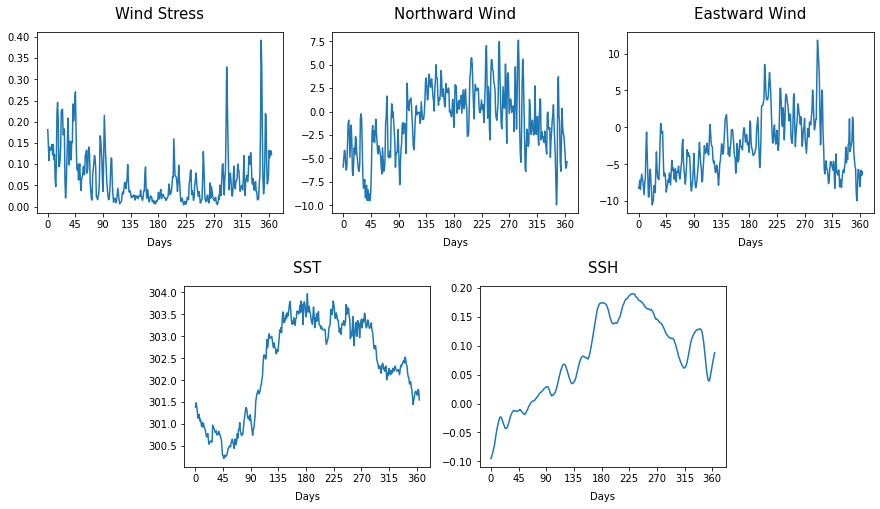

In [12]:
# Extracting mean values for different variables
mean_temp = np.mean(df.to_numpy()[:, :187], axis=1)
mean_nw = np.mean(df.to_numpy()[:, 187:374], axis=1)
mean_ew = np.mean(df.to_numpy()[:, 374:561], axis=1)
mean_ws = np.mean(df.to_numpy()[:, 561:748], axis=1)
mean_ssh = np.mean(df.to_numpy()[:, 748:], axis=1)

# Organizing mean values and titles in a dictionary
array_and_title = {
    0: [mean_ws, 'Wind Stress'],
    1: [mean_nw, 'Northward Wind'],
    2: [mean_ew, 'Eastward Wind'],
    3: [mean_temp, 'SST'],
    4: [mean_ssh, 'SSH']
}

# Creating a figure with subplots using GridSpec
fig = plt.figure(figsize=(15, 8))
gs = GridSpec(2, 6, wspace=0.5, hspace=0.4)

plots = np.empty(5, dtype=object)

# Creating subplots and plotting mean values
for i in range(5):
    if i < 3:
        plots[i] = fig.add_subplot(gs[0, 2*i:2*i+2])
    else:
        plots[i] = fig.add_subplot(gs[1, 2*i-5:2*i-3])

    plots[i].plot(array_and_title[i][0])
    plots[i].set_title(array_and_title[i][1], fontsize=15, pad=13)
    plots[i].set_xlabel("Days", loc="center", labelpad=8)
    plots[i].set_xticks(np.arange(0, 361, 45))

plt.show()


<style>
    p {
        line-height: 1.5;
    }
</style>

<p style="text-align: justify;"> 
Each of the above plots depicts the average of the 187 entries for a given variable at each timestep. We can immediately see some similarities between the variable we are forecasting, SSH, and some of the other variables, particularly with SST where the similarities are very strong indeed. With all bar Wind Stress, the variables start relatively low with a gradual upward trend in the months leading up to summer. With the starting point ranging between the 5th and 6th month mark, the trend then plateaus for around three months before gently falling back down between halfway and all the way back to the level it was at the beginning of the year. This supports the notion that these would be good indicators when forecasting SSH. At first glance, Wind Stress appears to be very different compared to all other variables. However, once the plot is inverted and bounds are set on the y-axis to exclude 2 potential outliers, a connection to other variables is revealed.
</p>

<style>
    p {
        line-height: 1.5;
    }
</style>

<p style="font-size:22px;"> &emsp; &emsp; 3.3. Data Structuring and Preprocessing<p>

<p style="text-align: justify;"> 
I started by loading the main NetCDF variables and converting them to three-dimensional numpy arrays of shape (365, 15, 15) by re-gridding and converting 6-hourly mean data to daily mean data for wind variables. Then, I converted these variables into a new pandas dataframe where each column contains the values for a variable at a particular point in the grid and each row represents the values for all variables at all points in the grid on a given day of the year. I dropped all columns representing variables at coordinates where the surface type is land and add two new variables, "Year sin" and "Year cos", which are the original time steps converted to their sine and cosine values, respectively. This transformation clarifies the cyclical significance of the time feature and augments the information qualitatively given to the algorithm.
<br/>

Now, I extract X and y arrays from the dataframe, later to be divided into training, validation, and testing sets. X and y are divided into the training, validation, and testing sets. To begin with, the window size is set to 7, equivalent to one week. X and y are extracted from the dataframe with shapes (358, 7, 937) and (358, 187) respectively. Standardization of all the features in each dataset is done to put them on the same scale. The testing set spans 28 instances, equivalent to four weeks, so that the algorithm's performance is evaluated on its ability to forecast 4 weeks of sea surface height data.
</p>

In [13]:
# Extract X and y
window_size = 7

# Convert pandas DataFrame into X and y numpy arrays for model training.
def df_to_X_y(df, window_size=window_size):
    df_as_np = df.values
    X, y = [], []
    for i in range(len(df_as_np) - window_size):
        X.append(df_as_np[i:i + window_size])
        y.append(df_as_np[i + window_size, 748:935])
    return np.array(X), np.array(y)

X1, y1 = df_to_X_y(df)
print(f'Window size = {window_size}')
print(f'X shape = {X1.shape}')
print(f'y shape = {y1.shape}')


Window size = 7
X shape = (358, 7, 937)
y shape = (358, 187)


In [14]:
# Divide data into train, validate, and test sets
days = X1.shape[0]
lfw = days - 28  # days before the last four weeks
lew = days - 56  # days before the last eight weeks

X1_train, y1_train = X1[:lew], y1[:lew]
X1_val, y1_val = X1[lew:lfw], y1[lew:lfw]
X1_test, y1_test = X1[lfw:], y1[lfw:]

# Print the shapes of the data
print(f"X_train shape = {X1_train.shape}")
print(f"y_train shape = {y1_train.shape}")
print(f"X_val shape = {X1_val.shape}")
print(f"y_val shape = {y1_val.shape}")
print(f"X_test shape = {X1_test.shape}")
print(f"y_test shape = {y1_test.shape}")


X_train shape = (302, 7, 937)
y_train shape = (302, 187)
X_val shape = (28, 7, 937)
y_val shape = (28, 187)
X_test shape = (28, 7, 937)
y_test shape = (28, 187)


In [15]:
# Standardization

ssh_training_mean, ssh_training_std = np.empty(187), np.empty(187)
stress_training_mean, stress_training_std = np.empty(187), np.empty(187)
east_training_mean, east_training_std = np.empty(187), np.empty(187)
north_training_mean, north_training_std = np.empty(187), np.empty(187)
temp_training_mean, temp_training_std = np.empty(187), np.empty(187)

# Calculate the means and standard deviations for each feature
for i in range(187):
    ssh_training_mean[i], ssh_training_std[i] = np.mean(X1_train[:, :, i+4*187]), np.std(X1_train[:, :, i+4*187])
    stress_training_mean[i], stress_training_std[i] = np.mean(X1_train[:, :, i+3*187]), np.std(X1_train[:, :, i+3*187])
    east_training_mean[i], east_training_std[i] = np.mean(X1_train[:, :, i+2*187]), np.std(X1_train[:, :, i+2*187])
    north_training_mean[i], north_training_std[i] = np.mean(X1_train[:, :, i+187]), np.std(X1_train[:, :, i+187])
    temp_training_mean[i], temp_training_std[i] = np.mean(X1_train[:, :, i]), np.std(X1_train[:, :, i])

# Preprocess the data by standardizing each feature
def preprocess(X, y):
    for i in range(187):
        X[:, :, i+4*187] = (X[:, :, i+4*187] - ssh_training_mean[i]) / ssh_training_std[i]
        X[:, :, i+3*187] = (X[:, :, i+3*187] - stress_training_mean[i]) / stress_training_std[i]
        X[:, :, i+2*187] = (X[:, :, i+2*187] - east_training_mean[i]) / east_training_std[i]
        X[:, :, i+187] = (X[:, :, i+187] - north_training_mean[i]) / north_training_std[i]
        X[:, :, i] = (X[:, :, i] - temp_training_mean[i]) / temp_training_std[i]

        y[:, i] = (y[:, i] - ssh_training_mean[i]) / ssh_training_std[i]

# Call the preprocess function on the training, validation, and test sets
preprocess(X1_train, y1_train)
preprocess(X1_val, y1_val)
preprocess(X1_test, y1_test)

<p style="font-size:25px;"><b>4. Training, Testing and Comparing Performance</b></p>

In [16]:
# Setup


# Round down a float number to the specified decimal places.
def round_decimals_down(number: float, decimals: int = 1) -> float:
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more")
    elif decimals == 0:
        return math.floor(number)

    factor = 10 ** decimals
    return math.floor(number * factor) / factor

# Round up a float number to the specified decimal places.
def round_decimals_up(number: float, decimals: int = 2) -> float:
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more")
    elif decimals == 0:
        return math.ceil(number)

    factor = 10 ** decimals
    return math.ceil(number * factor) / factor


# Define plot function to plot predictions against actuals.
def plot_predictions(model, X, y):
    predictions = model.predict(X).flatten()
    MSE = mse(y.flatten(), predictions)
    RMSE = np.sqrt(MSE)
    MAE = mae(y.flatten(), predictions)

    print('MSE = ', str(MSE))
    print('RMSE = ', str(RMSE))
    print('MAE = ', str(MAE))

    dfs = np.empty(8, dtype=object)
    mins = np.empty(8, dtype=object)
    maxs = np.empty(8, dtype=object)

    for i in range(8):
        dfs[i] = pd.DataFrame(data={'Predictions': predictions[i::187], 'Actuals': y[:, i]})
        mins[i] = np.min(dfs[i].to_numpy())
        maxs[i] = np.max(dfs[i].to_numpy())

    u = round_decimals_up(np.max(maxs)) + 0.1
    d = round_decimals_down(np.min(mins)) - 0.1

    plots = np.empty(8, dtype=object)

    fig = plt.figure(figsize=(16, 7))
    gs = GridSpec(2, 4)

    for i in range(8):
        if i < 4:
            plots[i] = plt.subplot(gs[0, i])
        else:
            plots[i] = plt.subplot(gs[1, i - 4])

        plots[i].plot(dfs[i]['Predictions'][:])
        plots[i].plot(dfs[i]['Actuals'][:])
        plots[i].set_title("Grid" + str(i + 1), {'fontsize': 12}, pad=10)
        plots[i].set_xlabel("Days", loc="left", labelpad=5)
        plots[i].set_xticks(np.arange(0, 29, 7))
        plots[i].set_ybound(d, u)

    gs.update(wspace=0.3, hspace=0.4)


# Define loss history callback to keep track of training losses.
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

<style>
    p {
        line-height: 1.5;
    }
</style>

<p style="font-size:22px;"> &emsp; &emsp; 4.1. Forecasting Climate Data with Deep Learning Models</p>

<p style="text-align: justify;"> 
Traditional weather forecasting algorithms rely heavily on human expertise and a multitude of rules and equations to simulate climate variables, resulting in inaccuracies due to the complexity and volatility of climate. However, machine learning models, particularly deep learning models, have been developed over the last few decades and can accurately forecast weather data without requiring an in-depth understanding of climate theories. These models extrapolate their own rules through exposure to large quantities of data provided by programmers. Deep learning models have been used in various real-world scenarios, including monitoring forest fires and tropical storms.
<br/>

In my research, I found that variations of LSTMs proved successful for sea surface height forecasting, with LSTMs and GRUs being particularly effective due to their ability to address the vanishing gradient problem characteristic of simple RNNs. One-dimensional CNNs were also used for computational efficiency. The first recorded use of a deep learning model for weather forecasting was in 2016, where researchers successfully demonstrated its capabilities in reproducing results obtained through conventional methods.
</p>

<p style="font-size:22px;"> &emsp; &emsp; 4.2. Error Metrics</p>

<p style="text-align: justify;"> 
In order to evaluate the accuracy of different forecasting models, three popular Key Performance Indicators (KPIs) are used: Mean Square Error (MSE), Root Mean Square Error (RMSE), and Mean Absolute Error (MAE). MSE is calculated by averaging the squared difference between predicted and observed values, and RMSE is the square root of MSE. A lower MSE and RMSE indicate a more accurate model. MAE is more straightforward and skips the squaring step in calculating errors, making it more interpretable. Once more, a lower MAE indicates better model performance. MSE is used here as the loss function during model training and testing because it is faster to compute and punishes larger errors, yet all three KPIs are used when comparing the performance of different models.
</p>

<p style="font-size:22px;"> &emsp; &emsp; 4.3. LSTM</p>

<p style="text-align: justify;"> 
An LSTM is a type of recurrent neural network that uses three gates to manage information: input, forget, and output gates. In this thesis, "vanilla" describes networks that were set up with a fairly basic structure. For LSTM, it learns from the original sequence in a forward pass, there is only one hidden LSTM layer. Bidirectional LSTMs are an extension of LSTMs where two models are introduced instead of one. The first model learns the sequence in the order that is provided and the second learns the same sequence backwards. Stacked LSTM networks are simply those that consist of more than one hidden LSTM layer. In all cases the LSTM layers are followed by dense layers that reduce the output size to the desired shape. The final dense layer uses linear activation for a linear output, while the preceding ones use the rectified linear unit activation (ReLU) function
</p>

In [10]:
# Define the model architecture
vlstm_model_ws7_e50 = Sequential()
vlstm_model_ws7_e50.add(InputLayer((window_size, 937)))
vlstm_model_ws7_e50.add(LSTM(640))
vlstm_model_ws7_e50.add(Dense(320, activation='relu'))
vlstm_model_ws7_e50.add(Dense(187, activation='linear'))

# Print a summary of the model architecture
vlstm_model_ws7_e50.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 640)               4039680   
                                                                 
 dense (Dense)               (None, 320)               205120    
                                                                 
 dense_1 (Dense)             (None, 187)               60027     
                                                                 
Total params: 4,304,827
Trainable params: 4,304,827
Non-trainable params: 0
_________________________________________________________________


In [11]:
# create model checkpoint to save the best model
cp1 = ModelCheckpoint('vlstm_model_ws7_e50/', save_best_only=True)

# create a loss history instance
lh1 = LossHistory()

# compile the model with appropriate loss, optimizer and metrics
vlstm_model_ws7_e50.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

# fit the model with training and validation data, and the previously defined callbacks
vlstm_model_ws7_e50.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=50, verbose=0, callbacks=[cp1, lh1])

# load the best saved model
vlstm_model_ws7_e50 = load_model('vlstm_model_ws7_e50/')

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


MSE =  0.3510211288795988
RMSE =  0.592470361182396
MAE =  0.4793806049327097


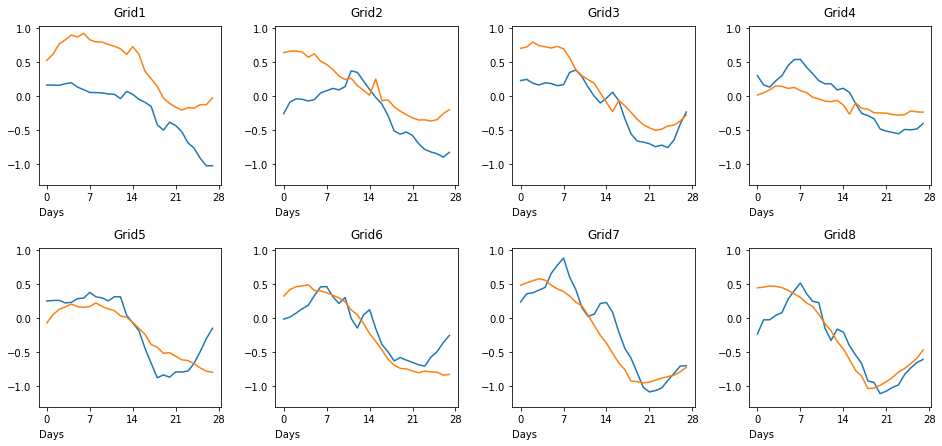

In [12]:
# Best performing Vanilla LSTM with window size = 7 and 50 epochs
plot_predictions(vlstm_model_ws7_e50, X1_test, y1_test)

<style>
    p {
        line-height: 1.5;
    }
</style>

<p style="font-size:18px;"> &emsp; &emsp; &emsp; &emsp; <em>4.3.1. Vanilla LSTM</em></p>

<p style="text-align: justify;"> 
I started by training a vanilla LSTM network above to firstly perform some parameter tuning in order to determine the optimal window size and number of epochs to be used for training of all models. The network ran for 50 epochs with MSE as the loss function, Adam optimization, and a low learning rate of 0.0001 to avoid sacrificing accuracy. I used these parameters, except for the number of epochs, for all models built in this thesis. The sequential model had an input layer of shape (7, 937) since the X sets were created with a window size of 7, followed by an LSTM layer, a Dense layer with ReLU activation function, and a Dense layer with a linear activation function returning the predictions. After running for 50 epochs, I saved the best performing model with the lowest MSE and used it to make a forecast with the X testing set. The forecasted SSH was evaluated with KPIs such as MSE, RMSE, and MAE. As there are no KPIs from competing models to compare with yet, one can perform a visual comparison of forecasted and actual SSH in the first few grids shown above. Although the predicted SSH in some grids seem to follow the observed SSH quite well, the overall accuracy seems questionable.
</p>

<p style="font-size:18px;"> &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; <em>4.3.1.1. Number of Epochs</em></p>

<p style="text-align: justify;"> 
When the model was being fit, the MSE of the forecasted values and observed values in the validation set was recorded after each epoch. The plots below depict these MSEs. This plot on the left below includes the MSEs for all 50 epochs whereas the plot on the right excludes the MSEs in the first 10 epochs as their values are so large that the rate at which remaining MSEs are decreasing is difficult to observe. The plot on the right below shows that the MSE is still dropping fairly sharply until around the 25th epoch and so I decided cap off the number of epochs for all models at 25 as going for a larger number of epochs increases the risk of overfitting the training dataset without significant improvement of accuracy.
</p>

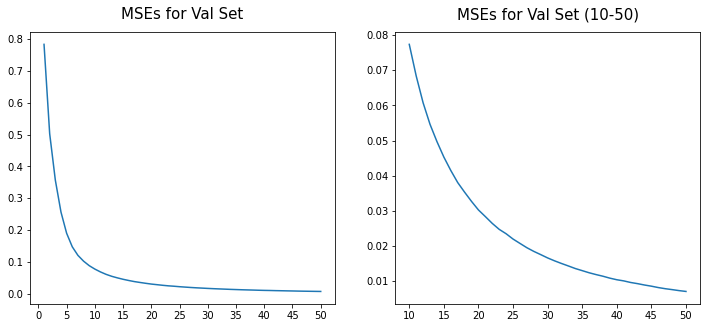

In [13]:
# Create x-axis labels for the two subplots
ax0_xlab = [str(n) for n in np.arange(1, 52, 5) - 1]
ax1_xlab = [str(n) for n in np.arange(11, 52, 5) - 1]

# Create a list of losses with the first value as NaN for the y-axis of the subplots
losses = [np.nan] + lh1.losses

# Create a figure with two subplots
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 2)

# Add the first subplot to the figure and plot the losses
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(losses)
ax0.set_xticks(np.arange(0, 51, 5))
ax0.set_xticklabels(ax0_xlab)
ax0.set_title("MSEs for Val Set", {'fontsize': 15}, pad=13)

# Add the second subplot to the figure and plot the losses from index 10 onwards
ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(losses[10:])
ax1.set_xticks(np.arange(0, 41, 5))
ax1.set_xticklabels(ax1_xlab)
ax1.set_title("MSEs for Val Set (10-50)", {'fontsize': 15}, pad=13)

# Adjust the horizontal space between the subplots
gs.update(wspace=0.2)

# Show the figure
plt.show()

<style>
    p {
        line-height: 1.5;
    }
</style>

<p style="font-size:18px;"> &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; <em>4.3.1.2. Window Size</em></p>

<p style="text-align: justify;"> 
Having determined the optimal number of epochs, new training, validation and testing sets need to be extracted with different window sizes ranging from 2 to 10 in order to see how window size affects the accuracy of the forecast. For each collection of training, validation and testing sets, a new vanilla LSTM network with 25 epochs is created, trained and tested below. In each instance, all the KPIs are recorded as well as the time in seconds it takes to train. The following plots depicts how the different window sizes impact these measurements. What is immediately clear is that the values for all these measurements tend to decrease, meaning that the model is improving in terms of accuracy and efficiency as the window size decreases. The window size for subsequent models is therefore set to 2.
</p>

In [14]:
# create a dataframe to store the metrics
df_err_ws = pd.DataFrame(data={'Metrics': ['MSE', 'RMSE', 'MAE', 'MAPE', 'Time (s)']})

# define window sizes
win_sizes = np.arange(2, 11)[::-1]

# Iterate over each window size and preprocess the data, train a model, and evaluate the performance
for ws in win_sizes:

    # Convert DataFrame to input/output arrays with the specified window size.
    def df_to_X_y(df, window_size=ws):
        df_as_np = df.to_numpy()
        X = []
        y = []
        for i in range(len(df_as_np) - window_size):
            row = [r for r in df_as_np[i:i+window_size]]
            X.append(row)
            label = df_as_np[i+window_size][748:935].tolist()
            y.append(label)
        return np.array(X), np.array(y)

    # Convert the DataFrame to input/output arrays with the current window size
    X1, y1 = df_to_X_y(df)

    # Define the training, validation, and test sets
    days = np.shape(X1)[0]
    lfw = days-28 # days before the last 4 weeks
    lew = days-56 # days before the last 8 weeks
    X1_train, y1_train = X1[:lew], y1[:lew]
    X1_val, y1_val = X1[lew:lfw], y1[lew:lfw]
    X1_test, y1_test = X1[lfw:], y1[lfw:]

    # Calculate mean and standard deviation for each feature of the training set
    ssh_training_mean = np.empty(187, dtype=float)
    ssh_training_std = np.empty(187, dtype=float)
    stress_training_mean = np.empty(187, dtype=float)
    stress_training_std = np.empty(187, dtype=float)
    east_training_mean = np.empty(187, dtype=float)
    east_training_std = np.empty(187, dtype=float)
    north_training_mean = np.empty(187, dtype=float)
    north_training_std = np.empty(187, dtype=float)
    temp_training_mean = np.empty(187, dtype=float)
    temp_training_std = np.empty(187, dtype=float)
    
    for i in range(187):
        ssh_training_mean[i] = np.mean(X1_train[:, :, i+4*187])
        ssh_training_std[i] = np.std(X1_train[:, :, i+4*187])
        stress_training_mean[i] = np.mean(X1_train[:, :, i+3*187])
        stress_training_std[i] = np.std(X1_train[:, :, i+3*187])
        east_training_mean[i] = np.mean(X1_train[:, :, i+2*187])
        east_training_std[i] = np.std(X1_train[:, :, i+2*187])
        north_training_mean[i] = np.mean(X1_train[:, :, i+187])
        north_training_std[i] = np.std(X1_train[:, :, i+187])
        temp_training_mean[i] = np.mean(X1_train[:, :, i])
        temp_training_std[i] = np.std(X1_train[:, :, i])

    # Preprocess input and output data by normalizing them with means and standard deviations.
    def preprocess(X, y):
        for i in range(187):
            # Normalize SSH feature
            X[:, :, i + 4 * 187] = (X[:, :, i + 4 * 187] - ssh_training_mean[i]) / ssh_training_std[i]
            # Normalize stress feature
            X[:, :, i + 3 * 187] = (X[:, :, i + 3 * 187] - stress_training_mean[i]) / stress_training_std[i]
            # Normalize east feature
            X[:, :, i + 2 * 187] = (X[:, :, i + 2 * 187] - east_training_mean[i]) / east_training_std[i]
            # Normalize north feature
            X[:, :, i + 187] = (X[:, :, i + 187] - north_training_mean[i]) / north_training_std[i]
            # Normalize temperature feature
            X[:, :, i] = (X[:, :, i] - temp_training_mean[i]) / temp_training_std[i]

            # Normalize output data
            y[:, i] = (y[:, i] - ssh_training_mean[i]) / ssh_training_std[i]

    # Preprocess training, validation and test data
    preprocess(X1_train, y1_train)
    preprocess(X1_val, y1_val)
    preprocess(X1_test, y1_test)

    # Set start time
    start = time.time()

    # Create vlstm model
    vlstm_model = Sequential()
    vlstm_model.add(InputLayer((ws, 937)))
    vlstm_model.add(LSTM(640))
    vlstm_model.add(Dense(320, 'relu'))
    vlstm_model.add(Dense(187, 'linear'))

    # Set model checkpoint
    cp1 = ModelCheckpoint('vlstm_model/', save_best_only=True)

    # Compile model
    vlstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

    # Train model and save best weights
    vlstm_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp1])

    # Load best weights
    vlstm_model = load_model('vlstm_model/')

    # Set end time
    end = time.time()

    # Make predictions and calculate evaluation metrics
    predictions = vlstm_model.predict(X1_test).flatten()
    df_err_ws[f'Win Size {ws}'] = [
        mse(y1_test.flatten(), predictions),
        np.sqrt(mse(y1_test.flatten(), predictions)),
        mae(y1_test.flatten(), predictions),
        mape(y1_test.flatten(), predictions),
        end - start
    ]


Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.7585 - root_mean_squared_error: 0.8709

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 14s 1s/step - loss: 0.7585 - root_mean_squared_error: 0.8709 - val_loss: 0.4737 - val_root_mean_squared_error: 0.6882
Epoch 2/25
10/10 [==============================] - 2s 252ms/step - loss: 0.4632 - root_mean_squared_error: 0.6806 - val_loss: 0.5898 - val_root_mean_squared_error: 0.7680
Epoch 3/25
10/10 [==============================] - 3s 270ms/step - loss: 0.3158 - root_mean_squared_error: 0.5619 - val_loss: 0.6419 - val_root_mean_squared_error: 0.8012
Epoch 4/25
10/10 [==============================] - 3s 262ms/step - loss: 0.2241 - root_mean_squared_error: 0.4734 - val_loss: 0.6362 - val_root_mean_squared_error: 0.7976
Epoch 5/25
10/10 [==============================] - 3s 256ms/step - loss: 0.1661 - root_mean_squared_error: 0.4075 - val_loss: 0.6181 - val_root_mean_squared_error: 0.7862
Epoch 6/25
10/10 [==============================] - 3s 247ms/step - loss: 0.1308 - root_mean_squared_error: 0.3616 - val_loss: 0.5790 - val_root_mean_squ

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 8s 893ms/step - loss: 0.0649 - root_mean_squared_error: 0.2547 - val_loss: 0.4713 - val_root_mean_squared_error: 0.6865
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0581 - root_mean_squared_error: 0.2411

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 9s 945ms/step - loss: 0.0581 - root_mean_squared_error: 0.2411 - val_loss: 0.4614 - val_root_mean_squared_error: 0.6793
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0522 - root_mean_squared_error: 0.2284

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 9s 1s/step - loss: 0.0522 - root_mean_squared_error: 0.2284 - val_loss: 0.4535 - val_root_mean_squared_error: 0.6734
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0474 - root_mean_squared_error: 0.2177

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 9s 1s/step - loss: 0.0474 - root_mean_squared_error: 0.2177 - val_loss: 0.4442 - val_root_mean_squared_error: 0.6665
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0429 - root_mean_squared_error: 0.2072

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0429 - root_mean_squared_error: 0.2072 - val_loss: 0.4364 - val_root_mean_squared_error: 0.6606
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0392 - root_mean_squared_error: 0.1981

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0392 - root_mean_squared_error: 0.1981 - val_loss: 0.4266 - val_root_mean_squared_error: 0.6531
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0360 - root_mean_squared_error: 0.1898

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0360 - root_mean_squared_error: 0.1898 - val_loss: 0.4190 - val_root_mean_squared_error: 0.6473
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0333 - root_mean_squared_error: 0.1826

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0333 - root_mean_squared_error: 0.1826 - val_loss: 0.4147 - val_root_mean_squared_error: 0.6440
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0309 - root_mean_squared_error: 0.1757

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0309 - root_mean_squared_error: 0.1757 - val_loss: 0.4066 - val_root_mean_squared_error: 0.6377
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0288 - root_mean_squared_error: 0.1698

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 9s 920ms/step - loss: 0.0288 - root_mean_squared_error: 0.1698 - val_loss: 0.4012 - val_root_mean_squared_error: 0.6334
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0268 - root_mean_squared_error: 0.1638

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 9s 947ms/step - loss: 0.0268 - root_mean_squared_error: 0.1638 - val_loss: 0.3941 - val_root_mean_squared_error: 0.6278
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0251 - root_mean_squared_error: 0.1585

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 9s 1s/step - loss: 0.0251 - root_mean_squared_error: 0.1585 - val_loss: 0.3902 - val_root_mean_squared_error: 0.6246
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0233 - root_mean_squared_error: 0.1528

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 9s 952ms/step - loss: 0.0233 - root_mean_squared_error: 0.1528 - val_loss: 0.3868 - val_root_mean_squared_error: 0.6219
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0220 - root_mean_squared_error: 0.1483

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0220 - root_mean_squared_error: 0.1483 - val_loss: 0.3797 - val_root_mean_squared_error: 0.6162
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0208 - root_mean_squared_error: 0.1441

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 8s 886ms/step - loss: 0.0208 - root_mean_squared_error: 0.1441 - val_loss: 0.3769 - val_root_mean_squared_error: 0.6140
Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8136 - root_mean_squared_error: 0.9020

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 11s 932ms/step - loss: 0.8136 - root_mean_squared_error: 0.9020 - val_loss: 0.4327 - val_root_mean_squared_error: 0.6578
Epoch 2/25
10/10 [==============================] - 2s 240ms/step - loss: 0.5239 - root_mean_squared_error: 0.7238 - val_loss: 0.5301 - val_root_mean_squared_error: 0.7281
Epoch 3/25
10/10 [==============================] - 2s 220ms/step - loss: 0.3734 - root_mean_squared_error: 0.6110 - val_loss: 0.6110 - val_root_mean_squared_error: 0.7817
Epoch 4/25
10/10 [==============================] - 2s 220ms/step - loss: 0.2692 - root_mean_squared_error: 0.5189 - val_loss: 0.6195 - val_root_mean_squared_error: 0.7871
Epoch 5/25
10/10 [==============================] - 2s 223ms/step - loss: 0.1980 - root_mean_squared_error: 0.4450 - val_loss: 0.6071 - val_root_mean_squared_error: 0.7792
Epoch 6/25
10/10 [==============================] - 2s 228ms/step - loss: 0.1516 - root_mean_squared_error: 0.3894 - val_loss: 0.5776 - val_root_mean_

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 807ms/step - loss: 0.0584 - root_mean_squared_error: 0.2416 - val_loss: 0.4321 - val_root_mean_squared_error: 0.6573
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0528 - root_mean_squared_error: 0.2298

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 9s 990ms/step - loss: 0.0528 - root_mean_squared_error: 0.2298 - val_loss: 0.4238 - val_root_mean_squared_error: 0.6510
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0477 - root_mean_squared_error: 0.2184

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 12s 1s/step - loss: 0.0477 - root_mean_squared_error: 0.2184 - val_loss: 0.4142 - val_root_mean_squared_error: 0.6436
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0434 - root_mean_squared_error: 0.2084

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 14s 1s/step - loss: 0.0434 - root_mean_squared_error: 0.2084 - val_loss: 0.4082 - val_root_mean_squared_error: 0.6389
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0400 - root_mean_squared_error: 0.2000

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0400 - root_mean_squared_error: 0.2000 - val_loss: 0.4001 - val_root_mean_squared_error: 0.6326
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0367 - root_mean_squared_error: 0.1916

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0367 - root_mean_squared_error: 0.1916 - val_loss: 0.3945 - val_root_mean_squared_error: 0.6281
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0340 - root_mean_squared_error: 0.1843

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 9s 1000ms/step - loss: 0.0340 - root_mean_squared_error: 0.1843 - val_loss: 0.3880 - val_root_mean_squared_error: 0.6229
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0315 - root_mean_squared_error: 0.1775

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0315 - root_mean_squared_error: 0.1775 - val_loss: 0.3826 - val_root_mean_squared_error: 0.6186
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0293 - root_mean_squared_error: 0.1712

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 8s 892ms/step - loss: 0.0293 - root_mean_squared_error: 0.1712 - val_loss: 0.3788 - val_root_mean_squared_error: 0.6154
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0275 - root_mean_squared_error: 0.1659

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 8s 894ms/step - loss: 0.0275 - root_mean_squared_error: 0.1659 - val_loss: 0.3749 - val_root_mean_squared_error: 0.6123
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0258 - root_mean_squared_error: 0.1606

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 8s 910ms/step - loss: 0.0258 - root_mean_squared_error: 0.1606 - val_loss: 0.3695 - val_root_mean_squared_error: 0.6079
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0241 - root_mean_squared_error: 0.1552

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 8s 811ms/step - loss: 0.0241 - root_mean_squared_error: 0.1552 - val_loss: 0.3673 - val_root_mean_squared_error: 0.6061
Epoch 25/25
10/10 [==============================] - 3s 259ms/step - loss: 0.0226 - root_mean_squared_error: 0.1503 - val_loss: 0.3684 - val_root_mean_squared_error: 0.6070
Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8220 - root_mean_squared_error: 0.9066

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 10s 851ms/step - loss: 0.8220 - root_mean_squared_error: 0.9066 - val_loss: 0.4221 - val_root_mean_squared_error: 0.6497
Epoch 2/25
10/10 [==============================] - 2s 236ms/step - loss: 0.5294 - root_mean_squared_error: 0.7276 - val_loss: 0.5318 - val_root_mean_squared_error: 0.7292
Epoch 3/25
10/10 [==============================] - 2s 225ms/step - loss: 0.3726 - root_mean_squared_error: 0.6104 - val_loss: 0.6319 - val_root_mean_squared_error: 0.7949
Epoch 4/25
10/10 [==============================] - 2s 208ms/step - loss: 0.2699 - root_mean_squared_error: 0.5195 - val_loss: 0.6439 - val_root_mean_squared_error: 0.8024
Epoch 5/25
10/10 [==============================] - 2s 215ms/step - loss: 0.2006 - root_mean_squared_error: 0.4479 - val_loss: 0.6186 - val_root_mean_squared_error: 0.7865
Epoch 6/25
10/10 [==============================] - 2s 233ms/step - loss: 0.1562 - root_mean_squared_error: 0.3953 - val_loss: 0.5871 - val_root_mean_

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0398 - root_mean_squared_error: 0.1995 - val_loss: 0.4183 - val_root_mean_squared_error: 0.6467
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0369 - root_mean_squared_error: 0.1921

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 8s 857ms/step - loss: 0.0369 - root_mean_squared_error: 0.1921 - val_loss: 0.4153 - val_root_mean_squared_error: 0.6444
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0343 - root_mean_squared_error: 0.1852

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0343 - root_mean_squared_error: 0.1852 - val_loss: 0.4088 - val_root_mean_squared_error: 0.6394
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0318 - root_mean_squared_error: 0.1785

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0318 - root_mean_squared_error: 0.1785 - val_loss: 0.4027 - val_root_mean_squared_error: 0.6345
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0297 - root_mean_squared_error: 0.1724

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0297 - root_mean_squared_error: 0.1724 - val_loss: 0.3957 - val_root_mean_squared_error: 0.6290
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0278 - root_mean_squared_error: 0.1667

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0278 - root_mean_squared_error: 0.1667 - val_loss: 0.3936 - val_root_mean_squared_error: 0.6273
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0262 - root_mean_squared_error: 0.1619

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0262 - root_mean_squared_error: 0.1619 - val_loss: 0.3896 - val_root_mean_squared_error: 0.6242
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0247 - root_mean_squared_error: 0.1570

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0247 - root_mean_squared_error: 0.1570 - val_loss: 0.3866 - val_root_mean_squared_error: 0.6218
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0232 - root_mean_squared_error: 0.1523

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0232 - root_mean_squared_error: 0.1523 - val_loss: 0.3815 - val_root_mean_squared_error: 0.6177
Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.7967 - root_mean_squared_error: 0.8926

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 14s 1s/step - loss: 0.7967 - root_mean_squared_error: 0.8926 - val_loss: 0.3982 - val_root_mean_squared_error: 0.6311
Epoch 2/25
10/10 [==============================] - 3s 276ms/step - loss: 0.5200 - root_mean_squared_error: 0.7211 - val_loss: 0.4887 - val_root_mean_squared_error: 0.6991
Epoch 3/25
10/10 [==============================] - 3s 268ms/step - loss: 0.3572 - root_mean_squared_error: 0.5977 - val_loss: 0.5774 - val_root_mean_squared_error: 0.7598
Epoch 4/25
10/10 [==============================] - 3s 264ms/step - loss: 0.2526 - root_mean_squared_error: 0.5025 - val_loss: 0.5927 - val_root_mean_squared_error: 0.7699
Epoch 5/25
10/10 [==============================] - 3s 263ms/step - loss: 0.1855 - root_mean_squared_error: 0.4307 - val_loss: 0.5698 - val_root_mean_squared_error: 0.7548
Epoch 6/25
10/10 [==============================] - 3s 292ms/step - loss: 0.1429 - root_mean_squared_error: 0.3780 - val_loss: 0.5128 - val_root_mean_squ

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0597 - root_mean_squared_error: 0.2443 - val_loss: 0.3916 - val_root_mean_squared_error: 0.6258
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0534 - root_mean_squared_error: 0.2311

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 9s 1s/step - loss: 0.0534 - root_mean_squared_error: 0.2311 - val_loss: 0.3874 - val_root_mean_squared_error: 0.6224
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0482 - root_mean_squared_error: 0.2195

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0482 - root_mean_squared_error: 0.2195 - val_loss: 0.3848 - val_root_mean_squared_error: 0.6203
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0438 - root_mean_squared_error: 0.2093

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0438 - root_mean_squared_error: 0.2093 - val_loss: 0.3777 - val_root_mean_squared_error: 0.6146
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0402 - root_mean_squared_error: 0.2006

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0402 - root_mean_squared_error: 0.2006 - val_loss: 0.3751 - val_root_mean_squared_error: 0.6124
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0368 - root_mean_squared_error: 0.1918

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 8s 922ms/step - loss: 0.0368 - root_mean_squared_error: 0.1918 - val_loss: 0.3717 - val_root_mean_squared_error: 0.6097
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0341 - root_mean_squared_error: 0.1846

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 778ms/step - loss: 0.0341 - root_mean_squared_error: 0.1846 - val_loss: 0.3665 - val_root_mean_squared_error: 0.6054
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0316 - root_mean_squared_error: 0.1778

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0316 - root_mean_squared_error: 0.1778 - val_loss: 0.3603 - val_root_mean_squared_error: 0.6002
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0295 - root_mean_squared_error: 0.1719

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 18s 2s/step - loss: 0.0295 - root_mean_squared_error: 0.1719 - val_loss: 0.3594 - val_root_mean_squared_error: 0.5995
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0276 - root_mean_squared_error: 0.1662

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 8s 852ms/step - loss: 0.0276 - root_mean_squared_error: 0.1662 - val_loss: 0.3516 - val_root_mean_squared_error: 0.5930
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0260 - root_mean_squared_error: 0.1612

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 811ms/step - loss: 0.0260 - root_mean_squared_error: 0.1612 - val_loss: 0.3486 - val_root_mean_squared_error: 0.5904
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0242 - root_mean_squared_error: 0.1556

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0242 - root_mean_squared_error: 0.1556 - val_loss: 0.3454 - val_root_mean_squared_error: 0.5877
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0228 - root_mean_squared_error: 0.1511

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0228 - root_mean_squared_error: 0.1511 - val_loss: 0.3393 - val_root_mean_squared_error: 0.5825
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0216 - root_mean_squared_error: 0.1471

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 8s 863ms/step - loss: 0.0216 - root_mean_squared_error: 0.1471 - val_loss: 0.3358 - val_root_mean_squared_error: 0.5795


Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.7721 - root_mean_squared_error: 0.8787

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 11s 892ms/step - loss: 0.7721 - root_mean_squared_error: 0.8787 - val_loss: 0.4709 - val_root_mean_squared_error: 0.6862
Epoch 2/25
10/10 [==============================] - 2s 168ms/step - loss: 0.4890 - root_mean_squared_error: 0.6993 - val_loss: 0.5809 - val_root_mean_squared_error: 0.7622
Epoch 3/25
10/10 [==============================] - 2s 169ms/step - loss: 0.3433 - root_mean_squared_error: 0.5860 - val_loss: 0.6031 - val_root_mean_squared_error: 0.7766
Epoch 4/25
10/10 [==============================] - 2s 162ms/step - loss: 0.2427 - root_mean_squared_error: 0.4927 - val_loss: 0.5985 - val_root_mean_squared_error: 0.7736
Epoch 5/25
10/10 [==============================] - 2s 169ms/step - loss: 0.1790 - root_mean_squared_error: 0.4231 - val_loss: 0.5762 - val_root_mean_squared_error: 0.7591
Epoch 6/25
10/10 [==============================] - 3s 325ms/step - loss: 0.1397 - root_mean_squared_error: 0.3738 - val_loss: 0.5239 - val_root_mean_

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 9s 1s/step - loss: 0.0987 - root_mean_squared_error: 0.3141 - val_loss: 0.4503 - val_root_mean_squared_error: 0.6711
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.0864 - root_mean_squared_error: 0.2939

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 734ms/step - loss: 0.0864 - root_mean_squared_error: 0.2939 - val_loss: 0.4185 - val_root_mean_squared_error: 0.6469
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.0766 - root_mean_squared_error: 0.2767

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 8s 833ms/step - loss: 0.0766 - root_mean_squared_error: 0.2767 - val_loss: 0.3981 - val_root_mean_squared_error: 0.6309
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0685 - root_mean_squared_error: 0.2618

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 778ms/step - loss: 0.0685 - root_mean_squared_error: 0.2618 - val_loss: 0.3875 - val_root_mean_squared_error: 0.6225
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0616 - root_mean_squared_error: 0.2482

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 8s 917ms/step - loss: 0.0616 - root_mean_squared_error: 0.2482 - val_loss: 0.3783 - val_root_mean_squared_error: 0.6151
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0555 - root_mean_squared_error: 0.2357

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 708ms/step - loss: 0.0555 - root_mean_squared_error: 0.2357 - val_loss: 0.3728 - val_root_mean_squared_error: 0.6106
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0504 - root_mean_squared_error: 0.2245

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 8s 821ms/step - loss: 0.0504 - root_mean_squared_error: 0.2245 - val_loss: 0.3652 - val_root_mean_squared_error: 0.6043
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0462 - root_mean_squared_error: 0.2150

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 8s 838ms/step - loss: 0.0462 - root_mean_squared_error: 0.2150 - val_loss: 0.3610 - val_root_mean_squared_error: 0.6008
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0425 - root_mean_squared_error: 0.2061

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 792ms/step - loss: 0.0425 - root_mean_squared_error: 0.2061 - val_loss: 0.3586 - val_root_mean_squared_error: 0.5988
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0392 - root_mean_squared_error: 0.1981

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 709ms/step - loss: 0.0392 - root_mean_squared_error: 0.1981 - val_loss: 0.3509 - val_root_mean_squared_error: 0.5924
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0365 - root_mean_squared_error: 0.1910

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0365 - root_mean_squared_error: 0.1910 - val_loss: 0.3445 - val_root_mean_squared_error: 0.5869
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0341 - root_mean_squared_error: 0.1845

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 767ms/step - loss: 0.0341 - root_mean_squared_error: 0.1845 - val_loss: 0.3394 - val_root_mean_squared_error: 0.5826
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0317 - root_mean_squared_error: 0.1781

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 760ms/step - loss: 0.0317 - root_mean_squared_error: 0.1781 - val_loss: 0.3342 - val_root_mean_squared_error: 0.5781
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0297 - root_mean_squared_error: 0.1722

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 719ms/step - loss: 0.0297 - root_mean_squared_error: 0.1722 - val_loss: 0.3288 - val_root_mean_squared_error: 0.5734
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0278 - root_mean_squared_error: 0.1668

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 755ms/step - loss: 0.0278 - root_mean_squared_error: 0.1668 - val_loss: 0.3228 - val_root_mean_squared_error: 0.5682
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0261 - root_mean_squared_error: 0.1615

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 730ms/step - loss: 0.0261 - root_mean_squared_error: 0.1615 - val_loss: 0.3191 - val_root_mean_squared_error: 0.5649
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0245 - root_mean_squared_error: 0.1565

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 731ms/step - loss: 0.0245 - root_mean_squared_error: 0.1565 - val_loss: 0.3145 - val_root_mean_squared_error: 0.5608
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0231 - root_mean_squared_error: 0.1521

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 723ms/step - loss: 0.0231 - root_mean_squared_error: 0.1521 - val_loss: 0.3095 - val_root_mean_squared_error: 0.5564


Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.7860 - root_mean_squared_error: 0.8866

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 9s 745ms/step - loss: 0.7860 - root_mean_squared_error: 0.8866 - val_loss: 0.4323 - val_root_mean_squared_error: 0.6575
Epoch 2/25
10/10 [==============================] - 2s 167ms/step - loss: 0.5062 - root_mean_squared_error: 0.7115 - val_loss: 0.5454 - val_root_mean_squared_error: 0.7385
Epoch 3/25
10/10 [==============================] - 2s 157ms/step - loss: 0.3555 - root_mean_squared_error: 0.5962 - val_loss: 0.5847 - val_root_mean_squared_error: 0.7647
Epoch 4/25
10/10 [==============================] - 2s 163ms/step - loss: 0.2570 - root_mean_squared_error: 0.5070 - val_loss: 0.5853 - val_root_mean_squared_error: 0.7651
Epoch 5/25
10/10 [==============================] - 2s 159ms/step - loss: 0.1947 - root_mean_squared_error: 0.4412 - val_loss: 0.5433 - val_root_mean_squared_error: 0.7371
Epoch 6/25
10/10 [==============================] - 2s 174ms/step - loss: 0.1526 - root_mean_squared_error: 0.3907 - val_loss: 0.5013 - val_root_mean_s

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 736ms/step - loss: 0.1073 - root_mean_squared_error: 0.3276 - val_loss: 0.4211 - val_root_mean_squared_error: 0.6489
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.0930 - root_mean_squared_error: 0.3049

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 714ms/step - loss: 0.0930 - root_mean_squared_error: 0.3049 - val_loss: 0.3990 - val_root_mean_squared_error: 0.6317
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.0821 - root_mean_squared_error: 0.2865

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 689ms/step - loss: 0.0821 - root_mean_squared_error: 0.2865 - val_loss: 0.3843 - val_root_mean_squared_error: 0.6199
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0728 - root_mean_squared_error: 0.2698

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 734ms/step - loss: 0.0728 - root_mean_squared_error: 0.2698 - val_loss: 0.3718 - val_root_mean_squared_error: 0.6097
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0653 - root_mean_squared_error: 0.2555

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 725ms/step - loss: 0.0653 - root_mean_squared_error: 0.2555 - val_loss: 0.3655 - val_root_mean_squared_error: 0.6046
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0591 - root_mean_squared_error: 0.2431

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 729ms/step - loss: 0.0591 - root_mean_squared_error: 0.2431 - val_loss: 0.3555 - val_root_mean_squared_error: 0.5962
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0538 - root_mean_squared_error: 0.2319

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 725ms/step - loss: 0.0538 - root_mean_squared_error: 0.2319 - val_loss: 0.3513 - val_root_mean_squared_error: 0.5927
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0493 - root_mean_squared_error: 0.2219

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 760ms/step - loss: 0.0493 - root_mean_squared_error: 0.2219 - val_loss: 0.3450 - val_root_mean_squared_error: 0.5874
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0454 - root_mean_squared_error: 0.2131

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 722ms/step - loss: 0.0454 - root_mean_squared_error: 0.2131 - val_loss: 0.3418 - val_root_mean_squared_error: 0.5847
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0422 - root_mean_squared_error: 0.2054

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 757ms/step - loss: 0.0422 - root_mean_squared_error: 0.2054 - val_loss: 0.3347 - val_root_mean_squared_error: 0.5785
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0395 - root_mean_squared_error: 0.1986

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 706ms/step - loss: 0.0395 - root_mean_squared_error: 0.1986 - val_loss: 0.3339 - val_root_mean_squared_error: 0.5779
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0370 - root_mean_squared_error: 0.1924

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 740ms/step - loss: 0.0370 - root_mean_squared_error: 0.1924 - val_loss: 0.3255 - val_root_mean_squared_error: 0.5705
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0347 - root_mean_squared_error: 0.1862

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 692ms/step - loss: 0.0347 - root_mean_squared_error: 0.1862 - val_loss: 0.3244 - val_root_mean_squared_error: 0.5695
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0321 - root_mean_squared_error: 0.1792

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 741ms/step - loss: 0.0321 - root_mean_squared_error: 0.1792 - val_loss: 0.3223 - val_root_mean_squared_error: 0.5677
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0302 - root_mean_squared_error: 0.1738

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 680ms/step - loss: 0.0302 - root_mean_squared_error: 0.1738 - val_loss: 0.3157 - val_root_mean_squared_error: 0.5619
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0285 - root_mean_squared_error: 0.1688

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 709ms/step - loss: 0.0285 - root_mean_squared_error: 0.1688 - val_loss: 0.3126 - val_root_mean_squared_error: 0.5591
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0270 - root_mean_squared_error: 0.1642

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 710ms/step - loss: 0.0270 - root_mean_squared_error: 0.1642 - val_loss: 0.3113 - val_root_mean_squared_error: 0.5579
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0253 - root_mean_squared_error: 0.1591

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 689ms/step - loss: 0.0253 - root_mean_squared_error: 0.1591 - val_loss: 0.3032 - val_root_mean_squared_error: 0.5506
Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8083 - root_mean_squared_error: 0.8991

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 9s 736ms/step - loss: 0.8083 - root_mean_squared_error: 0.8991 - val_loss: 0.3964 - val_root_mean_squared_error: 0.6296
Epoch 2/25
10/10 [==============================] - 1s 146ms/step - loss: 0.5410 - root_mean_squared_error: 0.7355 - val_loss: 0.4823 - val_root_mean_squared_error: 0.6945
Epoch 3/25
10/10 [==============================] - 1s 134ms/step - loss: 0.3844 - root_mean_squared_error: 0.6200 - val_loss: 0.5396 - val_root_mean_squared_error: 0.7346
Epoch 4/25
10/10 [==============================] - 1s 139ms/step - loss: 0.2772 - root_mean_squared_error: 0.5265 - val_loss: 0.5427 - val_root_mean_squared_error: 0.7367
Epoch 5/25
10/10 [==============================] - 1s 138ms/step - loss: 0.2066 - root_mean_squared_error: 0.4545 - val_loss: 0.5034 - val_root_mean_squared_error: 0.7095
Epoch 6/25
10/10 [==============================] - 1s 146ms/step - loss: 0.1631 - root_mean_squared_error: 0.4039 - val_loss: 0.4571 - val_root_mean_s

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 736ms/step - loss: 0.1027 - root_mean_squared_error: 0.3205 - val_loss: 0.3754 - val_root_mean_squared_error: 0.6127
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.0907 - root_mean_squared_error: 0.3011

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 657ms/step - loss: 0.0907 - root_mean_squared_error: 0.3011 - val_loss: 0.3592 - val_root_mean_squared_error: 0.5993
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0806 - root_mean_squared_error: 0.2838

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 714ms/step - loss: 0.0806 - root_mean_squared_error: 0.2838 - val_loss: 0.3488 - val_root_mean_squared_error: 0.5906
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0717 - root_mean_squared_error: 0.2677

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 660ms/step - loss: 0.0717 - root_mean_squared_error: 0.2677 - val_loss: 0.3421 - val_root_mean_squared_error: 0.5849
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0643 - root_mean_squared_error: 0.2535

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 718ms/step - loss: 0.0643 - root_mean_squared_error: 0.2535 - val_loss: 0.3379 - val_root_mean_squared_error: 0.5813
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0585 - root_mean_squared_error: 0.2420

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 696ms/step - loss: 0.0585 - root_mean_squared_error: 0.2420 - val_loss: 0.3285 - val_root_mean_squared_error: 0.5731
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0536 - root_mean_squared_error: 0.2314

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 689ms/step - loss: 0.0536 - root_mean_squared_error: 0.2314 - val_loss: 0.3247 - val_root_mean_squared_error: 0.5698
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0490 - root_mean_squared_error: 0.2215

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 742ms/step - loss: 0.0490 - root_mean_squared_error: 0.2215 - val_loss: 0.3200 - val_root_mean_squared_error: 0.5657
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0453 - root_mean_squared_error: 0.2129

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 655ms/step - loss: 0.0453 - root_mean_squared_error: 0.2129 - val_loss: 0.3144 - val_root_mean_squared_error: 0.5607
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0422 - root_mean_squared_error: 0.2054

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 704ms/step - loss: 0.0422 - root_mean_squared_error: 0.2054 - val_loss: 0.3081 - val_root_mean_squared_error: 0.5550
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0395 - root_mean_squared_error: 0.1988

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 705ms/step - loss: 0.0395 - root_mean_squared_error: 0.1988 - val_loss: 0.3061 - val_root_mean_squared_error: 0.5532
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0369 - root_mean_squared_error: 0.1921

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 733ms/step - loss: 0.0369 - root_mean_squared_error: 0.1921 - val_loss: 0.3019 - val_root_mean_squared_error: 0.5494
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0346 - root_mean_squared_error: 0.1861

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 690ms/step - loss: 0.0346 - root_mean_squared_error: 0.1861 - val_loss: 0.2962 - val_root_mean_squared_error: 0.5442
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0326 - root_mean_squared_error: 0.1806

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 724ms/step - loss: 0.0326 - root_mean_squared_error: 0.1806 - val_loss: 0.2926 - val_root_mean_squared_error: 0.5409
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0309 - root_mean_squared_error: 0.1758

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 681ms/step - loss: 0.0309 - root_mean_squared_error: 0.1758 - val_loss: 0.2883 - val_root_mean_squared_error: 0.5369
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0292 - root_mean_squared_error: 0.1710

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 722ms/step - loss: 0.0292 - root_mean_squared_error: 0.1710 - val_loss: 0.2835 - val_root_mean_squared_error: 0.5325
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0276 - root_mean_squared_error: 0.1660

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 658ms/step - loss: 0.0276 - root_mean_squared_error: 0.1660 - val_loss: 0.2807 - val_root_mean_squared_error: 0.5299
Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8252 - root_mean_squared_error: 0.9084

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 9s 741ms/step - loss: 0.8252 - root_mean_squared_error: 0.9084 - val_loss: 0.4021 - val_root_mean_squared_error: 0.6341
Epoch 2/25
10/10 [==============================] - 1s 107ms/step - loss: 0.5659 - root_mean_squared_error: 0.7522 - val_loss: 0.4864 - val_root_mean_squared_error: 0.6974
Epoch 3/25
10/10 [==============================] - 1s 97ms/step - loss: 0.4203 - root_mean_squared_error: 0.6483 - val_loss: 0.5257 - val_root_mean_squared_error: 0.7251
Epoch 4/25
10/10 [==============================] - 1s 97ms/step - loss: 0.3141 - root_mean_squared_error: 0.5605 - val_loss: 0.5078 - val_root_mean_squared_error: 0.7126
Epoch 5/25
10/10 [==============================] - 1s 97ms/step - loss: 0.2368 - root_mean_squared_error: 0.4866 - val_loss: 0.4709 - val_root_mean_squared_error: 0.6862
Epoch 6/25
10/10 [==============================] - 1s 107ms/step - loss: 0.1827 - root_mean_squared_error: 0.4274 - val_loss: 0.4213 - val_root_mean_squa

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 632ms/step - loss: 0.1472 - root_mean_squared_error: 0.3837 - val_loss: 0.3880 - val_root_mean_squared_error: 0.6229
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.1238 - root_mean_squared_error: 0.3519

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 677ms/step - loss: 0.1238 - root_mean_squared_error: 0.3519 - val_loss: 0.3572 - val_root_mean_squared_error: 0.5976
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.1072 - root_mean_squared_error: 0.3274

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 638ms/step - loss: 0.1072 - root_mean_squared_error: 0.3274 - val_loss: 0.3383 - val_root_mean_squared_error: 0.5817
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.0941 - root_mean_squared_error: 0.3067

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 708ms/step - loss: 0.0941 - root_mean_squared_error: 0.3067 - val_loss: 0.3249 - val_root_mean_squared_error: 0.5700
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0835 - root_mean_squared_error: 0.2890

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 655ms/step - loss: 0.0835 - root_mean_squared_error: 0.2890 - val_loss: 0.3163 - val_root_mean_squared_error: 0.5624
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0745 - root_mean_squared_error: 0.2729

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 698ms/step - loss: 0.0745 - root_mean_squared_error: 0.2729 - val_loss: 0.3107 - val_root_mean_squared_error: 0.5574
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0670 - root_mean_squared_error: 0.2589

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 648ms/step - loss: 0.0670 - root_mean_squared_error: 0.2589 - val_loss: 0.3053 - val_root_mean_squared_error: 0.5526
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0609 - root_mean_squared_error: 0.2468

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 659ms/step - loss: 0.0609 - root_mean_squared_error: 0.2468 - val_loss: 0.2997 - val_root_mean_squared_error: 0.5475
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0556 - root_mean_squared_error: 0.2358

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 680ms/step - loss: 0.0556 - root_mean_squared_error: 0.2358 - val_loss: 0.2947 - val_root_mean_squared_error: 0.5428
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0511 - root_mean_squared_error: 0.2261

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 663ms/step - loss: 0.0511 - root_mean_squared_error: 0.2261 - val_loss: 0.2915 - val_root_mean_squared_error: 0.5399
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0474 - root_mean_squared_error: 0.2177

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 703ms/step - loss: 0.0474 - root_mean_squared_error: 0.2177 - val_loss: 0.2859 - val_root_mean_squared_error: 0.5347
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0440 - root_mean_squared_error: 0.2097

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 649ms/step - loss: 0.0440 - root_mean_squared_error: 0.2097 - val_loss: 0.2817 - val_root_mean_squared_error: 0.5307
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0411 - root_mean_squared_error: 0.2027

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 698ms/step - loss: 0.0411 - root_mean_squared_error: 0.2027 - val_loss: 0.2780 - val_root_mean_squared_error: 0.5273
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0385 - root_mean_squared_error: 0.1963

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 639ms/step - loss: 0.0385 - root_mean_squared_error: 0.1963 - val_loss: 0.2733 - val_root_mean_squared_error: 0.5228
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0362 - root_mean_squared_error: 0.1902

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 673ms/step - loss: 0.0362 - root_mean_squared_error: 0.1902 - val_loss: 0.2705 - val_root_mean_squared_error: 0.5201
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0341 - root_mean_squared_error: 0.1847

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 655ms/step - loss: 0.0341 - root_mean_squared_error: 0.1847 - val_loss: 0.2645 - val_root_mean_squared_error: 0.5143
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0322 - root_mean_squared_error: 0.1794

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 719ms/step - loss: 0.0322 - root_mean_squared_error: 0.1794 - val_loss: 0.2622 - val_root_mean_squared_error: 0.5121
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0306 - root_mean_squared_error: 0.1749

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 654ms/step - loss: 0.0306 - root_mean_squared_error: 0.1749 - val_loss: 0.2583 - val_root_mean_squared_error: 0.5082
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0291 - root_mean_squared_error: 0.1706

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 705ms/step - loss: 0.0291 - root_mean_squared_error: 0.1706 - val_loss: 0.2539 - val_root_mean_squared_error: 0.5039
Epoch 1/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.8771 - root_mean_squared_error: 0.9365

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 9s 720ms/step - loss: 0.8810 - root_mean_squared_error: 0.9386 - val_loss: 0.3656 - val_root_mean_squared_error: 0.6046
Epoch 2/25
10/10 [==============================] - 1s 91ms/step - loss: 0.6535 - root_mean_squared_error: 0.8084 - val_loss: 0.4314 - val_root_mean_squared_error: 0.6568
Epoch 3/25
10/10 [==============================] - 1s 73ms/step - loss: 0.4870 - root_mean_squared_error: 0.6978 - val_loss: 0.4680 - val_root_mean_squared_error: 0.6841
Epoch 4/25
10/10 [==============================] - 1s 69ms/step - loss: 0.3667 - root_mean_squared_error: 0.6056 - val_loss: 0.4813 - val_root_mean_squared_error: 0.6938
Epoch 5/25
10/10 [==============================] - 1s 70ms/step - loss: 0.2725 - root_mean_squared_error: 0.5221 - val_loss: 0.4570 - val_root_mean_squared_error: 0.6760
Epoch 6/25
10/10 [==============================] - 1s 72ms/step - loss: 0.2073 - root_mean_squared_error: 0.4553 - val_loss: 0.4170 - val_root_mean_square

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 620ms/step - loss: 0.1408 - root_mean_squared_error: 0.3752 - val_loss: 0.3509 - val_root_mean_squared_error: 0.5924
Epoch 9/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.1234 - root_mean_squared_error: 0.3513

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 666ms/step - loss: 0.1232 - root_mean_squared_error: 0.3510 - val_loss: 0.3258 - val_root_mean_squared_error: 0.5708
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.1094 - root_mean_squared_error: 0.3307

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 663ms/step - loss: 0.1094 - root_mean_squared_error: 0.3307 - val_loss: 0.3071 - val_root_mean_squared_error: 0.5542
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0977 - root_mean_squared_error: 0.3126

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 631ms/step - loss: 0.0977 - root_mean_squared_error: 0.3126 - val_loss: 0.2951 - val_root_mean_squared_error: 0.5432
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0877 - root_mean_squared_error: 0.2961

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 678ms/step - loss: 0.0877 - root_mean_squared_error: 0.2961 - val_loss: 0.2872 - val_root_mean_squared_error: 0.5359
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0790 - root_mean_squared_error: 0.2811

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 9s 1s/step - loss: 0.0790 - root_mean_squared_error: 0.2811 - val_loss: 0.2822 - val_root_mean_squared_error: 0.5313
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0720 - root_mean_squared_error: 0.2684

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 8s 932ms/step - loss: 0.0720 - root_mean_squared_error: 0.2684 - val_loss: 0.2754 - val_root_mean_squared_error: 0.5248
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0658 - root_mean_squared_error: 0.2566

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 8s 842ms/step - loss: 0.0658 - root_mean_squared_error: 0.2566 - val_loss: 0.2711 - val_root_mean_squared_error: 0.5206
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0606 - root_mean_squared_error: 0.2462

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 638ms/step - loss: 0.0606 - root_mean_squared_error: 0.2462 - val_loss: 0.2667 - val_root_mean_squared_error: 0.5164
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0563 - root_mean_squared_error: 0.2373

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 606ms/step - loss: 0.0563 - root_mean_squared_error: 0.2373 - val_loss: 0.2624 - val_root_mean_squared_error: 0.5123
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0523 - root_mean_squared_error: 0.2286

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 683ms/step - loss: 0.0523 - root_mean_squared_error: 0.2286 - val_loss: 0.2587 - val_root_mean_squared_error: 0.5087
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0490 - root_mean_squared_error: 0.2213

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 643ms/step - loss: 0.0490 - root_mean_squared_error: 0.2213 - val_loss: 0.2535 - val_root_mean_squared_error: 0.5035
Epoch 20/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0456 - root_mean_squared_error: 0.2136

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 655ms/step - loss: 0.0460 - root_mean_squared_error: 0.2144 - val_loss: 0.2503 - val_root_mean_squared_error: 0.5003
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0432 - root_mean_squared_error: 0.2078

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 626ms/step - loss: 0.0432 - root_mean_squared_error: 0.2078 - val_loss: 0.2457 - val_root_mean_squared_error: 0.4957
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0407 - root_mean_squared_error: 0.2019

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 650ms/step - loss: 0.0407 - root_mean_squared_error: 0.2019 - val_loss: 0.2450 - val_root_mean_squared_error: 0.4949
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0387 - root_mean_squared_error: 0.1966

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 627ms/step - loss: 0.0387 - root_mean_squared_error: 0.1966 - val_loss: 0.2412 - val_root_mean_squared_error: 0.4911
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0366 - root_mean_squared_error: 0.1913

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 673ms/step - loss: 0.0366 - root_mean_squared_error: 0.1913 - val_loss: 0.2388 - val_root_mean_squared_error: 0.4887
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0349 - root_mean_squared_error: 0.1868

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 607ms/step - loss: 0.0349 - root_mean_squared_error: 0.1868 - val_loss: 0.2337 - val_root_mean_squared_error: 0.4834


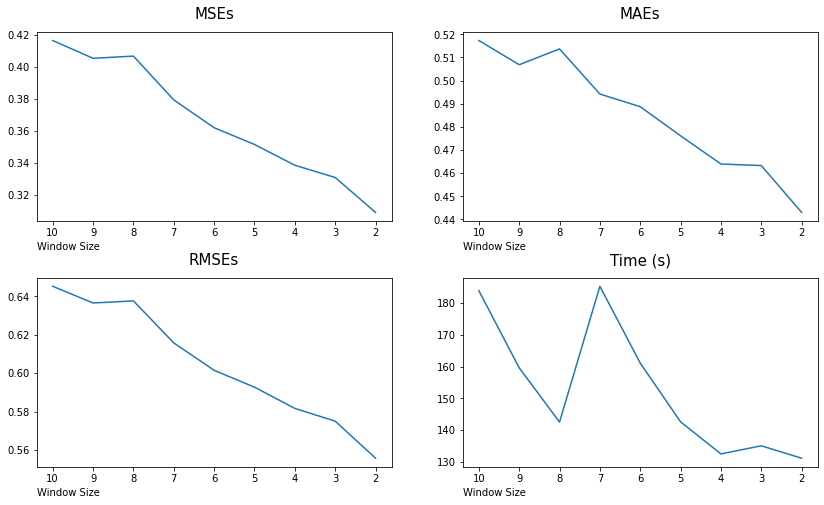

In [15]:
# Convert window sizes to strings
win_sizes_str = [str(n) for n in win_sizes]

# Create a new figure with 2x2 grid
fig = plt.figure(figsize=(14,8))
gs = GridSpec(2,2) 

# Create four subplots in the grid
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,1])

# Plot the MSEs for each window size on ax0 subplot
ax0.plot(df_err_ws.to_numpy()[0,1:])
ax0.set_xticks(np.arange(9))
ax0.set_xticklabels(win_sizes_str)
ax0.set_title("MSEs", {'fontsize': 15}, pad = 13)
ax0.set_xlabel("Window Size", loc="left")

# Plot the RMSEs for each window size on ax1 subplot
ax1.plot(df_err_ws.to_numpy()[1,1:])
ax1.set_xticks(np.arange(9))
ax1.set_xticklabels(win_sizes_str)
ax1.set_title("RMSEs", {'fontsize': 15}, pad = 13)
ax1.set_xlabel("Window Size", loc="left")

# Plot the MAEs for each window size on ax2 subplot
ax2.plot(df_err_ws.to_numpy()[2,1:])
ax2.set_xticks(np.arange(9))
ax2.set_xticklabels(win_sizes_str)
ax2.set_title("MAEs", {'fontsize': 15}, pad = 13)
ax2.set_xlabel("Window Size", loc="left")

# Plot the time taken for each window size on ax3 subplot
ax3.plot(df_err_ws.to_numpy()[4,1:])
ax3.set_xticks(np.arange(9))
ax3.set_xticklabels(win_sizes_str)
ax3.set_title("Time (s)", {'fontsize': 15}, pad = 13)
ax3.set_xlabel("Window Size", loc="left")

# Adjust the spacing between subplots
gs.update(wspace=0.2, hspace=0.3)

# Display the plot
plt.show()


<style>
    p {
        line-height: 1.5;
    }
</style>

<p style="text-align: justify;">
Hence, a vanilla LSTM network is built below once more with 25 epochs for training, validation and testing sets with window size 2. After training the best performing model and forecasting, the KPIs are obtained and they are shown below along with the percentage change (Δ) from the KPIs when window size and number of epochs were set to 7 and 50:
<br/><br/>
&emsp; &emsp; ▪ MSE = 0.316, Δ = −12.0%
<br/>
&emsp; &emsp; ▪ RMSE = 0.563, Δ = −6.01%
<br/>
&emsp; &emsp; ▪ MAE = 0.453, Δ = −6.02%
<br/><br/>
This shows that the changes made resulted in a significant change in the accuracy of the model, not to mention that the running time of the algorithm also decreased.
</p>

In [17]:
window_size = 2

# Converts dataframe into numpy arrays X and y for training.
def df_to_X_y(df, window_size=window_size):
    # Convert dataframe to numpy array for faster processing
    df_as_np = df.to_numpy()
    
    X = []
    y = []
    
    # Iterate through each row and generate input sequence (X) and target value (y)
    for i in range(len(df_as_np) - window_size):
        # Generate input sequence (X) by adding `window_size` number of rows
        # from the dataframe as a single row to the input array X
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        
        # Generate target value (y) by selecting the range of values from column
        # 748 to 935 of the next row and adding it to the target array y
        label = df_as_np[i + window_size][748:935].tolist()
        y.append(label)
        
    # Convert lists to numpy arrays
    return np.array(X), np.array(y)

# Generate X1 and y1 arrays from the dataframe df
X1, y1 = df_to_X_y(df)

# Print the shapes of the arrays
print(f'Window size = {window_size}')
print(f'X shape = {X1.shape}')
print(f'y shape = {y1.shape}')


Window size = 2
X shape = (363, 2, 937)
y shape = (363, 187)


In [18]:
# Divide into train, validate and test
days = np.shape(X1)[0]
lfw = days - 28  # days before the last fout weeks
lew = days - 56  # days before the last eight weeks

# Split into train, validation, and test sets
X1_train, y1_train = X1[:lew], y1[:lew]
X1_val, y1_val = X1[lew:lfw], y1[lew:lfw]
X1_test, y1_test = X1[lfw:], y1[lfw:]

# Print the shapes of the resulting datasets
print('X_train shape = ' + str(X1_train.shape))
print('y_train shape = ' + str(y1_train.shape))
print('X_val shape = ' + str(X1_val.shape))
print('y_val shape = ' + str(y1_val.shape))
print('X_test shape = ' + str(X1_test.shape))
print('y_test shape = ' + str(y1_test.shape))

X_train shape = (307, 2, 937)
y_train shape = (307, 187)
X_val shape = (28, 2, 937)
y_val shape = (28, 187)
X_test shape = (28, 2, 937)
y_test shape = (28, 187)


In [19]:
# Standardization

# Initialize empty arrays for means and standard deviations of each feature
ssh_training_mean = np.empty(187, dtype=float)
ssh_training_std = np.empty(187, dtype=float)
stress_training_mean = np.empty(187, dtype=float)
stress_training_std = np.empty(187, dtype=float)
east_training_mean = np.empty(187, dtype=float)
east_training_std = np.empty(187, dtype=float)
north_training_mean = np.empty(187, dtype=float)
north_training_std = np.empty(187, dtype=float)
temp_training_mean = np.empty(187, dtype=float)
temp_training_std = np.empty(187, dtype=float)

# Compute mean and standard deviation of each feature for training data
for i in range(187):
    ssh_training_mean[i] = np.mean(X1_train[:, :, i+4*187])
    ssh_training_std[i] = np.std(X1_train[:, :, i+4*187])
    stress_training_mean[i] = np.mean(X1_train[:, :, i+3*187])
    stress_training_std[i] = np.std(X1_train[:, :, i+3*187])
    east_training_mean[i] = np.mean(X1_train[:, :, i+2*187])
    east_training_std[i] = np.std(X1_train[:, :, i+2*187])
    north_training_mean[i] = np.mean(X1_train[:, :, i+187])
    north_training_std[i] = np.std(X1_train[:, :, i+187])
    temp_training_mean[i] = np.mean(X1_train[:, :, i])
    temp_training_std[i] = np.std(X1_train[:, :, i])

# Standardize the features of X and y by subtracting the mean and dividing by the standard deviation.
def preprocess(X, y):
  for i in range(187):
    # Standardize each feature of X for each sample
    X[:, :, i+4*187] = (X[:, :, i+4*187] - ssh_training_mean[i]) / ssh_training_std[i]
    X[:, :, i+3*187] = (X[:, :, i+3*187] - stress_training_mean[i]) / stress_training_std[i]
    X[:, :, i+2*187] = (X[:, :, i+2*187] - east_training_mean[i]) / east_training_std[i]
    X[:, :, i+187] = (X[:, :, i+187] - north_training_mean[i]) / north_training_std[i]
    X[:, :, i] = (X[:, :, i] - temp_training_mean[i]) / temp_training_std[i]

    # Standardize each sample of y
    y[:, i] = (y[:, i] - ssh_training_mean[i]) / ssh_training_std[i]

# Standardize the features and labels for training, validation, and testing data
preprocess(X1_train, y1_train)
preprocess(X1_val, y1_val)
preprocess(X1_test, y1_test)

**Vanilla LSTM**

In [19]:
# Define the model
vlstm_model = Sequential()
vlstm_model.add(InputLayer((window_size, 937)))
vlstm_model.add(LSTM(640))
vlstm_model.add(Dense(320, activation='relu'))
vlstm_model.add(Dense(187, activation='linear'))

# Define the checkpoint to save the best model during training
cp1 = ModelCheckpoint('vlstm_model/', save_best_only=True)

# Compile the model
vlstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

# Train the model with validation data and checkpoint
vlstm_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp1])

# Load the best model
vlstm_model = load_model('vlstm_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8431 - root_mean_squared_error: 0.9182

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 9s 689ms/step - loss: 0.8431 - root_mean_squared_error: 0.9182 - val_loss: 0.3857 - val_root_mean_squared_error: 0.6211
Epoch 2/25
10/10 [==============================] - 1s 76ms/step - loss: 0.5910 - root_mean_squared_error: 0.7687 - val_loss: 0.4591 - val_root_mean_squared_error: 0.6776
Epoch 3/25
10/10 [==============================] - 1s 72ms/step - loss: 0.4413 - root_mean_squared_error: 0.6643 - val_loss: 0.4987 - val_root_mean_squared_error: 0.7062
Epoch 4/25
10/10 [==============================] - 1s 69ms/step - loss: 0.3312 - root_mean_squared_error: 0.5755 - val_loss: 0.4891 - val_root_mean_squared_error: 0.6993
Epoch 5/25
10/10 [==============================] - 1s 71ms/step - loss: 0.2514 - root_mean_squared_error: 0.5014 - val_loss: 0.4666 - val_root_mean_squared_error: 0.6831
Epoch 6/25
10/10 [==============================] - 1s 66ms/step - loss: 0.1989 - root_mean_squared_error: 0.4460 - val_loss: 0.4266 - val_root_mean_square

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 577ms/step - loss: 0.1409 - root_mean_squared_error: 0.3754 - val_loss: 0.3643 - val_root_mean_squared_error: 0.6036
Epoch 9/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.1235 - root_mean_squared_error: 0.3514

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 645ms/step - loss: 0.1239 - root_mean_squared_error: 0.3520 - val_loss: 0.3416 - val_root_mean_squared_error: 0.5844
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.1098 - root_mean_squared_error: 0.3314

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 588ms/step - loss: 0.1098 - root_mean_squared_error: 0.3314 - val_loss: 0.3250 - val_root_mean_squared_error: 0.5701
Epoch 11/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0981 - root_mean_squared_error: 0.3132

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 626ms/step - loss: 0.0977 - root_mean_squared_error: 0.3125 - val_loss: 0.3148 - val_root_mean_squared_error: 0.5611
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0877 - root_mean_squared_error: 0.2961

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 593ms/step - loss: 0.0877 - root_mean_squared_error: 0.2961 - val_loss: 0.3092 - val_root_mean_squared_error: 0.5560
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0792 - root_mean_squared_error: 0.2814

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 623ms/step - loss: 0.0792 - root_mean_squared_error: 0.2814 - val_loss: 0.3037 - val_root_mean_squared_error: 0.5511
Epoch 14/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0723 - root_mean_squared_error: 0.2688

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 610ms/step - loss: 0.0721 - root_mean_squared_error: 0.2684 - val_loss: 0.2997 - val_root_mean_squared_error: 0.5474
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0657 - root_mean_squared_error: 0.2564

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 608ms/step - loss: 0.0657 - root_mean_squared_error: 0.2564 - val_loss: 0.2981 - val_root_mean_squared_error: 0.5459
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0604 - root_mean_squared_error: 0.2457

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 620ms/step - loss: 0.0604 - root_mean_squared_error: 0.2457 - val_loss: 0.2945 - val_root_mean_squared_error: 0.5427
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0561 - root_mean_squared_error: 0.2368

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 681ms/step - loss: 0.0561 - root_mean_squared_error: 0.2368 - val_loss: 0.2918 - val_root_mean_squared_error: 0.5402
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0521 - root_mean_squared_error: 0.2282

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 634ms/step - loss: 0.0521 - root_mean_squared_error: 0.2282 - val_loss: 0.2908 - val_root_mean_squared_error: 0.5392
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0488 - root_mean_squared_error: 0.2208

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 593ms/step - loss: 0.0488 - root_mean_squared_error: 0.2208 - val_loss: 0.2875 - val_root_mean_squared_error: 0.5362
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0456 - root_mean_squared_error: 0.2136

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 614ms/step - loss: 0.0456 - root_mean_squared_error: 0.2136 - val_loss: 0.2862 - val_root_mean_squared_error: 0.5350
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0430 - root_mean_squared_error: 0.2074

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 551ms/step - loss: 0.0430 - root_mean_squared_error: 0.2074 - val_loss: 0.2837 - val_root_mean_squared_error: 0.5327
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0407 - root_mean_squared_error: 0.2018

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 620ms/step - loss: 0.0407 - root_mean_squared_error: 0.2018 - val_loss: 0.2806 - val_root_mean_squared_error: 0.5297
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0385 - root_mean_squared_error: 0.1961

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 798ms/step - loss: 0.0385 - root_mean_squared_error: 0.1961 - val_loss: 0.2788 - val_root_mean_squared_error: 0.5280
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0365 - root_mean_squared_error: 0.1911

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 8s 891ms/step - loss: 0.0365 - root_mean_squared_error: 0.1911 - val_loss: 0.2736 - val_root_mean_squared_error: 0.5231
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0345 - root_mean_squared_error: 0.1858

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 8s 826ms/step - loss: 0.0345 - root_mean_squared_error: 0.1858 - val_loss: 0.2724 - val_root_mean_squared_error: 0.5219


MSE =  0.30492682214669425
RMSE =  0.5522017947695337
MAE =  0.4451752894511053


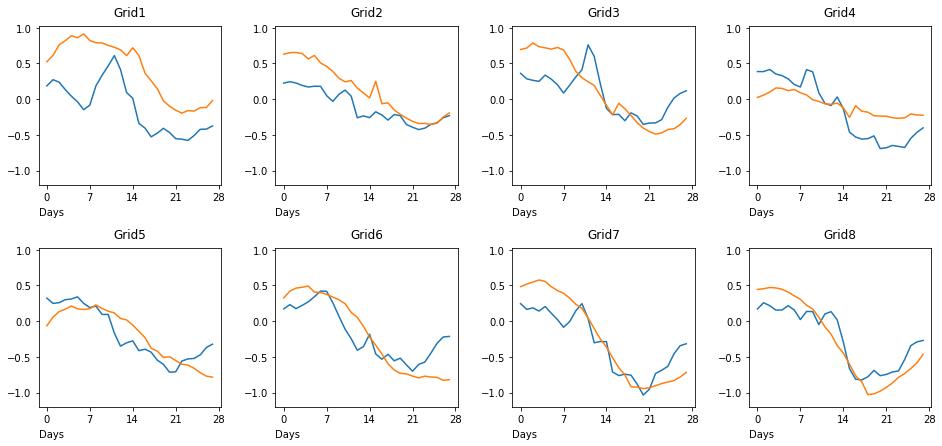

In [20]:
# Best performing Vanilla LSTM with window size = 2 and 25 epochs
plot_predictions(vlstm_model, X1_test, y1_test)

<style>
    p {
        line-height: 1.5;
    }
</style>

<p style="font-size:18px;"> &emsp; &emsp; &emsp; &emsp; <em>4.3.2. Bidirectional and Stacked</em></p>

<p style="text-align: justify;">
Two more LSTM networks are now built, a bidirectional LSTM and a stacked LSTM, with a similar structure to the above vanilla LSTM network. Both networks start with a sequential model followed by an input layer of shape (2, 937). The first network has two bidirectional LSTM layers and the second has two basic LSTM layers. Each network is capped off with two Dense layers, the first with ReLU activation and the last with linear activation. An additional LSTM network that is both bidirectional and stacked is also built. After running the three networks for 25 epochs, the best performing models are saved, to be compared later with the best performing models from all remaining neural networks.
</p>

**Bidirectional LSTM**

In [44]:
# Define the model
bilstm_model = Sequential()
bilstm_model.add(InputLayer((window_size, 937)))
bilstm_model.add(Bidirectional(LSTM(640, return_sequences=True)))
bilstm_model.add(Bidirectional(LSTM(640)))
bilstm_model.add(Dense(640, activation='relu'))
bilstm_model.add(Dense(320, activation='relu'))
bilstm_model.add(Dense(187, activation='linear'))

# Define the checkpoint to save the best model during training
cp2 = ModelCheckpoint('bilstm_model/', save_best_only=True)

# Compile the model
bilstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

# Fit the model with validation data and checkpoint
bilstm_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp2])

# Load the best saved model
bilstm_model = load_model('bilstm_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8914 - root_mean_squared_error: 0.9441

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 73s 7s/step - loss: 0.8914 - root_mean_squared_error: 0.9441 - val_loss: 0.3665 - val_root_mean_squared_error: 0.6054
Epoch 2/25
10/10 [==============================] - 17s 2s/step - loss: 0.6438 - root_mean_squared_error: 0.8024 - val_loss: 0.5012 - val_root_mean_squared_error: 0.7079
Epoch 3/25
10/10 [==============================] - 21s 2s/step - loss: 0.4631 - root_mean_squared_error: 0.6805 - val_loss: 0.4774 - val_root_mean_squared_error: 0.6910
Epoch 4/25
10/10 [==============================] - 15s 1s/step - loss: 0.3311 - root_mean_squared_error: 0.5754 - val_loss: 0.3909 - val_root_mean_squared_error: 0.6252
Epoch 5/25
10/10 [==============================] - ETA: 0s - loss: 0.2438 - root_mean_squared_error: 0.4938

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 37s 4s/step - loss: 0.2438 - root_mean_squared_error: 0.4938 - val_loss: 0.3207 - val_root_mean_squared_error: 0.5663
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.1788 - root_mean_squared_error: 0.4228

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 40s 4s/step - loss: 0.1788 - root_mean_squared_error: 0.4228 - val_loss: 0.2874 - val_root_mean_squared_error: 0.5361
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.1422 - root_mean_squared_error: 0.3770

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 36s 4s/step - loss: 0.1422 - root_mean_squared_error: 0.3770 - val_loss: 0.2753 - val_root_mean_squared_error: 0.5247
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.1199 - root_mean_squared_error: 0.3463

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 42s 4s/step - loss: 0.1199 - root_mean_squared_error: 0.3463 - val_loss: 0.2730 - val_root_mean_squared_error: 0.5225
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.1041 - root_mean_squared_error: 0.3226

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 37s 4s/step - loss: 0.1041 - root_mean_squared_error: 0.3226 - val_loss: 0.2705 - val_root_mean_squared_error: 0.5201
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.0907 - root_mean_squared_error: 0.3012

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 37s 4s/step - loss: 0.0907 - root_mean_squared_error: 0.3012 - val_loss: 0.2691 - val_root_mean_squared_error: 0.5187
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0794 - root_mean_squared_error: 0.2818

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 40s 4s/step - loss: 0.0794 - root_mean_squared_error: 0.2818 - val_loss: 0.2679 - val_root_mean_squared_error: 0.5176
Epoch 12/25
10/10 [==============================] - 15s 1s/step - loss: 0.0706 - root_mean_squared_error: 0.2657 - val_loss: 0.2687 - val_root_mean_squared_error: 0.5184
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0628 - root_mean_squared_error: 0.2506

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 37s 4s/step - loss: 0.0628 - root_mean_squared_error: 0.2506 - val_loss: 0.2654 - val_root_mean_squared_error: 0.5152
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0566 - root_mean_squared_error: 0.2379

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 39s 4s/step - loss: 0.0566 - root_mean_squared_error: 0.2379 - val_loss: 0.2619 - val_root_mean_squared_error: 0.5118
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0520 - root_mean_squared_error: 0.2280

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 37s 4s/step - loss: 0.0520 - root_mean_squared_error: 0.2280 - val_loss: 0.2597 - val_root_mean_squared_error: 0.5097
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0475 - root_mean_squared_error: 0.2180

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 37s 4s/step - loss: 0.0475 - root_mean_squared_error: 0.2180 - val_loss: 0.2563 - val_root_mean_squared_error: 0.5063
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0441 - root_mean_squared_error: 0.2099

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 41s 4s/step - loss: 0.0441 - root_mean_squared_error: 0.2099 - val_loss: 0.2529 - val_root_mean_squared_error: 0.5029
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0408 - root_mean_squared_error: 0.2020

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 37s 4s/step - loss: 0.0408 - root_mean_squared_error: 0.2020 - val_loss: 0.2500 - val_root_mean_squared_error: 0.5000
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0384 - root_mean_squared_error: 0.1960

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 37s 4s/step - loss: 0.0384 - root_mean_squared_error: 0.1960 - val_loss: 0.2499 - val_root_mean_squared_error: 0.4999
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0353 - root_mean_squared_error: 0.1879

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 40s 4s/step - loss: 0.0353 - root_mean_squared_error: 0.1879 - val_loss: 0.2465 - val_root_mean_squared_error: 0.4964
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0329 - root_mean_squared_error: 0.1813

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 37s 4s/step - loss: 0.0329 - root_mean_squared_error: 0.1813 - val_loss: 0.2446 - val_root_mean_squared_error: 0.4946
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0309 - root_mean_squared_error: 0.1758

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 40s 4s/step - loss: 0.0309 - root_mean_squared_error: 0.1758 - val_loss: 0.2415 - val_root_mean_squared_error: 0.4914
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0290 - root_mean_squared_error: 0.1704

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 37s 4s/step - loss: 0.0290 - root_mean_squared_error: 0.1704 - val_loss: 0.2398 - val_root_mean_squared_error: 0.4897
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0274 - root_mean_squared_error: 0.1656

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 36s 4s/step - loss: 0.0274 - root_mean_squared_error: 0.1656 - val_loss: 0.2370 - val_root_mean_squared_error: 0.4868
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0259 - root_mean_squared_error: 0.1609

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 40s 4s/step - loss: 0.0259 - root_mean_squared_error: 0.1609 - val_loss: 0.2339 - val_root_mean_squared_error: 0.4836


**Stacked LSTM**

In [22]:
# Define the model
slstm_model = Sequential()
slstm_model.add(InputLayer((window_size, 937)))
slstm_model.add(LSTM(640, return_sequences=True))
slstm_model.add(LSTM(640))
slstm_model.add(Dense(320, activation='relu'))
slstm_model.add(Dense(187, activation='linear'))

# Define the checkpoint to save the best model during training
cp3 = ModelCheckpoint('slstm_model/', save_best_only=True)

# Compile the model
slstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

# Fit the model with validation data and checkpoint
slstm_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp3])

# Load the best saved model
slstm_model = load_model('slstm_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.9193 - root_mean_squared_error: 0.9588

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 16s 1s/step - loss: 0.9193 - root_mean_squared_error: 0.9588 - val_loss: 0.3258 - val_root_mean_squared_error: 0.5708
Epoch 2/25
10/10 [==============================] - 3s 320ms/step - loss: 0.7204 - root_mean_squared_error: 0.8487 - val_loss: 0.4065 - val_root_mean_squared_error: 0.6376
Epoch 3/25
10/10 [==============================] - 3s 310ms/step - loss: 0.5150 - root_mean_squared_error: 0.7176 - val_loss: 0.5439 - val_root_mean_squared_error: 0.7375
Epoch 4/25
10/10 [==============================] - 3s 310ms/step - loss: 0.3824 - root_mean_squared_error: 0.6184 - val_loss: 0.5434 - val_root_mean_squared_error: 0.7371
Epoch 5/25
10/10 [==============================] - 3s 308ms/step - loss: 0.2857 - root_mean_squared_error: 0.5345 - val_loss: 0.4888 - val_root_mean_squared_error: 0.6991
Epoch 6/25
10/10 [==============================] - 3s 319ms/step - loss: 0.2293 - root_mean_squared_error: 0.4789 - val_loss: 0.3984 - val_root_mean_squ

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.1683 - root_mean_squared_error: 0.4103 - val_loss: 0.3061 - val_root_mean_squared_error: 0.5533
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.1480 - root_mean_squared_error: 0.3847

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 12s 1s/step - loss: 0.1480 - root_mean_squared_error: 0.3847 - val_loss: 0.2882 - val_root_mean_squared_error: 0.5368
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.1323 - root_mean_squared_error: 0.3637

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 12s 1s/step - loss: 0.1323 - root_mean_squared_error: 0.3637 - val_loss: 0.2793 - val_root_mean_squared_error: 0.5285
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.1190 - root_mean_squared_error: 0.3450

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 12s 1s/step - loss: 0.1190 - root_mean_squared_error: 0.3450 - val_loss: 0.2767 - val_root_mean_squared_error: 0.5261
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.1082 - root_mean_squared_error: 0.3289

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.1082 - root_mean_squared_error: 0.3289 - val_loss: 0.2746 - val_root_mean_squared_error: 0.5240
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0980 - root_mean_squared_error: 0.3131

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 12s 1s/step - loss: 0.0980 - root_mean_squared_error: 0.3131 - val_loss: 0.2721 - val_root_mean_squared_error: 0.5216
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0894 - root_mean_squared_error: 0.2990

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 12s 1s/step - loss: 0.0894 - root_mean_squared_error: 0.2990 - val_loss: 0.2708 - val_root_mean_squared_error: 0.5204
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0816 - root_mean_squared_error: 0.2857

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 12s 1s/step - loss: 0.0816 - root_mean_squared_error: 0.2857 - val_loss: 0.2694 - val_root_mean_squared_error: 0.5191
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0745 - root_mean_squared_error: 0.2729

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 12s 1s/step - loss: 0.0745 - root_mean_squared_error: 0.2729 - val_loss: 0.2673 - val_root_mean_squared_error: 0.5170
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0689 - root_mean_squared_error: 0.2626

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0689 - root_mean_squared_error: 0.2626 - val_loss: 0.2672 - val_root_mean_squared_error: 0.5169
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0639 - root_mean_squared_error: 0.2528

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 12s 1s/step - loss: 0.0639 - root_mean_squared_error: 0.2528 - val_loss: 0.2668 - val_root_mean_squared_error: 0.5165
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0598 - root_mean_squared_error: 0.2445

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0598 - root_mean_squared_error: 0.2445 - val_loss: 0.2636 - val_root_mean_squared_error: 0.5135
Epoch 20/25
10/10 [==============================] - 3s 319ms/step - loss: 0.0563 - root_mean_squared_error: 0.2372 - val_loss: 0.2641 - val_root_mean_squared_error: 0.5139
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0532 - root_mean_squared_error: 0.2306

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 17s 2s/step - loss: 0.0532 - root_mean_squared_error: 0.2306 - val_loss: 0.2620 - val_root_mean_squared_error: 0.5119
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0501 - root_mean_squared_error: 0.2239

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 16s 2s/step - loss: 0.0501 - root_mean_squared_error: 0.2239 - val_loss: 0.2591 - val_root_mean_squared_error: 0.5090
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0475 - root_mean_squared_error: 0.2179

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 16s 2s/step - loss: 0.0475 - root_mean_squared_error: 0.2179 - val_loss: 0.2588 - val_root_mean_squared_error: 0.5087
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0452 - root_mean_squared_error: 0.2125

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 14s 2s/step - loss: 0.0452 - root_mean_squared_error: 0.2125 - val_loss: 0.2543 - val_root_mean_squared_error: 0.5043
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0430 - root_mean_squared_error: 0.2073

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 12s 1s/step - loss: 0.0430 - root_mean_squared_error: 0.2073 - val_loss: 0.2528 - val_root_mean_squared_error: 0.5028


**Bidirectional & Stacked LSTM**

In [23]:
# Define the model
bislstm_model = Sequential()
bislstm_model.add(InputLayer((window_size, 937)))
bislstm_model.add(Bidirectional(LSTM(640, return_sequences=True)))
bislstm_model.add(Bidirectional(LSTM(640, return_sequences=True)))
bislstm_model.add(LSTM(640, return_sequences=True))
bislstm_model.add(LSTM(640))
bislstm_model.add(Dense(320, activation='relu'))
bislstm_model.add(Dense(187, activation='linear'))

# Define the checkpoint to save the best model during training
cp4 = ModelCheckpoint('bislstm_model/', save_best_only=True)

# Compile the model
bislstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

# Fit the model with validation data and checkpoint
bislstm_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp4])

# Load the best saved model
bislstm_model = load_model('bislstm_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.9708 - root_mean_squared_error: 0.9853

INFO:tensorflow:Assets written to: bislstm_model\assets


INFO:tensorflow:Assets written to: bislstm_model\assets


10/10 [==============================] - 54s 5s/step - loss: 0.9708 - root_mean_squared_error: 0.9853 - val_loss: 0.3150 - val_root_mean_squared_error: 0.5612
Epoch 2/25
10/10 [==============================] - 12s 1s/step - loss: 0.8687 - root_mean_squared_error: 0.9321 - val_loss: 0.3901 - val_root_mean_squared_error: 0.6246
Epoch 3/25
10/10 [==============================] - 12s 1s/step - loss: 0.6194 - root_mean_squared_error: 0.7870 - val_loss: 0.8097 - val_root_mean_squared_error: 0.8998
Epoch 4/25
10/10 [==============================] - 12s 1s/step - loss: 0.4450 - root_mean_squared_error: 0.6671 - val_loss: 0.6424 - val_root_mean_squared_error: 0.8015
Epoch 5/25
10/10 [==============================] - 12s 1s/step - loss: 0.3256 - root_mean_squared_error: 0.5706 - val_loss: 0.3887 - val_root_mean_squared_error: 0.6235
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.2586 - root_mean_squared_error: 0.5085

INFO:tensorflow:Assets written to: bislstm_model\assets


INFO:tensorflow:Assets written to: bislstm_model\assets


10/10 [==============================] - 45s 5s/step - loss: 0.2586 - root_mean_squared_error: 0.5085 - val_loss: 0.2906 - val_root_mean_squared_error: 0.5391
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.2238 - root_mean_squared_error: 0.4731

INFO:tensorflow:Assets written to: bislstm_model\assets


INFO:tensorflow:Assets written to: bislstm_model\assets


10/10 [==============================] - 45s 5s/step - loss: 0.2238 - root_mean_squared_error: 0.4731 - val_loss: 0.2617 - val_root_mean_squared_error: 0.5115
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.1995 - root_mean_squared_error: 0.4467

INFO:tensorflow:Assets written to: bislstm_model\assets


INFO:tensorflow:Assets written to: bislstm_model\assets


10/10 [==============================] - 45s 5s/step - loss: 0.1995 - root_mean_squared_error: 0.4467 - val_loss: 0.2588 - val_root_mean_squared_error: 0.5087
Epoch 9/25
10/10 [==============================] - 13s 1s/step - loss: 0.1856 - root_mean_squared_error: 0.4308 - val_loss: 0.2639 - val_root_mean_squared_error: 0.5137
Epoch 10/25
10/10 [==============================] - 13s 1s/step - loss: 0.1774 - root_mean_squared_error: 0.4212 - val_loss: 0.2683 - val_root_mean_squared_error: 0.5180
Epoch 11/25
10/10 [==============================] - 13s 1s/step - loss: 0.1708 - root_mean_squared_error: 0.4133 - val_loss: 0.2708 - val_root_mean_squared_error: 0.5204
Epoch 12/25
10/10 [==============================] - 13s 1s/step - loss: 0.1639 - root_mean_squared_error: 0.4049 - val_loss: 0.2734 - val_root_mean_squared_error: 0.5229
Epoch 13/25
10/10 [==============================] - 13s 1s/step - loss: 0.1553 - root_mean_squared_error: 0.3941 - val_loss: 0.2760 - val_root_mean_squared_e

<style>
    p {
        line-height: 1.5;
    }
</style>

<p style="font-size:22px;"> &emsp; &emsp; 4.4. GRU (Vanilla, Bidirectional, Stacked)</p>

<p style="text-align: justify;">
Instead of using input, forget and output gates like in LSTMs, GRUs have an update gate and reset gate. The update gate decides how much information to pass on to the subsequent state, while the reset gate determines the significance of the previous cell state by filtering out some of the information. GRUs have an advantage over LSTMs in that they require lower memory consumption, resulting in faster execution due to fewer training parameters. To compare the performance of GRUs with LSTMs, vanilla, bidirectional, stacked, and both bidirectional and stacked GRU networks need to be built. Each type of GRU network had an identical structure to its LSTM counterpart, except that the LSTM layers were replaced with GRU layers.
</p>

**Vanilla GRU**

In [24]:
# Define the model
gru_model = Sequential()
gru_model.add(InputLayer((window_size, 937)))
gru_model.add(GRU(640))
gru_model.add(Dense(320, activation='relu'))
gru_model.add(Dense(187, activation='linear'))

# Define the checkpoint to save the best model during training
cp5 = ModelCheckpoint('gru_model/', save_best_only=True)

# Compile the model
gru_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

# Fit the model with validation data and checkpoint
gru_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp5])

# Load the best saved model
gru_model = load_model('gru_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8577 - root_mean_squared_error: 0.9261

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 9s 685ms/step - loss: 0.8577 - root_mean_squared_error: 0.9261 - val_loss: 0.4574 - val_root_mean_squared_error: 0.6763
Epoch 2/25
10/10 [==============================] - 2s 217ms/step - loss: 0.5601 - root_mean_squared_error: 0.7484 - val_loss: 0.5236 - val_root_mean_squared_error: 0.7236
Epoch 3/25
10/10 [==============================] - 2s 207ms/step - loss: 0.3985 - root_mean_squared_error: 0.6312 - val_loss: 0.5286 - val_root_mean_squared_error: 0.7271
Epoch 4/25
10/10 [==============================] - 2s 191ms/step - loss: 0.2900 - root_mean_squared_error: 0.5385 - val_loss: 0.4988 - val_root_mean_squared_error: 0.7063
Epoch 5/25
10/10 [==============================] - ETA: 0s - loss: 0.2204 - root_mean_squared_error: 0.4695

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 6s 601ms/step - loss: 0.2204 - root_mean_squared_error: 0.4695 - val_loss: 0.4422 - val_root_mean_squared_error: 0.6650
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.1759 - root_mean_squared_error: 0.4194

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 6s 599ms/step - loss: 0.1759 - root_mean_squared_error: 0.4194 - val_loss: 0.3895 - val_root_mean_squared_error: 0.6241
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.1476 - root_mean_squared_error: 0.3842

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 6s 621ms/step - loss: 0.1476 - root_mean_squared_error: 0.3842 - val_loss: 0.3390 - val_root_mean_squared_error: 0.5822
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.1295 - root_mean_squared_error: 0.3599

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 6s 614ms/step - loss: 0.1295 - root_mean_squared_error: 0.3599 - val_loss: 0.3052 - val_root_mean_squared_error: 0.5525
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.1156 - root_mean_squared_error: 0.3400

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 7s 739ms/step - loss: 0.1156 - root_mean_squared_error: 0.3400 - val_loss: 0.2843 - val_root_mean_squared_error: 0.5332
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.1036 - root_mean_squared_error: 0.3219

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 6s 617ms/step - loss: 0.1036 - root_mean_squared_error: 0.3219 - val_loss: 0.2704 - val_root_mean_squared_error: 0.5200
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0933 - root_mean_squared_error: 0.3055

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 6s 631ms/step - loss: 0.0933 - root_mean_squared_error: 0.3055 - val_loss: 0.2637 - val_root_mean_squared_error: 0.5135
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0847 - root_mean_squared_error: 0.2910

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 6s 600ms/step - loss: 0.0847 - root_mean_squared_error: 0.2910 - val_loss: 0.2567 - val_root_mean_squared_error: 0.5066
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0774 - root_mean_squared_error: 0.2783

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 6s 614ms/step - loss: 0.0774 - root_mean_squared_error: 0.2783 - val_loss: 0.2515 - val_root_mean_squared_error: 0.5015
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0713 - root_mean_squared_error: 0.2669

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 6s 597ms/step - loss: 0.0713 - root_mean_squared_error: 0.2669 - val_loss: 0.2453 - val_root_mean_squared_error: 0.4952
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0655 - root_mean_squared_error: 0.2559

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 6s 628ms/step - loss: 0.0655 - root_mean_squared_error: 0.2559 - val_loss: 0.2390 - val_root_mean_squared_error: 0.4889
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0610 - root_mean_squared_error: 0.2469

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 7s 755ms/step - loss: 0.0610 - root_mean_squared_error: 0.2469 - val_loss: 0.2358 - val_root_mean_squared_error: 0.4856
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0568 - root_mean_squared_error: 0.2384

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 6s 616ms/step - loss: 0.0568 - root_mean_squared_error: 0.2384 - val_loss: 0.2307 - val_root_mean_squared_error: 0.4803
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0535 - root_mean_squared_error: 0.2312

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 6s 617ms/step - loss: 0.0535 - root_mean_squared_error: 0.2312 - val_loss: 0.2269 - val_root_mean_squared_error: 0.4763
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0501 - root_mean_squared_error: 0.2238

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 6s 610ms/step - loss: 0.0501 - root_mean_squared_error: 0.2238 - val_loss: 0.2234 - val_root_mean_squared_error: 0.4727
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0474 - root_mean_squared_error: 0.2176

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 6s 611ms/step - loss: 0.0474 - root_mean_squared_error: 0.2176 - val_loss: 0.2196 - val_root_mean_squared_error: 0.4686
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0450 - root_mean_squared_error: 0.2121

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 6s 615ms/step - loss: 0.0450 - root_mean_squared_error: 0.2121 - val_loss: 0.2170 - val_root_mean_squared_error: 0.4658
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0427 - root_mean_squared_error: 0.2067

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 6s 629ms/step - loss: 0.0427 - root_mean_squared_error: 0.2067 - val_loss: 0.2149 - val_root_mean_squared_error: 0.4636
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0407 - root_mean_squared_error: 0.2018

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 7s 753ms/step - loss: 0.0407 - root_mean_squared_error: 0.2018 - val_loss: 0.2102 - val_root_mean_squared_error: 0.4585
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0388 - root_mean_squared_error: 0.1969

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 6s 633ms/step - loss: 0.0388 - root_mean_squared_error: 0.1969 - val_loss: 0.2069 - val_root_mean_squared_error: 0.4549
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0372 - root_mean_squared_error: 0.1928

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 6s 643ms/step - loss: 0.0372 - root_mean_squared_error: 0.1928 - val_loss: 0.2057 - val_root_mean_squared_error: 0.4535


**Bidirectional GRU**

In [45]:
# Define the model
bigru_model = Sequential()
bigru_model.add(InputLayer((window_size, 937)))
bigru_model.add(Bidirectional(GRU(640, return_sequences=True)))
bigru_model.add(Bidirectional(GRU(640)))
bigru_model.add(Dense(640, activation='relu'))
bigru_model.add(Dense(320, activation='relu'))
bigru_model.add(Dense(187, activation='linear'))

# Define the checkpoint to save the best model during training
cp6 = ModelCheckpoint('bigru_model/', save_best_only=True)

# Compile the model
bigru_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

# Fit the model with validation data and checkpoint
bigru_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp6])

# Load the best saved model
bigru_model = load_model('bigru_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.7866 - root_mean_squared_error: 0.8869

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 45s 4s/step - loss: 0.7866 - root_mean_squared_error: 0.8869 - val_loss: 0.4396 - val_root_mean_squared_error: 0.6630
Epoch 2/25
10/10 [==============================] - 13s 1s/step - loss: 0.5141 - root_mean_squared_error: 0.7170 - val_loss: 0.4612 - val_root_mean_squared_error: 0.6791
Epoch 3/25
10/10 [==============================] - ETA: 0s - loss: 0.3623 - root_mean_squared_error: 0.6019

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 32s 3s/step - loss: 0.3623 - root_mean_squared_error: 0.6019 - val_loss: 0.4050 - val_root_mean_squared_error: 0.6364
Epoch 4/25
10/10 [==============================] - ETA: 0s - loss: 0.2541 - root_mean_squared_error: 0.5040

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 33s 4s/step - loss: 0.2541 - root_mean_squared_error: 0.5040 - val_loss: 0.3115 - val_root_mean_squared_error: 0.5581
Epoch 5/25
10/10 [==============================] - ETA: 0s - loss: 0.1803 - root_mean_squared_error: 0.4246

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 36s 4s/step - loss: 0.1803 - root_mean_squared_error: 0.4246 - val_loss: 0.2643 - val_root_mean_squared_error: 0.5141
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.1376 - root_mean_squared_error: 0.3710

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 32s 3s/step - loss: 0.1376 - root_mean_squared_error: 0.3710 - val_loss: 0.2515 - val_root_mean_squared_error: 0.5015
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.1137 - root_mean_squared_error: 0.3372

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 33s 4s/step - loss: 0.1137 - root_mean_squared_error: 0.3372 - val_loss: 0.2480 - val_root_mean_squared_error: 0.4980
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.0973 - root_mean_squared_error: 0.3120

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 35s 4s/step - loss: 0.0973 - root_mean_squared_error: 0.3120 - val_loss: 0.2472 - val_root_mean_squared_error: 0.4972
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.0847 - root_mean_squared_error: 0.2911

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 32s 3s/step - loss: 0.0847 - root_mean_squared_error: 0.2911 - val_loss: 0.2457 - val_root_mean_squared_error: 0.4957
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.0738 - root_mean_squared_error: 0.2716

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 33s 3s/step - loss: 0.0738 - root_mean_squared_error: 0.2716 - val_loss: 0.2411 - val_root_mean_squared_error: 0.4910
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0645 - root_mean_squared_error: 0.2540

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 49s 5s/step - loss: 0.0645 - root_mean_squared_error: 0.2540 - val_loss: 0.2333 - val_root_mean_squared_error: 0.4830
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0576 - root_mean_squared_error: 0.2400

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 35s 4s/step - loss: 0.0576 - root_mean_squared_error: 0.2400 - val_loss: 0.2309 - val_root_mean_squared_error: 0.4805
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0517 - root_mean_squared_error: 0.2275

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 32s 3s/step - loss: 0.0517 - root_mean_squared_error: 0.2275 - val_loss: 0.2243 - val_root_mean_squared_error: 0.4736
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0469 - root_mean_squared_error: 0.2165

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 35s 4s/step - loss: 0.0469 - root_mean_squared_error: 0.2165 - val_loss: 0.2192 - val_root_mean_squared_error: 0.4682
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0425 - root_mean_squared_error: 0.2061

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 32s 3s/step - loss: 0.0425 - root_mean_squared_error: 0.2061 - val_loss: 0.2153 - val_root_mean_squared_error: 0.4640
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0390 - root_mean_squared_error: 0.1976

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 32s 3s/step - loss: 0.0390 - root_mean_squared_error: 0.1976 - val_loss: 0.2099 - val_root_mean_squared_error: 0.4582
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0362 - root_mean_squared_error: 0.1902

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 35s 4s/step - loss: 0.0362 - root_mean_squared_error: 0.1902 - val_loss: 0.2057 - val_root_mean_squared_error: 0.4535
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0339 - root_mean_squared_error: 0.1841

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 32s 3s/step - loss: 0.0339 - root_mean_squared_error: 0.1841 - val_loss: 0.2021 - val_root_mean_squared_error: 0.4496
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0316 - root_mean_squared_error: 0.1777

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 32s 3s/step - loss: 0.0316 - root_mean_squared_error: 0.1777 - val_loss: 0.1983 - val_root_mean_squared_error: 0.4453
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0294 - root_mean_squared_error: 0.1714

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 34s 4s/step - loss: 0.0294 - root_mean_squared_error: 0.1714 - val_loss: 0.1956 - val_root_mean_squared_error: 0.4423
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0275 - root_mean_squared_error: 0.1657

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 33s 4s/step - loss: 0.0275 - root_mean_squared_error: 0.1657 - val_loss: 0.1907 - val_root_mean_squared_error: 0.4367
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0258 - root_mean_squared_error: 0.1606

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 32s 3s/step - loss: 0.0258 - root_mean_squared_error: 0.1606 - val_loss: 0.1877 - val_root_mean_squared_error: 0.4332
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0244 - root_mean_squared_error: 0.1563

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 35s 4s/step - loss: 0.0244 - root_mean_squared_error: 0.1563 - val_loss: 0.1834 - val_root_mean_squared_error: 0.4283
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0230 - root_mean_squared_error: 0.1516

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 32s 3s/step - loss: 0.0230 - root_mean_squared_error: 0.1516 - val_loss: 0.1809 - val_root_mean_squared_error: 0.4254
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0217 - root_mean_squared_error: 0.1475

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 32s 3s/step - loss: 0.0217 - root_mean_squared_error: 0.1475 - val_loss: 0.1782 - val_root_mean_squared_error: 0.4221


**Stacked GRU**

In [26]:
# Define the model
sgru_model = Sequential()
sgru_model.add(InputLayer((window_size, 937)))
sgru_model.add(GRU(640, return_sequences=True))
sgru_model.add(GRU(640))
sgru_model.add(Dense(320, activation='relu'))
sgru_model.add(Dense(187, activation='linear'))

# Define the checkpoint to save the best model during training
cp7 = ModelCheckpoint('sgru_model/', save_best_only=True)

# Compile the model
sgru_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

# Fit the model with validation data and checkpoint
sgru_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp7])

# Load the best saved model
sgru_model = load_model('sgru_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8555 - root_mean_squared_error: 0.9250

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 15s 1s/step - loss: 0.8555 - root_mean_squared_error: 0.9250 - val_loss: 0.3854 - val_root_mean_squared_error: 0.6208
Epoch 2/25
10/10 [==============================] - 4s 358ms/step - loss: 0.5746 - root_mean_squared_error: 0.7580 - val_loss: 0.5126 - val_root_mean_squared_error: 0.7160
Epoch 3/25
10/10 [==============================] - 3s 348ms/step - loss: 0.4105 - root_mean_squared_error: 0.6407 - val_loss: 0.5701 - val_root_mean_squared_error: 0.7551
Epoch 4/25
10/10 [==============================] - 3s 345ms/step - loss: 0.2946 - root_mean_squared_error: 0.5428 - val_loss: 0.4951 - val_root_mean_squared_error: 0.7036
Epoch 5/25
10/10 [==============================] - ETA: 0s - loss: 0.2198 - root_mean_squared_error: 0.4689

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.2198 - root_mean_squared_error: 0.4689 - val_loss: 0.3808 - val_root_mean_squared_error: 0.6171
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.1735 - root_mean_squared_error: 0.4165

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.1735 - root_mean_squared_error: 0.4165 - val_loss: 0.3001 - val_root_mean_squared_error: 0.5478
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.1437 - root_mean_squared_error: 0.3791

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 12s 1s/step - loss: 0.1437 - root_mean_squared_error: 0.3791 - val_loss: 0.2689 - val_root_mean_squared_error: 0.5186
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.1241 - root_mean_squared_error: 0.3522

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.1241 - root_mean_squared_error: 0.3522 - val_loss: 0.2473 - val_root_mean_squared_error: 0.4973
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.1096 - root_mean_squared_error: 0.3311

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.1096 - root_mean_squared_error: 0.3311 - val_loss: 0.2406 - val_root_mean_squared_error: 0.4905
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.0978 - root_mean_squared_error: 0.3127

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0978 - root_mean_squared_error: 0.3127 - val_loss: 0.2398 - val_root_mean_squared_error: 0.4897
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0884 - root_mean_squared_error: 0.2974

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0884 - root_mean_squared_error: 0.2974 - val_loss: 0.2384 - val_root_mean_squared_error: 0.4883
Epoch 12/25
10/10 [==============================] - 4s 395ms/step - loss: 0.0802 - root_mean_squared_error: 0.2831 - val_loss: 0.2394 - val_root_mean_squared_error: 0.4893
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0733 - root_mean_squared_error: 0.2708

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 12s 1s/step - loss: 0.0733 - root_mean_squared_error: 0.2708 - val_loss: 0.2375 - val_root_mean_squared_error: 0.4873
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0675 - root_mean_squared_error: 0.2598

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0675 - root_mean_squared_error: 0.2598 - val_loss: 0.2369 - val_root_mean_squared_error: 0.4867
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0625 - root_mean_squared_error: 0.2499

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0625 - root_mean_squared_error: 0.2499 - val_loss: 0.2309 - val_root_mean_squared_error: 0.4805
Epoch 16/25
10/10 [==============================] - 4s 391ms/step - loss: 0.0574 - root_mean_squared_error: 0.2395 - val_loss: 0.2328 - val_root_mean_squared_error: 0.4825
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0536 - root_mean_squared_error: 0.2316

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0536 - root_mean_squared_error: 0.2316 - val_loss: 0.2279 - val_root_mean_squared_error: 0.4774
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0502 - root_mean_squared_error: 0.2240

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 13s 1s/step - loss: 0.0502 - root_mean_squared_error: 0.2240 - val_loss: 0.2266 - val_root_mean_squared_error: 0.4761
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0470 - root_mean_squared_error: 0.2168

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 10s 1s/step - loss: 0.0470 - root_mean_squared_error: 0.2168 - val_loss: 0.2227 - val_root_mean_squared_error: 0.4720
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0444 - root_mean_squared_error: 0.2108

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0444 - root_mean_squared_error: 0.2108 - val_loss: 0.2190 - val_root_mean_squared_error: 0.4680
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0422 - root_mean_squared_error: 0.2054

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0422 - root_mean_squared_error: 0.2054 - val_loss: 0.2171 - val_root_mean_squared_error: 0.4660
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0399 - root_mean_squared_error: 0.1997

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0399 - root_mean_squared_error: 0.1997 - val_loss: 0.2133 - val_root_mean_squared_error: 0.4618
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0378 - root_mean_squared_error: 0.1945

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 13s 1s/step - loss: 0.0378 - root_mean_squared_error: 0.1945 - val_loss: 0.2084 - val_root_mean_squared_error: 0.4565
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0359 - root_mean_squared_error: 0.1895

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0359 - root_mean_squared_error: 0.1895 - val_loss: 0.2058 - val_root_mean_squared_error: 0.4536
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0342 - root_mean_squared_error: 0.1850

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 11s 1s/step - loss: 0.0342 - root_mean_squared_error: 0.1850 - val_loss: 0.2013 - val_root_mean_squared_error: 0.4486


**Bidirectional & Stacked GRU**

In [27]:
# Define the model
bisgru_model = Sequential()
bisgru_model.add(InputLayer((window_size, 937)))
bisgru_model.add(Bidirectional(GRU(640, return_sequences=True)))
bisgru_model.add(Bidirectional(GRU(640, return_sequences=True)))
bisgru_model.add(GRU(640, return_sequences=True))
bisgru_model.add(GRU(640))
bisgru_model.add(Dense(320, activation='relu'))
bisgru_model.add(Dense(187, activation='linear'))

# Define the checkpoint to save the best model during training
cp8 = ModelCheckpoint('bisgru_model/', save_best_only=True)

# Compile the model
bisgru_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

# Fit the model with validation data and checkpoint
bisgru_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp8])

# Load the best saved model
bisgru_model = load_model('bisgru_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8338 - root_mean_squared_error: 0.9131

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 56s 5s/step - loss: 0.8338 - root_mean_squared_error: 0.9131 - val_loss: 0.4025 - val_root_mean_squared_error: 0.6344
Epoch 2/25
10/10 [==============================] - 15s 2s/step - loss: 0.5365 - root_mean_squared_error: 0.7325 - val_loss: 0.6071 - val_root_mean_squared_error: 0.7791
Epoch 3/25
10/10 [==============================] - 15s 1s/step - loss: 0.3652 - root_mean_squared_error: 0.6044 - val_loss: 0.4028 - val_root_mean_squared_error: 0.6347
Epoch 4/25
10/10 [==============================] - ETA: 0s - loss: 0.2717 - root_mean_squared_error: 0.5212

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 42s 4s/step - loss: 0.2717 - root_mean_squared_error: 0.5212 - val_loss: 0.2624 - val_root_mean_squared_error: 0.5122
Epoch 5/25
10/10 [==============================] - ETA: 0s - loss: 0.2089 - root_mean_squared_error: 0.4570

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 44s 5s/step - loss: 0.2089 - root_mean_squared_error: 0.4570 - val_loss: 0.2430 - val_root_mean_squared_error: 0.4929
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.1634 - root_mean_squared_error: 0.4043

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 42s 4s/step - loss: 0.1634 - root_mean_squared_error: 0.4043 - val_loss: 0.2408 - val_root_mean_squared_error: 0.4907
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.1348 - root_mean_squared_error: 0.3671

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 43s 5s/step - loss: 0.1348 - root_mean_squared_error: 0.3671 - val_loss: 0.2401 - val_root_mean_squared_error: 0.4900
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.1144 - root_mean_squared_error: 0.3382

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 42s 5s/step - loss: 0.1144 - root_mean_squared_error: 0.3382 - val_loss: 0.2345 - val_root_mean_squared_error: 0.4842
Epoch 9/25
10/10 [==============================] - 15s 2s/step - loss: 0.1003 - root_mean_squared_error: 0.3166 - val_loss: 0.2378 - val_root_mean_squared_error: 0.4877
Epoch 10/25
10/10 [==============================] - 15s 2s/step - loss: 0.0889 - root_mean_squared_error: 0.2981 - val_loss: 0.2439 - val_root_mean_squared_error: 0.4939
Epoch 11/25
10/10 [==============================] - 15s 2s/step - loss: 0.0803 - root_mean_squared_error: 0.2834 - val_loss: 0.2443 - val_root_mean_squared_error: 0.4943
Epoch 12/25
10/10 [==============================] - 15s 2s/step - loss: 0.0725 - root_mean_squared_error: 0.2693 - val_loss: 0.2472 - val_root_mean_squared_error: 0.4972
Epoch 13/25
10/10 [==============================] - 15s 2s/step - loss: 0.0666 - root_mean_squared_error: 0.2581 - val_loss: 0.2429 - val_root_mean_squared_e

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 42s 5s/step - loss: 0.0502 - root_mean_squared_error: 0.2241 - val_loss: 0.2321 - val_root_mean_squared_error: 0.4818
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0473 - root_mean_squared_error: 0.2176

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 42s 5s/step - loss: 0.0473 - root_mean_squared_error: 0.2176 - val_loss: 0.2272 - val_root_mean_squared_error: 0.4766
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0446 - root_mean_squared_error: 0.2113

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 58s 6s/step - loss: 0.0446 - root_mean_squared_error: 0.2113 - val_loss: 0.2236 - val_root_mean_squared_error: 0.4729
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0425 - root_mean_squared_error: 0.2062

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 46s 5s/step - loss: 0.0425 - root_mean_squared_error: 0.2062 - val_loss: 0.2190 - val_root_mean_squared_error: 0.4680
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0404 - root_mean_squared_error: 0.2009

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 40s 4s/step - loss: 0.0404 - root_mean_squared_error: 0.2009 - val_loss: 0.2130 - val_root_mean_squared_error: 0.4615
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0382 - root_mean_squared_error: 0.1954

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 42s 5s/step - loss: 0.0382 - root_mean_squared_error: 0.1954 - val_loss: 0.2114 - val_root_mean_squared_error: 0.4598
Epoch 23/25
10/10 [==============================] - 15s 2s/step - loss: 0.0361 - root_mean_squared_error: 0.1901 - val_loss: 0.2116 - val_root_mean_squared_error: 0.4600
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0349 - root_mean_squared_error: 0.1868

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 41s 4s/step - loss: 0.0349 - root_mean_squared_error: 0.1868 - val_loss: 0.2040 - val_root_mean_squared_error: 0.4517
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0330 - root_mean_squared_error: 0.1816

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 42s 4s/step - loss: 0.0330 - root_mean_squared_error: 0.1816 - val_loss: 0.2028 - val_root_mean_squared_error: 0.4503


<style>
    p {
        line-height: 1.5;
    }
</style>

<p style="font-size:22px;"> &emsp; &emsp; 4.5. 1-Dimensional CNNs</p>

<p style="text-align: justify;">
1D CNNs consist of a convolutional layer, a pooling layer and a fully-connected layer and operate on one-dimensional sequences. They are commonly used in natural language processing but have been used experimentally for time series modeling. While LSTMs and GRUs are generally considered more appropriate for time series modeling, CNNs are seen as more powerful networks with multiple advantages over RNNs, especially in terms of computational efficiency. However, 1D CNNs have the constraint that the window size needs to be larger than the parameter kernel size, which needs to be at least 2. In this case, two kernel sizes of 2 and 4 need to be tested, and both X and y need to be extracted with window sizes 4 and 6 for the CNNs with respective kernel sizes. Both CNNs start with the creation of a sequential model to which an input layer of shape corresponding to the window size was added, followed by a 1-dimensional CNN layer with ReLU activation and kernel size set to whichever of the two is being tested. After running both networks for 25 epochs, the best performing models is saved for later comparison.
</p>

**Kernel Size = 2**

In [28]:
# window size
window_size2 = 4

# Converts a dataframe to input X and output y arrays with the given window size
def df_to_X_y(df, window_size=window_size2):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][748:935].tolist()
        y.append(label)
    return np.array(X), np.array(y)

X2, y2 = df_to_X_y(df)
print(f"X shape = {X2.shape} and y shape = {y2.shape}")

# Divide into train, validate and test sets
days = np.shape(X2)[0]
lfw = days - 28  # days before the last four weeks
lew = days - 56  # days before the last eight weeks
X2_train, y2_train = X2[:lew], y2[:lew]
X2_val, y2_val = X2[lew:lfw], y2[lew:lfw]
X2_test, y2_test = X2[lfw:], y2[lfw:]

print(f"X_train shape = {X2_train.shape}")
print(f"y_train shape = {y2_train.shape}")
print(f"X_val shape = {X2_val.shape}")
print(f"y_val shape = {y2_val.shape}")
print(f"X_test shape = {X2_test.shape}")
print(f"y_test shape = {y2_test.shape}")

# Standardization
ssh_training_mean = np.empty(187, dtype=float)
ssh_training_std = np.empty(187, dtype=float)
stress_training_mean = np.empty(187, dtype=float)
stress_training_std = np.empty(187, dtype=float)
east_training_mean = np.empty(187, dtype=float)
east_training_std = np.empty(187, dtype=float)
north_training_mean = np.empty(187, dtype=float)
north_training_std = np.empty(187, dtype=float)
temp_training_mean = np.empty(187, dtype=float)
temp_training_std = np.empty(187, dtype=float)

# Calculate means and standard deviations for each column
for i in range(187):
    ssh_training_mean[i] = np.mean(X2_train[:, :, i+4*187])
    ssh_training_std[i] = np.std(X2_train[:, :, i+4*187])
    stress_training_mean[i] = np.mean(X2_train[:, :, i+3*187])
    stress_training_std[i] = np.std(X2_train[:, :, i+3*187])
    east_training_mean[i] = np.mean(X2_train[:, :, i+2*187])
    east_training_std[i] = np.std(X2_train[:, :, i+2*187])
    north_training_mean[i] = np.mean(X2_train[:, :, i+187])
    north_training_std[i] = np.std(X2_train[:, :, i+187])
    temp_training_mean[i] = np.mean(X2_train[:, :, i])
    temp_training_std[i] = np.std(X2_train[:, :, i])

# Standardizes the data by subtracting the mean and dividing by the standard deviation
def preprocess(X, y):
    for i in range(187):
        X[:, :, i + 4 * 187] = (X[:, :, i + 4 * 187] - ssh_training_mean[i]) / ssh_training_std[i]
        X[:, :, i + 3 * 187] = (X[:, :, i + 3 * 187] - stress_training_mean[i]) / stress_training_std[i]
        X[:, :, i + 2 * 187] = (X[:, :, i + 2 * 187] - east_training_mean[i]) / east_training_std[i]
        X[:, :, i + 187] = (X[:, :, i + 187] - north_training_mean[i]) / north_training_std[i]
        X[:, :, i] = (X[:, :, i] - temp_training_mean[i]) / temp_training_std[i]

        y[:, i] = (y[:, i] - ssh_training_mean[i]) / ssh_training_std[i]

# Standardize the train, validation, and test data
preprocess(X2_train, y2_train)
preprocess(X2_val, y2_val)
preprocess(X2_test, y2_test)

X shape = (361, 4, 937) and y shape = (361, 187)
X_train shape = (305, 4, 937)
y_train shape = (305, 187)
X_val shape = (28, 4, 937)
y_val shape = (28, 187)
X_test shape = (28, 4, 937)
y_test shape = (28, 187)


In [46]:
# Define the model
cnn_k2_model = Sequential()
cnn_k2_model.add(InputLayer((window_size2, 937)))
cnn_k2_model.add(Conv1D(640, kernel_size=2, activation='relu'))
cnn_k2_model.add(Flatten())
cnn_k2_model.add(Dense(640, activation='relu'))
cnn_k2_model.add(Dense(320, activation='relu'))
cnn_k2_model.add(Dense(187, activation='linear'))

# Define the checkpoint to save the best model during training
cp10 = ModelCheckpoint('cnn_k2_model/', save_best_only=True)

# Compile the model
cnn_k2_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

# Fit the model with validation data and checkpoint
cnn_k2_model.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=25, callbacks=[cp10])

# Load the best saved model
cnn_k2_model = load_model('cnn_k2_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8895 - root_mean_squared_error: 0.9431INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 3s 250ms/step - loss: 0.8895 - root_mean_squared_error: 0.9431 - val_loss: 0.3916 - val_root_mean_squared_error: 0.6258
Epoch 2/25
10/10 [==============================] - 2s 160ms/step - loss: 0.5377 - root_mean_squared_error: 0.7333 - val_loss: 0.4169 - val_root_mean_squared_error: 0.6457
Epoch 3/25
10/10 [==============================] - 1s 141ms/step - loss: 0.3874 - root_mean_squared_error: 0.6224 - val_loss: 0.4082 - val_root_mean_squared_error: 0.6389
Epoch 4/25
10/10 [==============================] - 1s 139ms/step - loss: 0.2822 - root_mean_squared_error: 0.5312 - val_loss: 0.3981 - val_root_mean_squared_error: 0.6309
Epoch 5/25
10/10 [==============================] - ETA: 0s - loss: 0.2094 - root_mean_squared_error: 0.4576INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 2s 225ms/step - loss: 0.2094 - root_mean_squared_error: 0.4576 - val_loss: 0.3763 - val_root_mean_squared_error: 0.6134
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.1625 - root_mean_squared_error: 0.4031INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 2s 236ms/step - loss: 0.1625 - root_mean_squared_error: 0.4031 - val_loss: 0.3593 - val_root_mean_squared_error: 0.5995
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.1329 - root_mean_squared_error: 0.3645INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 2s 232ms/step - loss: 0.1329 - root_mean_squared_error: 0.3645 - val_loss: 0.3411 - val_root_mean_squared_error: 0.5841
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.1141 - root_mean_squared_error: 0.3378INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 2s 229ms/step - loss: 0.1141 - root_mean_squared_error: 0.3378 - val_loss: 0.3299 - val_root_mean_squared_error: 0.5744
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.1006 - root_mean_squared_error: 0.3172INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 2s 232ms/step - loss: 0.1006 - root_mean_squared_error: 0.3172 - val_loss: 0.3160 - val_root_mean_squared_error: 0.5621
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.0907 - root_mean_squared_error: 0.3012INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 2s 227ms/step - loss: 0.0907 - root_mean_squared_error: 0.3012 - val_loss: 0.3089 - val_root_mean_squared_error: 0.5558
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0829 - root_mean_squared_error: 0.2878INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 2s 226ms/step - loss: 0.0829 - root_mean_squared_error: 0.2878 - val_loss: 0.3017 - val_root_mean_squared_error: 0.5493
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0758 - root_mean_squared_error: 0.2754INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 2s 246ms/step - loss: 0.0758 - root_mean_squared_error: 0.2754 - val_loss: 0.3003 - val_root_mean_squared_error: 0.5480
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0699 - root_mean_squared_error: 0.2645INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 2s 233ms/step - loss: 0.0699 - root_mean_squared_error: 0.2645 - val_loss: 0.2959 - val_root_mean_squared_error: 0.5439
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0649 - root_mean_squared_error: 0.2547INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 2s 229ms/step - loss: 0.0649 - root_mean_squared_error: 0.2547 - val_loss: 0.2927 - val_root_mean_squared_error: 0.5411
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0603 - root_mean_squared_error: 0.2455INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 2s 238ms/step - loss: 0.0603 - root_mean_squared_error: 0.2455 - val_loss: 0.2913 - val_root_mean_squared_error: 0.5397
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0563 - root_mean_squared_error: 0.2374INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 2s 226ms/step - loss: 0.0563 - root_mean_squared_error: 0.2374 - val_loss: 0.2880 - val_root_mean_squared_error: 0.5366
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0525 - root_mean_squared_error: 0.2292INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 2s 239ms/step - loss: 0.0525 - root_mean_squared_error: 0.2292 - val_loss: 0.2832 - val_root_mean_squared_error: 0.5321
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0497 - root_mean_squared_error: 0.2229INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 2s 229ms/step - loss: 0.0497 - root_mean_squared_error: 0.2229 - val_loss: 0.2801 - val_root_mean_squared_error: 0.5293
Epoch 19/25
10/10 [==============================] - 1s 141ms/step - loss: 0.0467 - root_mean_squared_error: 0.2162 - val_loss: 0.2805 - val_root_mean_squared_error: 0.5296
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0440 - root_mean_squared_error: 0.2098INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 2s 228ms/step - loss: 0.0440 - root_mean_squared_error: 0.2098 - val_loss: 0.2747 - val_root_mean_squared_error: 0.5241
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0417 - root_mean_squared_error: 0.2043INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 2s 241ms/step - loss: 0.0417 - root_mean_squared_error: 0.2043 - val_loss: 0.2729 - val_root_mean_squared_error: 0.5224
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0396 - root_mean_squared_error: 0.1989INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 2s 238ms/step - loss: 0.0396 - root_mean_squared_error: 0.1989 - val_loss: 0.2695 - val_root_mean_squared_error: 0.5191
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0377 - root_mean_squared_error: 0.1942INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 2s 236ms/step - loss: 0.0377 - root_mean_squared_error: 0.1942 - val_loss: 0.2682 - val_root_mean_squared_error: 0.5179
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0359 - root_mean_squared_error: 0.1896INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 2s 238ms/step - loss: 0.0359 - root_mean_squared_error: 0.1896 - val_loss: 0.2664 - val_root_mean_squared_error: 0.5162
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0344 - root_mean_squared_error: 0.1854INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 2s 234ms/step - loss: 0.0344 - root_mean_squared_error: 0.1854 - val_loss: 0.2646 - val_root_mean_squared_error: 0.5144


**Kernel Size = 4**

In [30]:
# window size
window_size3 = 6

# Converts a dataframe to input X and output y arrays with the given window size
def df_to_X_y(df, window_size=window_size3):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][748:935].tolist()
        y.append(label)
    return np.array(X), np.array(y)

X3, y3 = df_to_X_y(df)
print(f"X shape = {X2.shape} and y shape = {y2.shape}")

# Divide into train, validate and test sets
days = np.shape(X3)[0]
lfw = days - 28  # days before the last four weeks
lew = days - 56  # days before the last eight weeks
X3_train, y3_train = X3[:lew], y3[:lew]
X3_val, y3_val = X3[lew:lfw], y3[lew:lfw]
X3_test, y3_test = X3[lfw:], y3[lfw:]

print(f"X_train shape = {X3_train.shape}")
print(f"y_train shape = {y3_train.shape}")
print(f"X_val shape = {X3_val.shape}")
print(f"y_val shape = {y3_val.shape}")
print(f"X_test shape = {X3_test.shape}")
print(f"y_test shape = {y3_test.shape}")

# Standardization
ssh_training_mean = np.empty(187, dtype=float)
ssh_training_std = np.empty(187, dtype=float)
stress_training_mean = np.empty(187, dtype=float)
stress_training_std = np.empty(187, dtype=float)
east_training_mean = np.empty(187, dtype=float)
east_training_std = np.empty(187, dtype=float)
north_training_mean = np.empty(187, dtype=float)
north_training_std = np.empty(187, dtype=float)
temp_training_mean = np.empty(187, dtype=float)
temp_training_std = np.empty(187, dtype=float)

# Calculate means and standard deviations for each column
for i in range(187):
    ssh_training_mean[i] = np.mean(X3_train[:, :, i+4*187])
    ssh_training_std[i] = np.std(X3_train[:, :, i+4*187])
    stress_training_mean[i] = np.mean(X3_train[:, :, i+3*187])
    stress_training_std[i] = np.std(X3_train[:, :, i+3*187])
    east_training_mean[i] = np.mean(X3_train[:, :, i+2*187])
    east_training_std[i] = np.std(X3_train[:, :, i+2*187])
    north_training_mean[i] = np.mean(X3_train[:, :, i+187])
    north_training_std[i] = np.std(X3_train[:, :, i+187])
    temp_training_mean[i] = np.mean(X3_train[:, :, i])
    temp_training_std[i] = np.std(X3_train[:, :, i])

# Standardizes the data by subtracting the mean and dividing by the standard deviation
def preprocess(X, y):
    for i in range(187):
        X[:, :, i + 4 * 187] = (X[:, :, i + 4 * 187] - ssh_training_mean[i]) / ssh_training_std[i]
        X[:, :, i + 3 * 187] = (X[:, :, i + 3 * 187] - stress_training_mean[i]) / stress_training_std[i]
        X[:, :, i + 2 * 187] = (X[:, :, i + 2 * 187] - east_training_mean[i]) / east_training_std[i]
        X[:, :, i + 187] = (X[:, :, i + 187] - north_training_mean[i]) / north_training_std[i]
        X[:, :, i] = (X[:, :, i] - temp_training_mean[i]) / temp_training_std[i]

        y[:, i] = (y[:, i] - ssh_training_mean[i]) / ssh_training_std[i]

# Standardize the train, validation, and test data
preprocess(X3_train, y3_train)
preprocess(X3_val, y3_val)
preprocess(X3_test, y3_test)

X shape = (361, 4, 937) and y shape = (361, 187)
X_train shape = (303, 6, 937)
y_train shape = (303, 187)
X_val shape = (28, 6, 937)
y_val shape = (28, 187)
X_test shape = (28, 6, 937)
y_test shape = (28, 187)


In [47]:
# Define the model
cnn_k4_model = Sequential()
cnn_k4_model.add(InputLayer((window_size3, 937)))
cnn_k4_model.add(Conv1D(640, kernel_size=4, activation='relu'))
cnn_k4_model.add(Flatten())
cnn_k4_model.add(Dense(640, activation='relu'))
cnn_k4_model.add(Dense(320, activation='relu'))
cnn_k4_model.add(Dense(187, activation='linear'))

# Define the checkpoint to save the best model during training
cp10 = ModelCheckpoint('cnn_k4_model/', save_best_only=True)

# Compile the model
cnn_k4_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

# Fit the model with validation data and checkpoint
cnn_k4_model.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=25, callbacks=[cp10])

# Load the best saved model
cnn_k4_model = load_model('cnn_k4_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8576 - root_mean_squared_error: 0.9261INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 4s 322ms/step - loss: 0.8576 - root_mean_squared_error: 0.9261 - val_loss: 0.3966 - val_root_mean_squared_error: 0.6298
Epoch 2/25
10/10 [==============================] - 2s 209ms/step - loss: 0.5447 - root_mean_squared_error: 0.7381 - val_loss: 0.4089 - val_root_mean_squared_error: 0.6395
Epoch 3/25
10/10 [==============================] - 2s 200ms/step - loss: 0.3861 - root_mean_squared_error: 0.6214 - val_loss: 0.4020 - val_root_mean_squared_error: 0.6340
Epoch 4/25
10/10 [==============================] - 2s 199ms/step - loss: 0.2695 - root_mean_squared_error: 0.5192 - val_loss: 0.4086 - val_root_mean_squared_error: 0.6392
Epoch 5/25
10/10 [==============================] - ETA: 0s - loss: 0.1917 - root_mean_squared_error: 0.4378INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 3s 300ms/step - loss: 0.1917 - root_mean_squared_error: 0.4378 - val_loss: 0.3884 - val_root_mean_squared_error: 0.6232
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.1481 - root_mean_squared_error: 0.3848INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 3s 312ms/step - loss: 0.1481 - root_mean_squared_error: 0.3848 - val_loss: 0.3738 - val_root_mean_squared_error: 0.6114
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.1258 - root_mean_squared_error: 0.3547INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 3s 294ms/step - loss: 0.1258 - root_mean_squared_error: 0.3547 - val_loss: 0.3653 - val_root_mean_squared_error: 0.6044
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.1110 - root_mean_squared_error: 0.3332INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 3s 293ms/step - loss: 0.1110 - root_mean_squared_error: 0.3332 - val_loss: 0.3522 - val_root_mean_squared_error: 0.5935
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.0999 - root_mean_squared_error: 0.3160INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 3s 287ms/step - loss: 0.0999 - root_mean_squared_error: 0.3160 - val_loss: 0.3452 - val_root_mean_squared_error: 0.5875
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.0904 - root_mean_squared_error: 0.3006INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 3s 299ms/step - loss: 0.0904 - root_mean_squared_error: 0.3006 - val_loss: 0.3402 - val_root_mean_squared_error: 0.5833
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0820 - root_mean_squared_error: 0.2864INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 3s 307ms/step - loss: 0.0820 - root_mean_squared_error: 0.2864 - val_loss: 0.3313 - val_root_mean_squared_error: 0.5756
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0743 - root_mean_squared_error: 0.2725INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 3s 297ms/step - loss: 0.0743 - root_mean_squared_error: 0.2725 - val_loss: 0.3275 - val_root_mean_squared_error: 0.5722
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0672 - root_mean_squared_error: 0.2591INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 3s 294ms/step - loss: 0.0672 - root_mean_squared_error: 0.2591 - val_loss: 0.3265 - val_root_mean_squared_error: 0.5714
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0612 - root_mean_squared_error: 0.2474INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 3s 294ms/step - loss: 0.0612 - root_mean_squared_error: 0.2474 - val_loss: 0.3190 - val_root_mean_squared_error: 0.5648
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0559 - root_mean_squared_error: 0.2364INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 3s 291ms/step - loss: 0.0559 - root_mean_squared_error: 0.2364 - val_loss: 0.3180 - val_root_mean_squared_error: 0.5639
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0516 - root_mean_squared_error: 0.2272INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 3s 307ms/step - loss: 0.0516 - root_mean_squared_error: 0.2272 - val_loss: 0.3132 - val_root_mean_squared_error: 0.5597
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0480 - root_mean_squared_error: 0.2191INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 3s 292ms/step - loss: 0.0480 - root_mean_squared_error: 0.2191 - val_loss: 0.3048 - val_root_mean_squared_error: 0.5521
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0447 - root_mean_squared_error: 0.2115INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 3s 288ms/step - loss: 0.0447 - root_mean_squared_error: 0.2115 - val_loss: 0.3021 - val_root_mean_squared_error: 0.5497
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0420 - root_mean_squared_error: 0.2049INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 3s 296ms/step - loss: 0.0420 - root_mean_squared_error: 0.2049 - val_loss: 0.2986 - val_root_mean_squared_error: 0.5464
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0392 - root_mean_squared_error: 0.1981INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 3s 313ms/step - loss: 0.0392 - root_mean_squared_error: 0.1981 - val_loss: 0.2926 - val_root_mean_squared_error: 0.5409
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0369 - root_mean_squared_error: 0.1921INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 3s 300ms/step - loss: 0.0369 - root_mean_squared_error: 0.1921 - val_loss: 0.2882 - val_root_mean_squared_error: 0.5369
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0347 - root_mean_squared_error: 0.1862INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 3s 298ms/step - loss: 0.0347 - root_mean_squared_error: 0.1862 - val_loss: 0.2829 - val_root_mean_squared_error: 0.5319
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0332 - root_mean_squared_error: 0.1821INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 3s 300ms/step - loss: 0.0332 - root_mean_squared_error: 0.1821 - val_loss: 0.2806 - val_root_mean_squared_error: 0.5297
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0315 - root_mean_squared_error: 0.1774INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 3s 287ms/step - loss: 0.0315 - root_mean_squared_error: 0.1774 - val_loss: 0.2759 - val_root_mean_squared_error: 0.5252
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0299 - root_mean_squared_error: 0.1728INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 3s 300ms/step - loss: 0.0299 - root_mean_squared_error: 0.1728 - val_loss: 0.2715 - val_root_mean_squared_error: 0.5210


<style>
    p {
        line-height: 1.5;
    }
</style>

<p style="font-size:22px;"> &emsp; &emsp; 4.6. Comparing Performance</p>

<p style="text-align: justify;">
The best performing models need to be used to predict SSH at each point on our grid during the last 4 weeks of 2017. These predictions can then be compared with the actual observations and the KPIs can be calculated. This is done and the results are shown in the tables below. The poor performance of the 1D CNNs is notable compared to the LSTMs and GRUs. A reduced kernel size helped to reduce the MSE, but it was still higher than the other networks. Overall, the GRU networks performed better than the LSTM networks. Across all KPIs, the best performing model by a significant margin is the Bidirectional GRU.
</p>

In [48]:
# List of models
models = [
    vlstm_model, bilstm_model, slstm_model, bislstm_model,
    gru_model, bigru_model, sgru_model, bisgru_model
]

# Empty lists for storing performance metrics
MSEs = []
RMSEs = []
MAEs = []

# Loop through each model
for model in models:
    # Make predictions using the model and flatten the output
    predictions = model.predict(X1_test).flatten()
    
    # Append MSE, RMSE, and MAE to respective lists
    MSEs.append(mse(y1_test.flatten(), predictions))
    RMSEs.append(np.sqrt(mse(y1_test.flatten(), predictions)))
    MAEs.append(mae(y1_test.flatten(), predictions))

# Make predictions using the cnn_k2_model and flatten the output
pred_cnn_k2 = cnn_k2_model.predict(X2_test).flatten()

# Append MSE, RMSE, and MAE to respective lists
MSEs.append(mse(y2_test.flatten(), pred_cnn_k2))
RMSEs.append(np.sqrt(mse(y2_test.flatten(), pred_cnn_k2)))
MAEs.append(mae(y2_test.flatten(), pred_cnn_k2))

# Make predictions using the cnn_k4_model and flatten the output
pred_cnn_k4 = cnn_k4_model.predict(X3_test).flatten()

# Append MSE, RMSE, and MAE to respective lists
MSEs.append(mse(y3_test.flatten(), pred_cnn_k4))
RMSEs.append(np.sqrt(mse(y3_test.flatten(), pred_cnn_k4)))
MAEs.append(mae(y3_test.flatten(), pred_cnn_k4))

# List of column names for the DataFrame
col_names = [
    'V LSTM', 'Bi LSTM', 'St LSTM', 'Bi+St LSTM',
    'V GRU', 'Bi GRU', 'St GRU', 'Bi+St GRU',
    '1D CNN (Ker 2)', '1D CNN (Ker 4)'
]

# Create an empty DataFrame
performance_df = pd.DataFrame()

# Add the KPIs column to the DataFrame
performance_df['KPIs'] = ['MSE', 'RMSE', 'MAE']

# Add the corresponding values for each model's prediction through a loop.
for i in range(len(col_names)):
    performance_df[col_names[i]] = [MSEs[i], RMSEs[i], MAEs[i]]

In [49]:
# Performance of LSTM, GRU and CNN variants
performance_df

,KPIs,V LSTM,Bi LSTM,St LSTM,Bi+St LSTM,V GRU,Bi GRU,St GRU,Bi+St GRU,1D CNN (Ker 2),1D CNN (Ker 4)
0,MSE,0.304927,0.292004,0.303943,0.326664,0.301793,0.261846,0.273077,0.289533,0.349361,0.393615
1,RMSE,0.552202,0.540374,0.551310,0.571545,0.549357,0.511709,0.522568,0.538083,0.591068,0.627388
2,MAE,0.445175,0.434705,0.443508,0.459235,0.436373,0.410870,0.417212,0.429382,0.468339,0.503924


MSE =  0.2920040834701681
RMSE =  0.5403740218313313
MAE =  0.43470484684121646


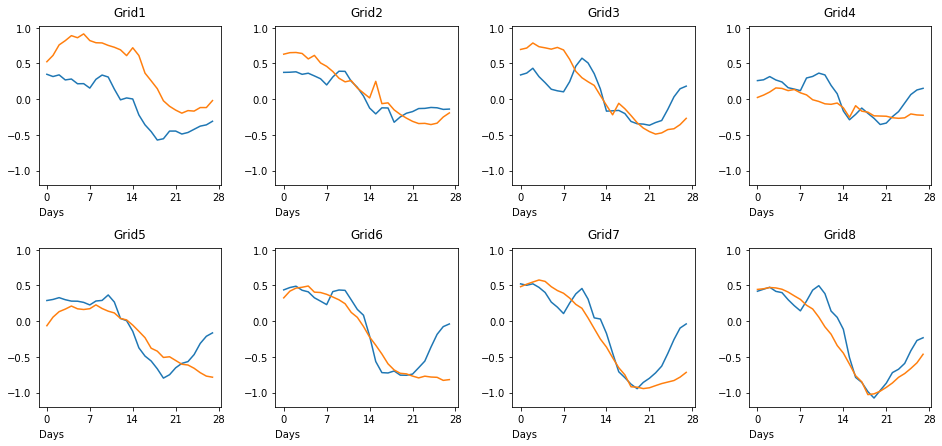

In [50]:
# Best performing LSTM variant (Bidirectional)
plot_predictions(bilstm_model, X1_test, y1_test)

MSE =  0.26184608635819195
RMSE =  0.5117089860049283
MAE =  0.4108695060544057


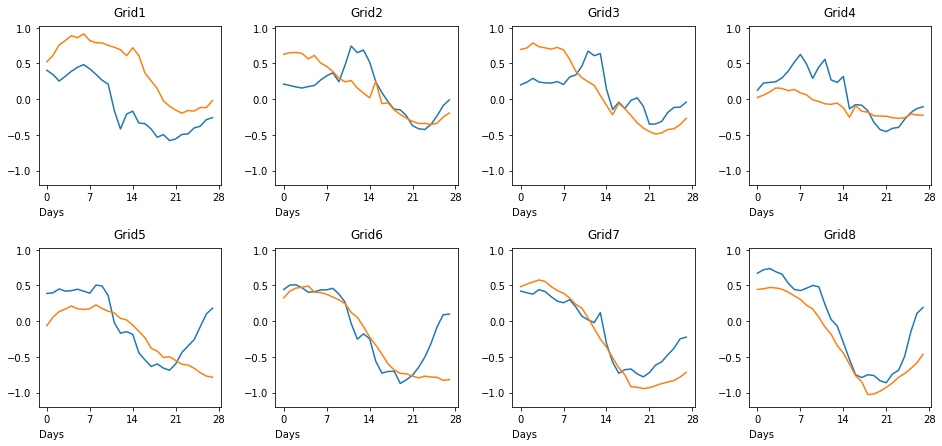

In [51]:
# Best performing GRU variant (Bidirectional)
plot_predictions(bigru_model, X1_test, y1_test)

MSE =  0.34936092973833366
RMSE =  0.5910676185838077
MAE =  0.46833907941486225


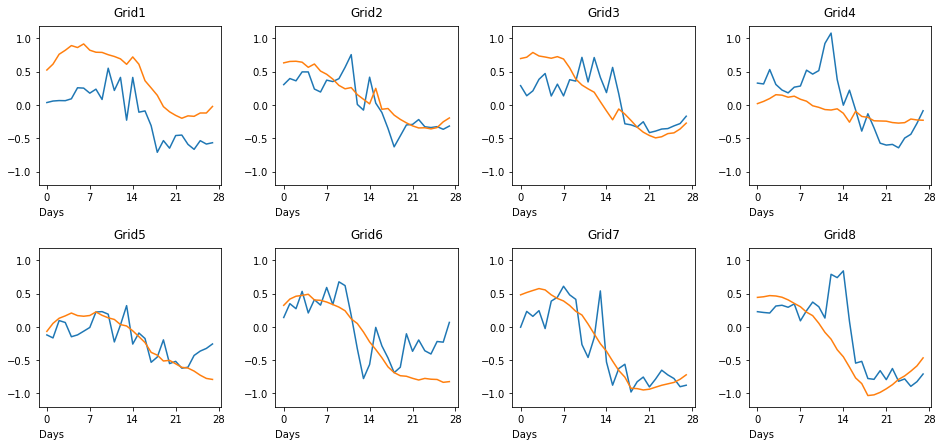

In [52]:
# Best performing CNN variant (Kernel Size = 2)
plot_predictions(cnn_k2_model, X2_test, y2_test)

<style>
    p {
        line-height: 1.5;
    }
</style>

<p style="font-size:22px;"> &emsp; &emsp; 4.6. Attention Mechanism</p>

<p style="text-align: justify;">
The inclusion of an attention layer component in this context has the purpose to force the model to place more value on neighboring observations when looking at observations in a particular point in the grid. A simple attention layer is built and added to the best performing variations of the three neural network types, including bidirectional LSTM, bidirectional GRU, and 1D CNN with kernel size 2. Interestingly, as seen below, the only network that saw improvement with the inclusion of the attention layer was the worst performing network, and the network that saw the biggest negative impact on performance was the best performing one. It seems that the attention layer only served to confuse the LSTM and GRU models instead of focusing them. Regardless, the best performing model remains the bidirectional GRU without the attention layer, with an MSE of 0.248.
</p>

In [37]:
# Attention layer

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        # add trainable weights
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")        
        super().build(input_shape)

    def call(self, inputs):
        # calculate attention weights
        et = K.squeeze(K.tanh(K.dot(inputs, self.W) + self.b), axis=-1)
        at = K.softmax(et)
        at = K.expand_dims(at, axis=-1)
        # apply attention weights to input
        output = inputs * at
        # sum along the time axis
        output = K.sum(output, axis=1)
        return output

    def compute_output_shape(self, input_shape):
        # output shape is same as input shape except the time axis is removed
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        return super().get_config()


<b><font size = 4px> Bidirectional LSTM with Attention Mechanism</font></b>

In [38]:
# Define the model
bilstm_att_model = Sequential()
bilstm_att_model.add(InputLayer((window_size, 937)))
bilstm_att_model.add(Bidirectional(LSTM(640, return_sequences=True)))
bilstm_att_model.add(Bidirectional(LSTM(640, return_sequences=True)))
bilstm_att_model.add(AttentionLayer())
bilstm_att_model.add(Dense(640, activation='relu'))
bilstm_att_model.add(Dense(320, activation='relu'))
bilstm_att_model.add(Dense(187, activation='linear'))

# Define the checkpoint to save the best model during training
cp11 = ModelCheckpoint('bilstm_att_model/', save_best_only=True)

# Compile the model
bilstm_att_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

# Fit the model with validation data and checkpoint
bilstm_att_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp11])

# Load the best saved model
bilstm_att_model = load_model('bilstm_att_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.9134 - root_mean_squared_error: 0.9557

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 47s 4s/step - loss: 0.9134 - root_mean_squared_error: 0.9557 - val_loss: 0.3442 - val_root_mean_squared_error: 0.5867
Epoch 2/25
10/10 [==============================] - 14s 1s/step - loss: 0.6731 - root_mean_squared_error: 0.8204 - val_loss: 0.5282 - val_root_mean_squared_error: 0.7268
Epoch 3/25
10/10 [==============================] - 14s 1s/step - loss: 0.4757 - root_mean_squared_error: 0.6897 - val_loss: 0.5500 - val_root_mean_squared_error: 0.7416
Epoch 4/25
10/10 [==============================] - 14s 1s/step - loss: 0.3310 - root_mean_squared_error: 0.5753 - val_loss: 0.4706 - val_root_mean_squared_error: 0.6860
Epoch 5/25
10/10 [==============================] - 14s 1s/step - loss: 0.2406 - root_mean_squared_error: 0.4905 - val_loss: 0.3662 - val_root_mean_squared_error: 0.6051
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.1898 - root_mean_squared_error: 0.4356

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 39s 4s/step - loss: 0.1898 - root_mean_squared_error: 0.4356 - val_loss: 0.2968 - val_root_mean_squared_error: 0.5448
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.1586 - root_mean_squared_error: 0.3982

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 38s 4s/step - loss: 0.1586 - root_mean_squared_error: 0.3982 - val_loss: 0.2787 - val_root_mean_squared_error: 0.5279
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.1387 - root_mean_squared_error: 0.3725

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 36s 4s/step - loss: 0.1387 - root_mean_squared_error: 0.3725 - val_loss: 0.2758 - val_root_mean_squared_error: 0.5251
Epoch 9/25
10/10 [==============================] - 14s 1s/step - loss: 0.1225 - root_mean_squared_error: 0.3500 - val_loss: 0.2773 - val_root_mean_squared_error: 0.5266
Epoch 10/25
10/10 [==============================] - 14s 1s/step - loss: 0.1092 - root_mean_squared_error: 0.3304 - val_loss: 0.2784 - val_root_mean_squared_error: 0.5277
Epoch 11/25
10/10 [==============================] - 14s 1s/step - loss: 0.0966 - root_mean_squared_error: 0.3108 - val_loss: 0.2777 - val_root_mean_squared_error: 0.5269
Epoch 12/25
10/10 [==============================] - 14s 1s/step - loss: 0.0856 - root_mean_squared_error: 0.2926 - val_loss: 0.2785 - val_root_mean_squared_error: 0.5277
Epoch 13/25
10/10 [==============================] - 14s 1s/step - loss: 0.0759 - root_mean_squared_error: 0.2756 - val_loss: 0.2775 - val_root_mean_squared_e

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 38s 4s/step - loss: 0.0681 - root_mean_squared_error: 0.2610 - val_loss: 0.2748 - val_root_mean_squared_error: 0.5242
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0610 - root_mean_squared_error: 0.2469

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 36s 4s/step - loss: 0.0610 - root_mean_squared_error: 0.2469 - val_loss: 0.2746 - val_root_mean_squared_error: 0.5240
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0561 - root_mean_squared_error: 0.2368

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 38s 4s/step - loss: 0.0561 - root_mean_squared_error: 0.2368 - val_loss: 0.2738 - val_root_mean_squared_error: 0.5233
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0517 - root_mean_squared_error: 0.2273

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 37s 4s/step - loss: 0.0517 - root_mean_squared_error: 0.2273 - val_loss: 0.2737 - val_root_mean_squared_error: 0.5232
Epoch 18/25
10/10 [==============================] - 14s 1s/step - loss: 0.0477 - root_mean_squared_error: 0.2183 - val_loss: 0.2743 - val_root_mean_squared_error: 0.5238
Epoch 19/25
10/10 [==============================] - 14s 1s/step - loss: 0.0440 - root_mean_squared_error: 0.2096 - val_loss: 0.2768 - val_root_mean_squared_error: 0.5262
Epoch 20/25
10/10 [==============================] - 14s 1s/step - loss: 0.0415 - root_mean_squared_error: 0.2037 - val_loss: 0.2750 - val_root_mean_squared_error: 0.5244
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0377 - root_mean_squared_error: 0.1943

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 36s 4s/step - loss: 0.0377 - root_mean_squared_error: 0.1943 - val_loss: 0.2722 - val_root_mean_squared_error: 0.5217
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0352 - root_mean_squared_error: 0.1876

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 37s 4s/step - loss: 0.0352 - root_mean_squared_error: 0.1876 - val_loss: 0.2698 - val_root_mean_squared_error: 0.5194
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0328 - root_mean_squared_error: 0.1812

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 39s 4s/step - loss: 0.0328 - root_mean_squared_error: 0.1812 - val_loss: 0.2664 - val_root_mean_squared_error: 0.5161
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0308 - root_mean_squared_error: 0.1754

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 37s 4s/step - loss: 0.0308 - root_mean_squared_error: 0.1754 - val_loss: 0.2641 - val_root_mean_squared_error: 0.5139
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0287 - root_mean_squared_error: 0.1695

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 36s 4s/step - loss: 0.0287 - root_mean_squared_error: 0.1695 - val_loss: 0.2618 - val_root_mean_squared_error: 0.5116


<b><font size = 4px> Bidirectional GRU with Attention Mechanism</font></b>

In [39]:
# Define the model
bigru_att_model = Sequential()
bigru_att_model.add(InputLayer((window_size, 937)))
bigru_att_model.add(Bidirectional(GRU(640, return_sequences=True)))
bigru_att_model.add(Bidirectional(GRU(640, return_sequences=True)))
bigru_att_model.add(AttentionLayer())
bigru_att_model.add(Dense(640, activation='relu'))
bigru_att_model.add(Dense(320, activation='relu'))
bigru_att_model.add(Dense(187, activation='linear'))

# Define the checkpoint to save the best model during training
cp12 = ModelCheckpoint('bigru_att_model/', save_best_only=True)

# Compile the model
bigru_att_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

# Fit the model with validation data and checkpoint
bigru_att_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp12])

# Load the best saved model
bigru_att_model = load_model('bigru_att_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8144 - root_mean_squared_error: 0.9024

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 42s 3s/step - loss: 0.8144 - root_mean_squared_error: 0.9024 - val_loss: 0.4368 - val_root_mean_squared_error: 0.6609
Epoch 2/25
10/10 [==============================] - 11s 1s/step - loss: 0.5572 - root_mean_squared_error: 0.7465 - val_loss: 0.4965 - val_root_mean_squared_error: 0.7046
Epoch 3/25
10/10 [==============================] - 11s 1s/step - loss: 0.3799 - root_mean_squared_error: 0.6164 - val_loss: 0.4420 - val_root_mean_squared_error: 0.6649
Epoch 4/25
10/10 [==============================] - ETA: 0s - loss: 0.2608 - root_mean_squared_error: 0.5107

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 31s 3s/step - loss: 0.2608 - root_mean_squared_error: 0.5107 - val_loss: 0.3237 - val_root_mean_squared_error: 0.5689
Epoch 5/25
10/10 [==============================] - ETA: 0s - loss: 0.1827 - root_mean_squared_error: 0.4274

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 32s 3s/step - loss: 0.1827 - root_mean_squared_error: 0.4274 - val_loss: 0.2628 - val_root_mean_squared_error: 0.5126
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.1369 - root_mean_squared_error: 0.3700

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 32s 3s/step - loss: 0.1369 - root_mean_squared_error: 0.3700 - val_loss: 0.2332 - val_root_mean_squared_error: 0.4829
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.1133 - root_mean_squared_error: 0.3366

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 34s 4s/step - loss: 0.1133 - root_mean_squared_error: 0.3366 - val_loss: 0.2244 - val_root_mean_squared_error: 0.4737
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.0966 - root_mean_squared_error: 0.3108

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 31s 3s/step - loss: 0.0966 - root_mean_squared_error: 0.3108 - val_loss: 0.2227 - val_root_mean_squared_error: 0.4719
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.0847 - root_mean_squared_error: 0.2910

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 31s 3s/step - loss: 0.0847 - root_mean_squared_error: 0.2910 - val_loss: 0.2195 - val_root_mean_squared_error: 0.4685
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.0750 - root_mean_squared_error: 0.2738

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 49s 5s/step - loss: 0.0750 - root_mean_squared_error: 0.2738 - val_loss: 0.2146 - val_root_mean_squared_error: 0.4633
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0667 - root_mean_squared_error: 0.2582

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 37s 4s/step - loss: 0.0667 - root_mean_squared_error: 0.2582 - val_loss: 0.2136 - val_root_mean_squared_error: 0.4622
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0598 - root_mean_squared_error: 0.2445

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 33s 4s/step - loss: 0.0598 - root_mean_squared_error: 0.2445 - val_loss: 0.2109 - val_root_mean_squared_error: 0.4593
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0538 - root_mean_squared_error: 0.2320

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 30s 3s/step - loss: 0.0538 - root_mean_squared_error: 0.2320 - val_loss: 0.2038 - val_root_mean_squared_error: 0.4515
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0498 - root_mean_squared_error: 0.2231

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 31s 3s/step - loss: 0.0498 - root_mean_squared_error: 0.2231 - val_loss: 0.2002 - val_root_mean_squared_error: 0.4474
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0455 - root_mean_squared_error: 0.2134

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 34s 4s/step - loss: 0.0455 - root_mean_squared_error: 0.2134 - val_loss: 0.1965 - val_root_mean_squared_error: 0.4432
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0416 - root_mean_squared_error: 0.2039

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 31s 3s/step - loss: 0.0416 - root_mean_squared_error: 0.2039 - val_loss: 0.1909 - val_root_mean_squared_error: 0.4369
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0386 - root_mean_squared_error: 0.1964

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 31s 3s/step - loss: 0.0386 - root_mean_squared_error: 0.1964 - val_loss: 0.1851 - val_root_mean_squared_error: 0.4302
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0357 - root_mean_squared_error: 0.1889

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 34s 4s/step - loss: 0.0357 - root_mean_squared_error: 0.1889 - val_loss: 0.1815 - val_root_mean_squared_error: 0.4260
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0332 - root_mean_squared_error: 0.1821

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 31s 3s/step - loss: 0.0332 - root_mean_squared_error: 0.1821 - val_loss: 0.1775 - val_root_mean_squared_error: 0.4213
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0316 - root_mean_squared_error: 0.1778

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 33s 4s/step - loss: 0.0316 - root_mean_squared_error: 0.1778 - val_loss: 0.1742 - val_root_mean_squared_error: 0.4174
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0295 - root_mean_squared_error: 0.1717

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 31s 3s/step - loss: 0.0295 - root_mean_squared_error: 0.1717 - val_loss: 0.1727 - val_root_mean_squared_error: 0.4155
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0275 - root_mean_squared_error: 0.1659

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 31s 3s/step - loss: 0.0275 - root_mean_squared_error: 0.1659 - val_loss: 0.1673 - val_root_mean_squared_error: 0.4090
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0257 - root_mean_squared_error: 0.1604

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 33s 4s/step - loss: 0.0257 - root_mean_squared_error: 0.1604 - val_loss: 0.1648 - val_root_mean_squared_error: 0.4059
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0241 - root_mean_squared_error: 0.1553

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 30s 3s/step - loss: 0.0241 - root_mean_squared_error: 0.1553 - val_loss: 0.1635 - val_root_mean_squared_error: 0.4044
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0228 - root_mean_squared_error: 0.1509

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 34s 4s/step - loss: 0.0228 - root_mean_squared_error: 0.1509 - val_loss: 0.1602 - val_root_mean_squared_error: 0.4002


<b><font size = 4px> 1-Dimensional CNN (Kernel Size = 2) with Attention Mechanism</font></b>

In [40]:
# Define the model
cnn_k2_att_model = Sequential()
cnn_k2_att_model.add(InputLayer((window_size2, 937)))
cnn_k2_att_model.add(Conv1D(640, kernel_size=2, activation='relu'))
cnn_k2_att_model.add(AttentionLayer())
cnn_k2_att_model.add(Dense(320, activation='relu'))
cnn_k2_att_model.add(Dense(187, activation='linear'))

# Define the checkpoint to save the best model during training
cp13 = ModelCheckpoint('cnn_k2_att_model/', save_best_only=True)

# Compile the model
cnn_k2_att_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

# Fit the model with validation data and checkpoint
cnn_k2_att_model.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=25, callbacks=[cp13])

# Load the best saved model
cnn_k2_att_model = load_model('cnn_k2_att_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 1.0099 - root_mean_squared_error: 1.0049INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 200ms/step - loss: 1.0099 - root_mean_squared_error: 1.0049 - val_loss: 0.4511 - val_root_mean_squared_error: 0.6717
Epoch 2/25
10/10 [==============================] - 1s 98ms/step - loss: 0.6089 - root_mean_squared_error: 0.7803 - val_loss: 0.4713 - val_root_mean_squared_error: 0.6865
Epoch 3/25
10/10 [==============================] - 1s 90ms/step - loss: 0.4367 - root_mean_squared_error: 0.6608 - val_loss: 0.4664 - val_root_mean_squared_error: 0.6829
Epoch 4/25
10/10 [==============================] - 1s 105ms/step - loss: 0.3101 - root_mean_squared_error: 0.5569 - val_loss: 0.4614 - val_root_mean_squared_error: 0.6792
Epoch 5/25
10/10 [==============================] - ETA: 0s - loss: 0.2295 - root_mean_squared_error: 0.4791INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 177ms/step - loss: 0.2295 - root_mean_squared_error: 0.4791 - val_loss: 0.4374 - val_root_mean_squared_error: 0.6614
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.1777 - root_mean_squared_error: 0.4216INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 184ms/step - loss: 0.1777 - root_mean_squared_error: 0.4216 - val_loss: 0.4189 - val_root_mean_squared_error: 0.6472
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.1488 - root_mean_squared_error: 0.3857INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 180ms/step - loss: 0.1488 - root_mean_squared_error: 0.3857 - val_loss: 0.3995 - val_root_mean_squared_error: 0.6320
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.1317 - root_mean_squared_error: 0.3630INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 184ms/step - loss: 0.1317 - root_mean_squared_error: 0.3630 - val_loss: 0.3849 - val_root_mean_squared_error: 0.6204
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.1191 - root_mean_squared_error: 0.3452INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 196ms/step - loss: 0.1191 - root_mean_squared_error: 0.3452 - val_loss: 0.3692 - val_root_mean_squared_error: 0.6076
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.1094 - root_mean_squared_error: 0.3308INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 189ms/step - loss: 0.1094 - root_mean_squared_error: 0.3308 - val_loss: 0.3602 - val_root_mean_squared_error: 0.6002
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.1002 - root_mean_squared_error: 0.3165INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 182ms/step - loss: 0.1002 - root_mean_squared_error: 0.3165 - val_loss: 0.3516 - val_root_mean_squared_error: 0.5929
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0922 - root_mean_squared_error: 0.3037INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 186ms/step - loss: 0.0922 - root_mean_squared_error: 0.3037 - val_loss: 0.3440 - val_root_mean_squared_error: 0.5865
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0852 - root_mean_squared_error: 0.2920INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 177ms/step - loss: 0.0852 - root_mean_squared_error: 0.2920 - val_loss: 0.3375 - val_root_mean_squared_error: 0.5810
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0786 - root_mean_squared_error: 0.2803INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 193ms/step - loss: 0.0786 - root_mean_squared_error: 0.2803 - val_loss: 0.3283 - val_root_mean_squared_error: 0.5730
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0724 - root_mean_squared_error: 0.2691INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 184ms/step - loss: 0.0724 - root_mean_squared_error: 0.2691 - val_loss: 0.3259 - val_root_mean_squared_error: 0.5709
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0671 - root_mean_squared_error: 0.2591INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 179ms/step - loss: 0.0671 - root_mean_squared_error: 0.2591 - val_loss: 0.3175 - val_root_mean_squared_error: 0.5635
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0622 - root_mean_squared_error: 0.2493INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 186ms/step - loss: 0.0622 - root_mean_squared_error: 0.2493 - val_loss: 0.3139 - val_root_mean_squared_error: 0.5603
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0578 - root_mean_squared_error: 0.2405INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 186ms/step - loss: 0.0578 - root_mean_squared_error: 0.2405 - val_loss: 0.3102 - val_root_mean_squared_error: 0.5570
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0541 - root_mean_squared_error: 0.2326INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 175ms/step - loss: 0.0541 - root_mean_squared_error: 0.2326 - val_loss: 0.3031 - val_root_mean_squared_error: 0.5506
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0508 - root_mean_squared_error: 0.2254INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 181ms/step - loss: 0.0508 - root_mean_squared_error: 0.2254 - val_loss: 0.3028 - val_root_mean_squared_error: 0.5502
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0483 - root_mean_squared_error: 0.2197INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 181ms/step - loss: 0.0483 - root_mean_squared_error: 0.2197 - val_loss: 0.2980 - val_root_mean_squared_error: 0.5459
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0458 - root_mean_squared_error: 0.2141INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 175ms/step - loss: 0.0458 - root_mean_squared_error: 0.2141 - val_loss: 0.2948 - val_root_mean_squared_error: 0.5430
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0437 - root_mean_squared_error: 0.2091INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 197ms/step - loss: 0.0437 - root_mean_squared_error: 0.2091 - val_loss: 0.2919 - val_root_mean_squared_error: 0.5402
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0415 - root_mean_squared_error: 0.2037INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 190ms/step - loss: 0.0415 - root_mean_squared_error: 0.2037 - val_loss: 0.2894 - val_root_mean_squared_error: 0.5379
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0398 - root_mean_squared_error: 0.1994INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 179ms/step - loss: 0.0398 - root_mean_squared_error: 0.1994 - val_loss: 0.2830 - val_root_mean_squared_error: 0.5320


<b><font size = 4px>Comparing Performance with and without Attention Mechanism</font></b>

In [41]:
# Initialize empty lists for metrics
MSEs_2 = []
RMSEs_2 = []
MAEs_2 = []

# Predict with bilstm_att_model and append metrics
pred_bilstm_att = bilstm_att_model.predict(X1_test).flatten()
MSEs_2.append(mse(y1_test.flatten(), pred_bilstm_att))
RMSEs_2.append(np.sqrt(mse(y1_test.flatten(), pred_bilstm_att)))
MAEs_2.append(mae(y1_test.flatten(), pred_bilstm_att))

# Predict with bigru_att_model and append metrics
pred_bigru_att = bigru_att_model.predict(X1_test).flatten()
MSEs_2.append(mse(y1_test.flatten(), pred_bigru_att))
RMSEs_2.append(np.sqrt(mse(y1_test.flatten(), pred_bigru_att)))
MAEs_2.append(mae(y1_test.flatten(), pred_bigru_att))

# Predict with cnn_k2_att_model and append metrics
pred_cnn_k2_att = cnn_k2_att_model.predict(X2_test).flatten()
MSEs_2.append(mse(y2_test.flatten(), pred_cnn_k2_att))
RMSEs_2.append(np.sqrt(mse(y2_test.flatten(), pred_cnn_k2_att)))
MAEs_2.append(mae(y2_test.flatten(), pred_cnn_k2_att))

# Set column names for the performance DataFrame
col_names_2 = ['Bi LSTM + Att', 'Bi GRU + Att', '1D CNN (Ker 2) + Att']

# Create an empty DataFrame to store performance metrics
performance_df_2 = pd.DataFrame()
performance_df_2['KPIs'] = ['MSE', 'RMSE', 'MAE']

# Iterate over column names and append metrics to performance_df_2
for i in range(len(col_names_2)):
    performance_df_2[col_names_2[i]] = [MSEs_2[i], RMSEs_2[i], MAEs_2[i]]

In [42]:
# Performance of best LSTM, GRU and CNN variants with Attention Layer
performance_df_2

,KPIs,Bi LSTM + Att,Bi GRU + Att,1D CNN (Ker 2) + Att
0,MSE,0.311436,0.267165,0.345796
1,RMSE,0.558065,0.516880,0.588045
2,MAE,0.448584,0.415640,0.469689


In [53]:
# Performance of best LSTM, GRU and CNN variants without Attention Layer
performance_df.drop(['V LSTM', 'St LSTM', 'Bi+St LSTM', 'V GRU', 'St GRU', 'Bi+St GRU', '1D CNN (Ker 4)'], axis = 1)

,KPIs,Bi LSTM,Bi GRU,1D CNN (Ker 2)
0,MSE,0.292004,0.261846,0.349361
1,RMSE,0.540374,0.511709,0.591068
2,MAE,0.434705,0.410870,0.468339


<style>
    p {
        line-height: 1.5;
    }
</style>

<p style="font-size:22px;"> &emsp; &emsp; 4.6. Increasing Complexity</p>

<p style="text-align: justify;">
To see if the performance of the GRU network can be improved, dense layers are added and the number of units in each layer is increased below. Several different combinations of layer sizes are created for the GRU and dense layers, and each network is run for 25 epochs, saving the KPIs of the best performing model. The best performing model had an MSE of 0.184. The most complex network out of all the variations tested in this section produced the best performance, but it took half an hour to run, compared to the vanilla GRU network which took just over a minute. While more complexity may further reduce the MSE, it is important to consider the time it takes to run the algorithm in real-world scenarios.
</p>

In [10]:

# define lists for the different sizes of layers
GRU_sizes = [1280, 1920, 2560]
Dense0_sizes = [960, 1280, 1920]
Dense1_sizes = [640, 1280]
Dense2_sizes = [480, 960] 
Dense3_sizes = [320, 640]
Dense4_size = 320
Dense5_size = 187 

# define empty lists to store shapes and MSEs
GRU_shape = []
Dense0_shape = []
Dense1_shape = []
Dense2_shape = []
Dense3_shape = []
Dense4_shape = []
MSEs_ds = []

# Loop through the different layer sizes and create models with those configurations
for gru_size in GRU_sizes:
    for dense0_size in Dense0_sizes:
        # Check if the size of dense0 layer is less than gru layer
        if dense0_size < gru_size:
            for dense1_size in Dense1_sizes:
                # Check if the size of dense1 layer is less than dense0 layer
                if dense1_size < dense0_size:
                    for dense2_size in Dense2_sizes:
                        # Check if the size of dense2 layer is less than dense1 layer
                        if dense2_size < dense1_size:
                            gru_ds_model = Sequential()
                            gru_ds_model.add(InputLayer((window_size, 937)))
                            gru_ds_model.add(Bidirectional(GRU(gru_size, return_sequences=True)))
                            gru_ds_model.add(Bidirectional(GRU(gru_size)))
                            GRU_shape.append(gru_size)

                            gru_ds_model.add(Dense(dense0_size, activation='relu'))
                            Dense0_shape.append(dense0_size)

                            gru_ds_model.add(Dense(dense1_size, activation='relu'))
                            Dense1_shape.append(dense1_size)

                            gru_ds_model.add(Dense(dense2_size, activation='relu'))
                            Dense2_shape.append(dense2_size)

                            if dense2_size == 480:
                                gru_ds_model.add(Dense(Dense3_sizes[0], activation='relu'))
                                Dense3_shape.append(Dense3_sizes[0])
                                Dense4_shape.append(np.NaN)
                            if dense2_size == 640:
                                gru_ds_model.add(Dense(Dense3_sizes[0], activation='relu'))
                                Dense3_shape.append(Dense3_sizes[0])
                                Dense4_shape.append(np.NaN)
                            if dense2_size == 960:
                                gru_ds_model.add(Dense(Dense3_sizes[1], activation='relu'))
                                Dense3_shape.append(Dense3_sizes[1])
                                for i in range(2):
                                    if i == 0:
                                        Dense4_shape.append(np.NaN)
                                    if i == 1:
                                        gru_ds_model.add(Dense(Dense4_size, activation='relu'))
                                        Dense4_shape.append(Dense4_size)

                            gru_ds_model.add(Dense(Dense5_size, activation='linear'))
                            
                            # create model checkpoint to save the best performing model
                            checkpoint = ModelCheckpoint('gru_ds_model/', save_best_only=True)
                            
                            # compile the model with specified loss function, optimizer, and metrics
                            gru_ds_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

                            # train the model on training data and validate on validation data
                            gru_ds_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, verbose=0, callbacks=[checkpoint])

                            # load the best model checkpoint
                            gru_ds_model = load_model('gru_ds_model/')

                            # make predictions on test data and append the mean squared error to a list
                            predictions = gru_ds_model.predict(X1_test).flatten()
                            MSEs_ds.append(mse(y1_test.flatten(), predictions))


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


In [11]:
# Determine indices of optimal and worst parameters
min_index = MSEs_ds.index(min(MSEs_ds))
max_index = MSEs_ds.index(max(MSEs_ds))

# Print mean MSE
print(f"Mean MSE = {np.mean(MSEs_ds)}\n\n")

# Print optimal parameters
print("OPTIMAL PARAMETERS:\n")
print(f"GRU size: {GRU_shape[min_index]}")
print(f"Dense0 size: {Dense0_shape[min_index]}")
print(f"Dense1 size: {Dense1_shape[min_index]}")
print(f"Dense2 size: {Dense2_shape[min_index]}")
print(f"Dense3 size: {Dense3_shape[min_index]}")
print(f"Dense4 size: {Dense4_shape[min_index]}")
print(f"Min MSE = {min(MSEs_ds)}\n")

# Print worst parameters
print("WORST PARAMETERS:\n")
print(f"GRU size: {GRU_shape[max_index]}")
print(f"Dense0 size: {Dense0_shape[max_index]}")
print(f"Dense1 size: {Dense1_shape[max_index]}")
print(f"Dense2 size: {Dense2_shape[max_index]}")
print(f"Dense3 size: {Dense3_shape[max_index]}")
print(f"Dense4 size: {Dense4_shape[max_index]}")
print(f"Max MSE = {max(MSEs_ds)}")

Mean MSE = 0.25649850508077626


OPTIMAL PARAMETERS:

GRU size: 2560
Dense0 size: 1920
Dense1 size: 640
Dense2 size: 480
Dense3 size: 320
Dense4 size: nan
Min MSE = 0.24723850080447612

WORST PARAMETERS:

GRU size: 1920
Dense0 size: 960
Dense1 size: 640
Dense2 size: 480
Dense3 size: 320
Dense4 size: nan
Max MSE = 0.27386742405466125


<b><font size = 4px>Best Performing Model and Animation of Predictions</font></b>

In [20]:
# Define the model
best_gru_model = Sequential()
best_gru_model.add(InputLayer((window_size, 937)))
best_gru_model.add(Bidirectional(GRU(2560, return_sequences=True)))
best_gru_model.add(Bidirectional(GRU(2560)))
best_gru_model.add(Dense(1920, activation='relu'))
best_gru_model.add(Dense(640, activation='relu'))
best_gru_model.add(Dense(480, activation='relu'))
best_gru_model.add(Dense(320, activation='relu'))
best_gru_model.add(Dense(187, activation='linear'))

# Define the checkpoint to save the best model during training
cp15 = ModelCheckpoint('best_gru_model/', save_best_only=True)

# Compile the model
best_gru_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

# Fit the model with validation data and checkpoint
best_gru_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=35, callbacks=[cp15])

# Load the best saved model
best_gru_model = load_model('best_gru_model/')

Epoch 1/35
10/10 [==============================] - ETA: 0s - loss: 0.7475 - root_mean_squared_error: 0.8646

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 71s 7s/step - loss: 0.7475 - root_mean_squared_error: 0.8646 - val_loss: 0.3756 - val_root_mean_squared_error: 0.6129
Epoch 2/35
10/10 [==============================] - ETA: 0s - loss: 0.4384 - root_mean_squared_error: 0.6621

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 49s 5s/step - loss: 0.4384 - root_mean_squared_error: 0.6621 - val_loss: 0.2831 - val_root_mean_squared_error: 0.5321
Epoch 3/35
10/10 [==============================] - ETA: 0s - loss: 0.2722 - root_mean_squared_error: 0.5217

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 48s 5s/step - loss: 0.2722 - root_mean_squared_error: 0.5217 - val_loss: 0.2477 - val_root_mean_squared_error: 0.4977
Epoch 4/35
10/10 [==============================] - ETA: 0s - loss: 0.1702 - root_mean_squared_error: 0.4126

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 51s 5s/step - loss: 0.1702 - root_mean_squared_error: 0.4126 - val_loss: 0.2321 - val_root_mean_squared_error: 0.4817
Epoch 5/35
10/10 [==============================] - ETA: 0s - loss: 0.1168 - root_mean_squared_error: 0.3417

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 55s 6s/step - loss: 0.1168 - root_mean_squared_error: 0.3417 - val_loss: 0.2251 - val_root_mean_squared_error: 0.4745
Epoch 6/35
10/10 [==============================] - ETA: 0s - loss: 0.0921 - root_mean_squared_error: 0.3035

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 60s 6s/step - loss: 0.0921 - root_mean_squared_error: 0.3035 - val_loss: 0.2223 - val_root_mean_squared_error: 0.4714
Epoch 7/35
10/10 [==============================] - ETA: 0s - loss: 0.0774 - root_mean_squared_error: 0.2782

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 60s 6s/step - loss: 0.0774 - root_mean_squared_error: 0.2782 - val_loss: 0.2193 - val_root_mean_squared_error: 0.4683
Epoch 8/35
10/10 [==============================] - ETA: 0s - loss: 0.0669 - root_mean_squared_error: 0.2586

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 58s 6s/step - loss: 0.0669 - root_mean_squared_error: 0.2586 - val_loss: 0.2152 - val_root_mean_squared_error: 0.4639
Epoch 9/35
10/10 [==============================] - ETA: 0s - loss: 0.0584 - root_mean_squared_error: 0.2416

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 62s 6s/step - loss: 0.0584 - root_mean_squared_error: 0.2416 - val_loss: 0.2125 - val_root_mean_squared_error: 0.4609
Epoch 10/35
10/10 [==============================] - ETA: 0s - loss: 0.0517 - root_mean_squared_error: 0.2275

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 63s 7s/step - loss: 0.0517 - root_mean_squared_error: 0.2275 - val_loss: 0.2072 - val_root_mean_squared_error: 0.4552
Epoch 11/35
10/10 [==============================] - ETA: 0s - loss: 0.0461 - root_mean_squared_error: 0.2147

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 77s 8s/step - loss: 0.0461 - root_mean_squared_error: 0.2147 - val_loss: 0.2041 - val_root_mean_squared_error: 0.4518
Epoch 12/35
10/10 [==============================] - ETA: 0s - loss: 0.0416 - root_mean_squared_error: 0.2039

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 77s 8s/step - loss: 0.0416 - root_mean_squared_error: 0.2039 - val_loss: 0.1999 - val_root_mean_squared_error: 0.4471
Epoch 13/35
10/10 [==============================] - ETA: 0s - loss: 0.0382 - root_mean_squared_error: 0.1954

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 73s 8s/step - loss: 0.0382 - root_mean_squared_error: 0.1954 - val_loss: 0.1960 - val_root_mean_squared_error: 0.4427
Epoch 14/35
10/10 [==============================] - ETA: 0s - loss: 0.0350 - root_mean_squared_error: 0.1870

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 69s 7s/step - loss: 0.0350 - root_mean_squared_error: 0.1870 - val_loss: 0.1907 - val_root_mean_squared_error: 0.4367
Epoch 15/35
10/10 [==============================] - ETA: 0s - loss: 0.0320 - root_mean_squared_error: 0.1789

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 69s 7s/step - loss: 0.0320 - root_mean_squared_error: 0.1789 - val_loss: 0.1875 - val_root_mean_squared_error: 0.4330
Epoch 16/35
10/10 [==============================] - ETA: 0s - loss: 0.0300 - root_mean_squared_error: 0.1731

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 81s 8s/step - loss: 0.0300 - root_mean_squared_error: 0.1731 - val_loss: 0.1849 - val_root_mean_squared_error: 0.4300
Epoch 17/35
10/10 [==============================] - ETA: 0s - loss: 0.0279 - root_mean_squared_error: 0.1669

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 86s 9s/step - loss: 0.0279 - root_mean_squared_error: 0.1669 - val_loss: 0.1820 - val_root_mean_squared_error: 0.4266
Epoch 18/35
10/10 [==============================] - ETA: 0s - loss: 0.0264 - root_mean_squared_error: 0.1626

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 93s 10s/step - loss: 0.0264 - root_mean_squared_error: 0.1626 - val_loss: 0.1804 - val_root_mean_squared_error: 0.4247
Epoch 19/35
10/10 [==============================] - ETA: 0s - loss: 0.0252 - root_mean_squared_error: 0.1588

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 83s 9s/step - loss: 0.0252 - root_mean_squared_error: 0.1588 - val_loss: 0.1764 - val_root_mean_squared_error: 0.4200
Epoch 20/35
10/10 [==============================] - ETA: 0s - loss: 0.0234 - root_mean_squared_error: 0.1530

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 70s 7s/step - loss: 0.0234 - root_mean_squared_error: 0.1530 - val_loss: 0.1736 - val_root_mean_squared_error: 0.4166
Epoch 21/35
10/10 [==============================] - ETA: 0s - loss: 0.0224 - root_mean_squared_error: 0.1495

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 71s 7s/step - loss: 0.0224 - root_mean_squared_error: 0.1495 - val_loss: 0.1716 - val_root_mean_squared_error: 0.4143
Epoch 22/35
10/10 [==============================] - ETA: 0s - loss: 0.0211 - root_mean_squared_error: 0.1453

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 69s 7s/step - loss: 0.0211 - root_mean_squared_error: 0.1453 - val_loss: 0.1690 - val_root_mean_squared_error: 0.4111
Epoch 23/35
10/10 [==============================] - ETA: 0s - loss: 0.0199 - root_mean_squared_error: 0.1410

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 81s 8s/step - loss: 0.0199 - root_mean_squared_error: 0.1410 - val_loss: 0.1682 - val_root_mean_squared_error: 0.4101
Epoch 24/35
10/10 [==============================] - ETA: 0s - loss: 0.0195 - root_mean_squared_error: 0.1396

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 88s 9s/step - loss: 0.0195 - root_mean_squared_error: 0.1396 - val_loss: 0.1660 - val_root_mean_squared_error: 0.4075
Epoch 25/35
10/10 [==============================] - ETA: 0s - loss: 0.0183 - root_mean_squared_error: 0.1354

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 59s 6s/step - loss: 0.0183 - root_mean_squared_error: 0.1354 - val_loss: 0.1628 - val_root_mean_squared_error: 0.4035
Epoch 26/35
10/10 [==============================] - ETA: 0s - loss: 0.0175 - root_mean_squared_error: 0.1322

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 65s 7s/step - loss: 0.0175 - root_mean_squared_error: 0.1322 - val_loss: 0.1626 - val_root_mean_squared_error: 0.4032
Epoch 27/35
10/10 [==============================] - ETA: 0s - loss: 0.0173 - root_mean_squared_error: 0.1317

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 68s 7s/step - loss: 0.0173 - root_mean_squared_error: 0.1317 - val_loss: 0.1610 - val_root_mean_squared_error: 0.4013
Epoch 28/35
10/10 [==============================] - ETA: 0s - loss: 0.0163 - root_mean_squared_error: 0.1276

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 64s 7s/step - loss: 0.0163 - root_mean_squared_error: 0.1276 - val_loss: 0.1598 - val_root_mean_squared_error: 0.3997
Epoch 29/35
10/10 [==============================] - ETA: 0s - loss: 0.0160 - root_mean_squared_error: 0.1263

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 73s 8s/step - loss: 0.0160 - root_mean_squared_error: 0.1263 - val_loss: 0.1570 - val_root_mean_squared_error: 0.3962
Epoch 30/35
10/10 [==============================] - ETA: 0s - loss: 0.0150 - root_mean_squared_error: 0.1226

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 79s 8s/step - loss: 0.0150 - root_mean_squared_error: 0.1226 - val_loss: 0.1563 - val_root_mean_squared_error: 0.3954
Epoch 31/35
10/10 [==============================] - ETA: 0s - loss: 0.0143 - root_mean_squared_error: 0.1194

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 86s 9s/step - loss: 0.0143 - root_mean_squared_error: 0.1194 - val_loss: 0.1542 - val_root_mean_squared_error: 0.3927
Epoch 32/35
10/10 [==============================] - ETA: 0s - loss: 0.0131 - root_mean_squared_error: 0.1146

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 80s 8s/step - loss: 0.0131 - root_mean_squared_error: 0.1146 - val_loss: 0.1535 - val_root_mean_squared_error: 0.3918
Epoch 33/35
10/10 [==============================] - ETA: 0s - loss: 0.0129 - root_mean_squared_error: 0.1137

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 74s 8s/step - loss: 0.0129 - root_mean_squared_error: 0.1137 - val_loss: 0.1532 - val_root_mean_squared_error: 0.3914
Epoch 34/35
10/10 [==============================] - ETA: 0s - loss: 0.0125 - root_mean_squared_error: 0.1120

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 76s 8s/step - loss: 0.0125 - root_mean_squared_error: 0.1120 - val_loss: 0.1521 - val_root_mean_squared_error: 0.3900
Epoch 35/35
10/10 [==============================] - ETA: 0s - loss: 0.0133 - root_mean_squared_error: 0.1153

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 83s 9s/step - loss: 0.0133 - root_mean_squared_error: 0.1153 - val_loss: 0.1505 - val_root_mean_squared_error: 0.3879


MSE =  0.24132956036833997
RMSE =  0.49125305125601
MAE =  0.39484808010291506


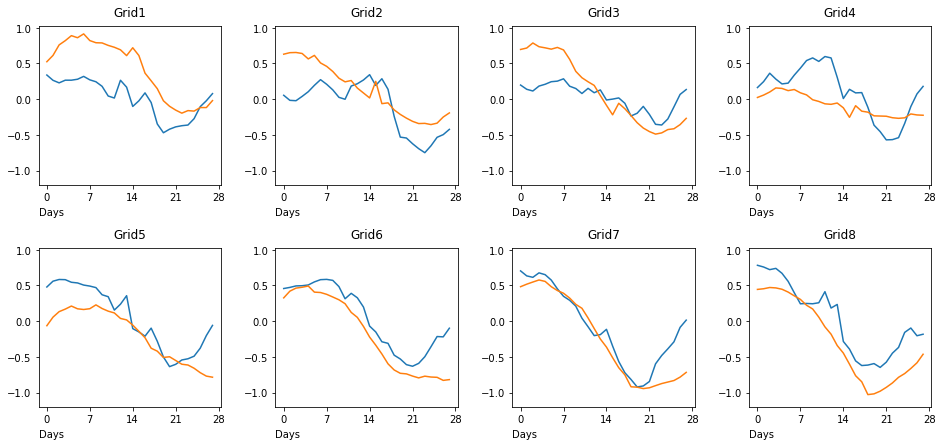

In [21]:
# Best performing model
plot_predictions(best_gru_model, X1_test, y1_test)

In [22]:
predictions = best_gru_model.predict(X1_test).flatten()

# update a single value in the 'surface_type' numpy array
surface_type[4, 2] = 1

# create a copy of the 'surface_type' array with all values multiplied by 1.6
surface_type2 = surface_type * 1.6

# create an array to hold the mapped predictions
mapped_preds = np.empty(28, dtype=object)

# loop over each day of predictions
for i in range(28):
    # initialize the mapped prediction array for this day
    mapped_preds[i] = surface_type2.flatten().astype('float')
    # loop over each grid point in the prediction array and replace the value
    # with the corresponding prediction value if the surface type is 0 (unlabeled)
    for j in range(187):
        mapped_preds[i][np.where(surface_type2.flatten() == 0)[0][j]] = \
            predictions[i*187:(i+1)*187][j]

# create an array to hold the mapped test labels
mapped_y_test = np.empty(28, dtype=object)
for i in range(28):
    # initialize the mapped test label array for this day
    mapped_y_test[i] = surface_type2.flatten().astype('float')
    # loop over each grid point in the test label array and replace the value
    # with the corresponding label value if the surface type is 0 (unlabeled)
    for j in range(187):
        mapped_y_test[i][np.where(surface_type2.flatten() == 0)[0][j]] = y1_test[i, j]

# create an array of grids for the mapped predictions
grids = np.empty(28, dtype=object)
for i in range(28):
    grids[i] = mapped_preds[i].reshape((s, s))

# create an array of grids for the mapped test labels
y_grid = np.empty(28, dtype=object)
for i in range(28):
    y_grid[i] = mapped_y_test[i].reshape((s, s))

..........................................

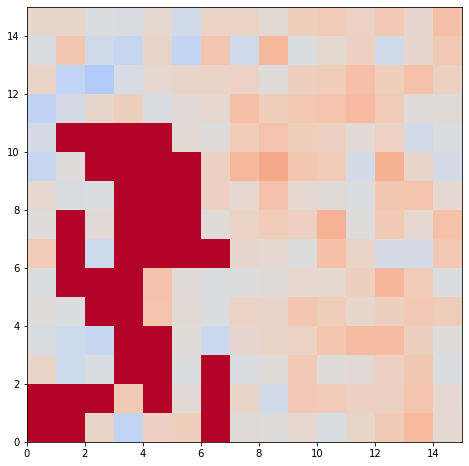

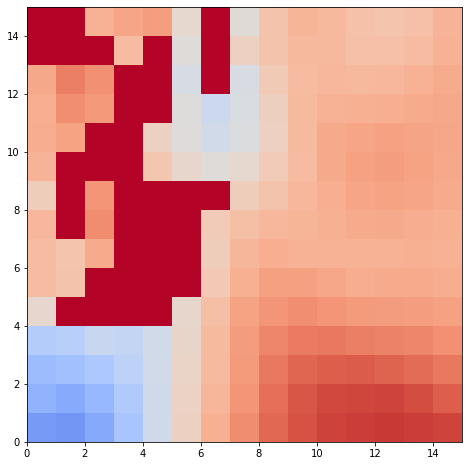

In [24]:
# Set constants
fps = 5
n_seconds = 19.2

# Flip grids vertically and store in new arrays
grids_r = np.empty(len(grids), dtype=object)
for i in range(len(grids_r)):
    grids_r[i]= np.flip(grids[i], 0)
y_grid_r = np.flipud(y_grid)
for i in range(len(y_grid_r)):
    y_grid_r[i]= np.flip(y_grid[i], 0)

# Create snapshots arrays by concatenating copies of grids/y_grid
snapshots_p = grids_r.tolist() + 4 * grids_r.tolist()[-1:] + grids_r.tolist() + 4 * grids_r.tolist()[-1:] + grids_r.tolist() + 4 * grids_r.tolist()[-1:] + grids_r.tolist() + 4 * grids_r.tolist()[-1:] + grids_r.tolist() + 4 * grids_r.tolist()[-1:]
snapshots_y = y_grid_r.tolist() + 4 * y_grid_r.tolist()[-1:] + y_grid_r.tolist() + 4 * y_grid_r.tolist()[-1:] + y_grid_r.tolist() + 4 * y_grid_r.tolist()[-1:] + y_grid_r.tolist() + 4 * y_grid_r.tolist()[-1:] + y_grid_r.tolist() + 4 * y_grid_r.tolist()[-1:]

# Create figure objects
fig_p, ax_p = plt.subplots(figsize=(8,8))
fig_y, ax_y = plt.subplots(figsize=(8,8))

# Set up image plots
im_p = ax_p.imshow(snapshots_p[0], extent=(0, 15, 0, 15), interpolation='nearest', vmin=-1.82, vmax=1.6, cmap=cm.coolwarm)
im_y = ax_y.imshow(snapshots_y[0], extent=(0, 15, 0, 15), interpolation='nearest', vmin=-1.82, vmax=1.6, cmap=cm.coolwarm)

# Define animation update functions
def animateP_func(i):
    if i % fps == 0:
        print('.', end='')
    im_p.set_array(snapshots_p[i])
    return [im_p]

def animateY_func(i):
    if i % fps == 0:
        print('.', end='')
    im_y.set_array(snapshots_y[i])
    return [im_y]

# Create animations
animP = animation.FuncAnimation(
    fig_p,
    animateP_func,
    frames=int(n_seconds * fps),
    interval=1000 / fps
)

animY = animation.FuncAnimation(
    fig_y,
    animateY_func,
    frames=int(n_seconds * fps),
    interval=1000 / fps
)

# Save animations to file
animP.save('test_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])
animY.save('y_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

In [72]:
from ipywidgets import HBox
from IPython.display import display

# Define the filepaths
filepaths = ['C:/Users/Gil Senecaut/Desktop/UC3M/TFM/Scripts/test_anim.mp4',
             'C:/Users/Gil Senecaut/Desktop/UC3M/TFM/Scripts/y_anim.mp4']

# Create the Gridspec layout
n_cols = len(filepaths)
gs = GridspecLayout(1, n_cols)

# Loop through the filepaths and add videos to the Gridspec layout
for i, filepath in enumerate(filepaths):
    # Create video element from file and add it to the Gridspec layout
    video = Video.from_file(filepath, embed=True, width=400, height=400)
    gs[0, i] = video

# Show the Gridspec layout
gs

GridspecLayout(children=(Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08fr…

<style>
    p {
        line-height: 1.5;
    }
</style>

<p style="font-size:25px;"><b>5. Conclusion</b></p>

<p style="text-align: justify;">
My thesis focuses on the possible use of deep learning in coastal flood advisory and risk assessment in the Eastern Visayas region of the Philippines. Despite limitations, the best neural network was the GRU network with bidirectionality, producing forecasts with an MSE of 0.184. However, more research is needed to develop a model for use in a real-world scenario. There are many more ways to achieve the optimum balance between accuracy and computational efficiency when developing a neural network system to forecast spatial weather data but perhaps the priority is outside the remit of deep learning models alone.
</p>